# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os
import argparse
import glob
import sys 
import yaml 
import glob
import h5py 
import ray
import logging 
import json
import gc
import cv2
import time
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
# import io_dict_to_hdf5 as ioh5 ///
import xarray as xr
import scipy.linalg as linalg
import scipy.sparse as sparse
import matplotlib.gridspec as gridspec

from tqdm.notebook import tqdm
from matplotlib.backends.backend_pdf import PdfPages
from scipy.signal import medfilt
from pathlib import Path
from scipy.optimize import minimize_scalar,minimize
from scipy.interpolate import interp1d
from scipy.ndimage import shift as imshift
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn import linear_model as lm 
from scipy.stats import binned_statistic
from sklearn.utils import shuffle
from sklearn.metrics import r2_score, mean_poisson_deviance

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
from kornia.geometry.transform import Affine
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sys.path.append(str(Path('.').absolute()))
from utils import *
import io_dict_to_hdf5 as ioh5
from format_data import *
from models import *

pd.set_option('display.max_rows', None)

ray.init(
    ignore_reinit_error=True,
    logging_level=logging.ERROR,
)


{'node_ip_address': '184.171.84.86',
 'raylet_ip_address': '184.171.84.86',
 'redis_address': '184.171.84.86:49946',
 'object_store_address': '/tmp/ray/session_2021-11-15_14-22-07_614543_474989/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-11-15_14-22-07_614543_474989/sockets/raylet',
 'webui_url': '127.0.0.1:8266',
 'session_dir': '/tmp/ray/session_2021-11-15_14-22-07_614543_474989',
 'metrics_export_port': 61874,
 'node_id': '6a73e14c17121cfcbd139476c57b91dc87018187ca7749fd3f63ee4f'}

# Gather Data

In [3]:
free_move = False
if free_move:
    stim_type = 'fm1'
else:
    stim_type = 'hf1_wn' # 'fm1' # 
# 012821/EE8P6LT
# 128: 070921/J553RT
date_ani = '070921/J553RT' #'110421/J569LT'# #'062921/G6HCK1ALTRN' '102621/J558NC' '110421/J569LT' #' 110421/J569LT' #
date_ani2 = '_'.join(date_ani.split('/'))
data_dir  = Path('~/Goeppert/freely_moving_ephys/ephys_recordings/').expanduser() / date_ani / stim_type
save_dir  = check_path(Path('~/Research/SensoryMotorPred_Data/data/').expanduser() / date_ani, stim_type)
FigPath = check_path(Path('~/Research/SensoryMotorPred_Data').expanduser(),'Figures/Encoding')
FigPath = check_path(FigPath/date_ani, stim_type)
save_model = check_path(save_dir,'models') 

print('savd_dir:',save_dir)
print('data_dir:',data_dir)
print('FigPath:', FigPath)
# with open(save_dir / 'file_dict.json','r') as fp:
#     file_dict = json.load(fp)

savd_dir: /home/seuss/Research/SensoryMotorPred_Data/data/070921/J553RT/hf1_wn
data_dir: /home/seuss/Goeppert/freely_moving_ephys/ephys_recordings/070921/J553RT/hf1_wn
FigPath: /home/seuss/Research/SensoryMotorPred_Data/Figures/Encoding/070921/J553RT/hf1_wn


In [4]:
file_dict = {'cell': 0,
            'drop_slow_frames': True,
            'ephys': list(data_dir.glob('*ephys_merge.json'))[0].as_posix(),
            'ephys_bin': list(data_dir.glob('*Ephys.bin'))[0].as_posix(),
            'eye': list(data_dir.glob('*REYE.nc'))[0].as_posix(),
            'imu': list(data_dir.glob('*imu.nc'))[0].as_posix() if stim_type=='fm1' else None,
            'mapping_json': '/home/seuss/Research/Github/FreelyMovingEphys/probes/channel_maps.json',
            'mp4': True,
            'name': date_ani2 + '_control_Rig2_'+stim_type, #070921_J553RT
            'probe_name': 'DB_P128-6',
            'save': data_dir.as_posix(),
            'speed': list(data_dir.glob('*speed.nc'))[0].as_posix() if stim_type=='hf1_wn' else None,
            'stim_type': 'light',
            'top': list(data_dir.glob('*TOP1.nc'))[0].as_posix() if stim_type=='fm1' else None,
            'world': list(data_dir.glob('*world.nc'))[0].as_posix(),}

In [5]:
model_dt = .05
do_shuffle=False
do_norm = False
do_worldcam_correction = False
if do_worldcam_correction:
    WC_type='C'
else:
    WC_type = 'UC'
data,train_idx,test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=do_shuffle, do_norm=do_norm,free_move=free_move, has_imu=free_move, has_mouse=False, do_worldcam_correction=do_worldcam_correction, reprocess=False)
locals().update(data)

lag_list = np.array([-2,-1,0,1,2]) #np.array([-1,0,1,2,3]) #,np.arange(minlag,maxlag,np.floor((maxlag-minlag)/nt_glm_lag).astype(int))
nt_glm_lag = len(lag_list)
print(lag_list,1000*lag_list*model_dt)
model_type = 'Pytorch'

Done Loading Unaligned data
TRAIN: 3853 TEST: 1652
[-2 -1  0  1  2] [-100.  -50.    0.   50.  100.]


/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/format_data.py:620: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


In [5]:
titles = np.array(['Theta','Phi','Roll','Pitch']) # 'dg_p','dg_n' 'roll','pitch'
titles_all = []
perms_all = []
for n in range(1,len(titles)+1):
    perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
    perms_all.append(perms)
    for ind in range(perms.shape[0]):
        titles_all.append('_'.join([t for t in titles[perms[ind]]]))
    

In [18]:
[torch.combinations(torch.arange(len(titles)), r=n) for n in range(1,len(titles)+1)]

[tensor([[0],
         [1],
         [2],
         [3]]),
 tensor([[0, 1],
         [0, 2],
         [0, 3],
         [1, 2],
         [1, 3],
         [2, 3]]),
 tensor([[0, 1, 2],
         [0, 1, 3],
         [0, 2, 3],
         [1, 2, 3]]),
 tensor([[0, 1, 2, 3]])]

# Shifter Network GLM

In [6]:
lag_list = np.array([0])# np.array([-2,-1,0,1,2]) #np.array([-1,0,1,2,3]) #,np.arange(minlag,maxlag,np.floor((maxlag-minlag)/nt_glm_lag).astype(int))
nt_glm_lag = len(lag_list)
print(lag_list,1000*lag_list*model_dt)
do_shuffle = False
LinNetwork = False
if LinNetwork:
    model_type = 'Pytorch_Lin'
else:
    model_type = 'Pytorch_Nonlin'
# Load Data
data, train_idx, test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=do_shuffle, do_norm=False,free_move=free_move, has_imu=free_move, has_mouse=False,do_worldcam_correction=do_worldcam_correction)
locals().update(data)

Nbatches = 5000
# Initialize movement combinations
titles = np.array(['Theta','Phi','Roll','Pitch']) # 'dg_p','dg_n' 'roll','pitch'
titles_all = []
for n in range(1,len(titles)+1):
    perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
    for ind in range(perms.shape[0]):
        titles_all.append('_'.join([t for t in titles[perms[ind]]]))
if free_move:
    move_train = np.hstack((train_th[:,np.newaxis],train_phi[:,np.newaxis],train_roll[:,np.newaxis],medfilt(train_pitch,3)[:,np.newaxis]))
    move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_roll[:,np.newaxis],medfilt(test_pitch,3)[:,np.newaxis])) 
    model_move = np.hstack((model_th[:, np.newaxis], model_phi[:, np.newaxis],model_roll[:, np.newaxis], medfilt(model_pitch, 3)[:, np.newaxis]))
    shift_in_tr = torch.from_numpy(move_train[:,(0,1,3)].astype(np.float32)).to(device)
    shift_in_te = torch.from_numpy(move_test[:,(0,1,3)].astype(np.float32)).to(device)
    # model_move = model_move - np.mean(model_move,axis=0)
    # move_test = move_test - np.mean(move_test,axis=0)
    # move_train = move_train - np.mean(move_train,axis=0)
else:
    move_train = np.hstack((train_th[:,np.newaxis],train_phi[:,np.newaxis],np.zeros(train_phi.shape)[:,np.newaxis],np.zeros(train_phi.shape)[:,np.newaxis]))
    move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],np.zeros(test_phi.shape)[:,np.newaxis],np.zeros(test_phi.shape)[:,np.newaxis]))
    model_move = np.hstack((model_th[:, np.newaxis], model_phi[:, np.newaxis],np.zeros(model_phi.shape)[:, np.newaxis], np.zeros(model_phi.shape)[:,np.newaxis]))
    shift_in_tr = torch.from_numpy(move_train[:,(0,1,3)].astype(np.float32)).to(device)
    shift_in_te = torch.from_numpy(move_test[:,(0,1,3)].astype(np.float32)).to(device)

##### Start GLM Parallel Processing #####
nks = np.shape(train_vid)[1:]; nk = nks[0]*nks[1]*nt_glm_lag
n=4; ind=0
perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
##### Start GLM Parallel Processing #####
# Reshape data (video) into (T*n)xN array
# rolled_vid = np.hstack([np.roll(model_vid_sm, nframes, axis=0) for nframes in lag_list]) # nt_glm_lag
rolled_vid = np.stack([np.roll(model_vid_sm, nframes, axis=0) for nframes in lag_list]).transpose(1,0,2,3) # nt_glm_lag
rolled_vid_flat = rolled_vid.reshape(rolled_vid.shape[0],-1)
x_train = rolled_vid[train_idx].reshape(len(train_idx),-1)
x_test = rolled_vid[test_idx].reshape(len(test_idx),-1)

ytr = torch.from_numpy(train_nsp.astype(np.float32)).to(device)
yte = torch.from_numpy(test_nsp.astype(np.float32)).to(device)
input_size = nk
output_size = ytr.shape[1]
MovModel = 1
# Reshape data (video) into (T*n)xN array
if MovModel == 0:
    mx_train = move_train[:,perms[ind]]
    mx_test = move_test[:,perms[ind]]
    xtr = torch.from_numpy(mx_train.astype(np.float32)).to(device)
    xte = torch.from_numpy(mx_test.astype(np.float32)).to(device)    
    move_features = None # mx_train.shape[-1]
    nk = 0
    xtrm = None
    xtem = None
    sta_init = None
    lambdas = [0] #(2**(np.arange(0,10)))
    nlam = len(lambdas)
    alphas = [None] #np.array([.005,.01,.02]) #np.arange(.01,.5,.05)
    nalph = len(alphas)
    w_move_traces_all = np.zeros((nalph, nlam, Nbatches, output_size, input_size))
elif MovModel == 1:
    x_train_m1 = (rolled_vid[train_idx]).astype(np.float32) # .reshape(len(train_idx),-1)
    x_test_m1 = (rolled_vid[test_idx]).astype(np.float32) # .reshape(len(test_idx),-1)
    xtr = torch.from_numpy(x_train_m1).to(device)
    xte = torch.from_numpy(x_test_m1).to(device)
    move_features = None
    xtrm = None
    xtem = None
    lambdas = np.hstack((np.logspace(-3,3.25, 10)[0],np.logspace(-2,3.25, 20))) #np.hstack((np.logspace(-2,3, 10)[0],np.logspace(-2,3, 10)))
    nlam = len(lambdas)
    alphas = np.array([None]) # .01]) 
    nalph = len(alphas)
    sta_init = None
elif MovModel == 2:
    xtrm = torch.from_numpy(move_train[:,perms[ind]].astype(np.float32)).to(device)
    xtem = torch.from_numpy(move_test[:,perms[ind]].astype(np.float32)).to(device)
    xtr = torch.from_numpy(x_train.astype(np.float32)).to(device)
    xte = torch.from_numpy(x_test.astype(np.float32)).to(device)
    move_features = xtrm.shape[-1]
    lambdas = np.hstack((np.logspace(-3,3.25, 10)[0],np.logspace(-2,3.25, 20)))
    lambdas_m = .0001*np.ones(len(lambdas)) #np.hstack((np.logspace(-2,3, 10)[0]/10,np.logspace(-2,3, 11)/10))
    nlam = len(lambdas)
    alphas = np.array([None])# np.array([.005]) 
    alphas_m = np.array([None])#.01])
    nalph = len(alphas)
    sta_init = None
    w_move_cv = np.zeros((nalph,nlam,output_size,move_features))
    w_move_traces_all = np.zeros((nalph, nlam, Nbatches, output_size, move_features))


if LinNetwork:
#     meanbias = torch.log(torch.exp(torch.mean(torch.tensor(model_nsp,dtype=torch.float32),axis=0))-1)
    meanbias = torch.mean(torch.tensor(model_nsp,dtype=torch.float32),axis=0)
else:
    meanbias = torch.log(torch.mean(torch.tensor(model_nsp,dtype=torch.float32),axis=0))

print('Model: {}, move_features: {}'.format(MovModel, move_features))

[0] [0.]
Done Loading Unaligned data
TRAIN: 3853 TEST: 1652


/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/format_data.py:620: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


Model: 1, move_features: None


In [7]:
msetrain = np.zeros((nalph,nlam,output_size))
msetest = np.zeros((nalph,nlam,output_size))
pred_cv = np.zeros((x_test.shape[0],nalph,nlam,output_size),dtype=np.float32)
w_cv = np.zeros((x_train.shape[-1],nalph,nlam,output_size),dtype=np.float32)
bias_cv = np.zeros((nalph,nlam,output_size),dtype=np.float32)
tloss_trace_all = np.zeros((nalph, nlam, Nbatches, output_size),dtype=np.float32)
vloss_trace_all = np.zeros((nalph, nlam, Nbatches, output_size),dtype=np.float32)
bias_traces_all = np.zeros((nalph, nlam, Nbatches, output_size),dtype=np.float32)
shift_mid_cv = np.zeros((nalph, nlam,) + shift_in_te.shape ,dtype=np.float32)
lr_w = [1e-5, 1e-3]
lr_b = [1e-5, 5e-3]
lr_m = [1e-5, 1e-3]
lr_shift= [1e-3,1e-1]
start = time.time()
for a, reg_alph in enumerate(tqdm(alphas)):
    for l, reg_lam in enumerate(tqdm(lambdas)):
#         params = add_weight_decay(l1,lambdas[l])
#         optimizer = optim.ASGD(params=[{'params': [l1.weight],'lr':5e-5,'weight_decay':lambdas[l]}, {'params': [l1.bias],'lr':1e-3}], lr=5e-5) #'weight_decay':lambdas[l]
        if MovModel == 0: 
            l1 = PoissonGLM_VM_staticreg_shifter(input_size,output_size,reg_lam=None,reg_alph=None,move_features=move_features,meanfr=meanbias,init_sta=sta_init,device=device).to(device)
            optimizer = optim.Adam(params=[{'params': [l1.weight],'lr': 1e-3,},
                                           {'params': [l1.bias],'lr':lr_b[1]},
                                           ], lr=5e-5) 
#             scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=[lr_m[0],lr_b[0],lr_shift[0]], max_lr=[lr_m[1],lr_b[1],lr_shift[1]], cycle_momentum=False)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=int(Nbatches/4))
        elif MovModel == 1:
            l1 = PoissonGLM_VM_staticreg_shifter(input_size,output_size,reg_lam=None,reg_alph=reg_alph,move_features=move_features,meanfr=meanbias,init_sta=sta_init,device=device).to(device)
            optimizer = optim.Adam(params=[{'params': [l1.weight],'lr':lr_w[1],'weight_decay':lambdas[l]},
                                           {'params': [l1.bias],'lr':lr_b[1]},
                                           {'params': list(l1.shifter_nn.parameters()),'lr': lr_shift[1],'weight_decay':.0001}
                                            ], lr=5e-5) 
#             scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=[lr_w[0],lr_b[0],lr_shift[0]], max_lr=[lr_w[1],lr_b[1],lr_shift[1]], cycle_momentum=False)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=int(Nbatches/4))
        else:
            l1 = PoissonGLM_VM_staticreg_shifter(input_size,output_size,reg_lam=None,reg_alph=reg_alph,move_features=move_features,meanfr=meanbias,init_sta=sta_init,device=device).to(device)
            optimizer = optim.Adam(params=[{'params': [l1.weight],'lr':lr_w[1],'weight_decay':lambdas[l]},
                                           {'params': [l1.bias],'lr':lr_b[1]},
                                        #    {'params': list(l1.shifter_nn.parameters()),'lr': lr_shift[1]},
                                           {'params': [l1.move_weights],'lr':1e-3, 'weight_decay': lambdas_m[l]}], 
                                           lr=5e-5) #
#             scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=[lr_w[0],lr_b[0],lr_shift[0],lr_m[0]], max_lr=[lr_w[1],lr_b[1],lr_shift[1],lr_m[1]], cycle_momentum=False)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=int(Nbatches/4))
        model_name = 'GLMShifter_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_alph{}_lam{}.pth'.format(WC_type,int(model_dt*1000), nt_glm_lag, MovModel, Nbatches,a,l)

        vloss_trace = np.zeros((Nbatches,output_size),dtype=np.float32)      
        tloss_trace = np.zeros((Nbatches,output_size),dtype=np.float32)
        pbar = tqdm(np.arange(Nbatches),leave=False)
        for batchn in pbar:
            out = l1(xtr,shift_in_tr,xtrm)
            loss = l1.loss(out,ytr)
            pred = l1(xte,shift_in_te,xtem)
            val_loss = l1.loss(pred,yte)
            pbar.set_description('Loss:{:.03f}'.format(np.mean(val_loss.clone().cpu().detach().numpy() )))
            vloss_trace[batchn] = val_loss.clone().cpu().detach().numpy()
            tloss_trace[batchn] = loss.clone().cpu().detach().numpy()
            bias_traces_all[a,l,batchn] = l1.bias.clone().cpu().detach().numpy()
            optimizer.zero_grad()
            loss.backward(torch.ones_like(loss))
            optimizer.step()
            scheduler.step()

        tloss_trace_all[a,l] = tloss_trace
        vloss_trace_all[a,l] = vloss_trace
        bias_cv[a,l] = l1.bias.clone().cpu().detach().numpy()
        if MovModel != 0:
            w_cv[:,a,l] = l1.weight.clone().cpu().detach().numpy().T #[:,:(nk)]
        if MovModel == 0: 
            w_move_cv[a,l] = l1.weight.clone().cpu().detach().numpy()#[:,(nk):]
        elif MovModel != 1:
            w_move_cv[a,l] = l1.move_weights.clone().cpu().detach().numpy()#[:,(nk):]
        pred =  l1(xte,shift_in_te,xtem)
        shift_mid_cv[a,l] = l1.shifter_nn(shift_in_te).detach().cpu()
        msetest[a,l] = torch.mean(pred-yte*torch.log(pred),axis=0).cpu().detach().numpy()
        pred_cv[:,a,l] = pred.detach().cpu().numpy().squeeze()

        if (a==0) & (l == 0 ):
            sta_init = l1.weight.clone().detach()
        
        torch.save({'reg_alph': reg_alph, 'reg_lam': reg_lam, 'model_state_dict': l1.state_dict(), 'optimizer_state_dict': optimizer.state_dict(),'loss': loss,}, save_model / model_name)
print('GLM: ', time.time()-start)
# pred_all = l1(xte).cpu().detach().numpy()
if MovModel != 0:
    w_cv2 = w_cv.T.reshape((output_size,nlam,nalph,nt_glm_lag,)+nks)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

NameError: name 'PoissonGLM_VM_staticreg_shifter' is not defined

In [23]:
model_name = 'GLMShifter_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_pretrain_xyz.pth'.format(WC_type,int(model_dt*1000), nt_glm_lag, MovModel, Nbatches)

torch.save({
    'reg_alph': reg_alph,
    'reg_lam': reg_lam,
    'model_state_dict': l1.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
    }, save_model / model_name)

In [19]:
params = {
    'Nbatches': 5000,
    'model_dt': .05,
    'do_shuffle': False,
    'do_norm': False,
    'do_worldcam_correction': False,
    'lag_list': np.array([-2, -1, 0, 1, 2]),
    'free_move': free_move,
    'save_dir': save_dir,
    'data_dir': data_dir,
    # 'fig_dir': fig_dir,
    'save_model': save_model,
    'shiftn': 7, }
avgfm_eye = ioh5.load(save_dir/'FM_AvgEye_dt{:03d}.h5'.format(int(params['model_dt']*1000)))
free_move = True
if free_move:
    move_train = np.hstack((data['train_th'][:, np.newaxis]-avgfm_eye['avg_th'], data['train_phi'][:, np.newaxis]-avgfm_eye['avg_phi'],data['train_roll'][:, np.newaxis], medfilt(data['train_pitch'], 3)[:, np.newaxis]))
    move_test = np.hstack((data['test_th'][:, np.newaxis]-avgfm_eye['avg_th'], data['test_phi'][:, np.newaxis]-avgfm_eye['avg_phi'],data['test_roll'][:, np.newaxis], medfilt(data['test_pitch'], 3)[:, np.newaxis]))
    model_move = np.hstack((data['model_th'][:, np.newaxis]-avgfm_eye['avg_th'], data['model_phi'][:, np.newaxis]-avgfm_eye['avg_phi'],data['model_roll'][:, np.newaxis], medfilt(data['model_pitch'], 3)[:, np.newaxis]))
    shift_in_tr = torch.from_numpy(move_train[:, (0, 1, 3)].astype(np.float32)).to(device)
    shift_in_te = torch.from_numpy(move_test[:, (0, 1, 3)].astype(np.float32)).to(device)
    # model_move = model_move - np.mean(model_move,axis=0)
    # move_test = move_test - np.mean(move_test,axis=0)
    # move_train = move_train - np.mean(move_train,axis=0)
else:
    move_train = np.hstack((data['train_th'][:, np.newaxis]-avgfm_eye['avg_th'], data['train_phi'][:, np.newaxis]-avgfm_eye['avg_phi'], np.zeros(data['train_phi'].shape)[:, np.newaxis], np.zeros(data['train_phi'].shape)[:, np.newaxis]))
    move_test = np.hstack((data['test_th'][:, np.newaxis]-avgfm_eye['avg_th'], data['test_phi'][:, np.newaxis]-avgfm_eye['avg_phi'], np.zeros(data['test_phi'].shape)[:, np.newaxis], np.zeros(data['test_phi'].shape)[:, np.newaxis]))
    model_move = np.hstack((data['model_th'][:, np.newaxis]-avgfm_eye['avg_th'], data['model_phi'][:, np.newaxis]-avgfm_eye['avg_phi'], np.zeros(data['model_phi'].shape)[:, np.newaxis], np.zeros(data['model_phi'].shape)[:, np.newaxis]))
    shift_in_tr = torch.from_numpy(move_train[:, (0, 1, 3)].astype(np.float32)).to(device)
    shift_in_te = torch.from_numpy(move_test[:, (0, 1, 3)].astype(np.float32)).to(device)
save_model2 = save_model.parent / 'Archive/models'

/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


In [ ]:
model_name = 'GLMShifter_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_pretrain_xyz.pth'.format(WC_type,int(model_dt*1000), nt_glm_lag, MovModel, Nbatches)
checkpoint = torch.load(save_model2/model_name)
pretrained_dict = {k: v for k, v in checkpoint['model_state_dict'].items() if 'shift' in k}
state_dict = l1.state_dict()
state_dict.update(pretrained_dict)
l1.load_state_dict(state_dict)

In [ ]:
model_vid_sm_shift2 = {}
for l in range(nlam):
    model_name = 'GLMShifter_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_alph{}_lam{}.pth'.format(WC_type,int(model_dt*1000), nt_glm_lag, MovModel, Nbatches,a,l)
    # model_name = 'GLMShifter_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_pretrain_xyz.pth'.format(WC_type,int(model_dt*1000), nt_glm_lag, MovModel, Nbatches)
    checkpoint = torch.load(save_model2/model_name)
    l1.load_state_dict(checkpoint['model_state_dict'])

    ang_sweepx,ang_sweepy,ang_sweepz = np.meshgrid(np.arange(-40,40),np.arange(-40,40),np.arange(-40,40),sparse=False,indexing='ij')
    shift_mat = np.zeros((3,) + ang_sweepx.shape)
    for i in range(ang_sweepx.shape[0]):
        for j in range(ang_sweepy.shape[1]):
            ang_sweep = torch.from_numpy(np.vstack((ang_sweepx[i,j,:],ang_sweepy[i,j,:],ang_sweepz[i,j,:])).astype(np.float32).T).to(device)
            shift_vec = l1.shifter_nn(ang_sweep).detach().cpu().numpy()
            shift_mat[0,i,j] = shift_vec[:,0]
            shift_mat[1,i,j] = shift_vec[:,1]
            shift_mat[2,i,j] = shift_vec[:,2]

        
    fig, ax = plt.subplots(1,4,figsize=(20,5))
    crange = np.max(np.abs(shift_mat[:2]))
    im1=ax[0].imshow(shift_mat[0,:,:,40].T,vmin=-crange, vmax=crange, origin='lower', cmap='RdBu_r')
    cbar1 = add_colorbar(im1)
    ax[0].set_xticks(np.arange(0,90,20))
    ax[0].set_xticklabels(np.arange(-40,50,20))
    ax[0].set_yticks(np.arange(0,90,20))
    ax[0].set_yticklabels(np.arange(-40,50,20))
    ax[0].set_xlabel('Theta')
    ax[0].set_ylabel('Phi')
    ax[0].set_title('Horizontal Shift')


    im2=ax[1].imshow(shift_mat[1,:,:,40].T,vmin=-crange, vmax=crange, origin='lower', cmap='RdBu_r')
    cbar2 = add_colorbar(im2)
    ax[1].set_xticks(np.arange(0,90,20))
    ax[1].set_xticklabels(np.arange(-40,50,20))
    ax[1].set_yticks(np.arange(0,90,20))
    ax[1].set_yticklabels(np.arange(-40,50,20))
    ax[1].set_xlabel('Theta')
    ax[1].set_ylabel('Phi')
    ax[1].set_title('Vertical Shift')

    crange = np.max(np.abs(shift_mat[2]))
    im3=ax[2].imshow(shift_mat[2,:,40,:].T,vmin=-crange, vmax=crange, origin='lower', cmap='RdBu_r')
    cbar3 = add_colorbar(im3)
    ax[2].set_xticks(np.arange(0,90,20))
    ax[2].set_xticklabels(np.arange(-40,50,20))
    ax[2].set_yticks(np.arange(0,90,20))
    ax[2].set_yticklabels(np.arange(-40,50,20))
    ax[2].set_xlabel('Theta')
    ax[2].set_ylabel('Pitch')
    ax[2].set_title('Rotational: Phi=0')

    im4=ax[3].imshow(shift_mat[2,40,:,:].T,vmin=-crange, vmax=crange, origin='lower', cmap='RdBu_r')
    cbar4 = add_colorbar(im4)
    ax[3].set_xticks(np.arange(0,90,20))
    ax[3].set_xticklabels(np.arange(-40,50,20))
    ax[3].set_yticks(np.arange(0,90,20))
    ax[3].set_yticklabels(np.arange(-40,50,20))
    ax[3].set_xlabel('Phi')
    ax[3].set_ylabel('Pitch')
    ax[3].set_title('Rotational: Theta=0')
    plt.tight_layout()
    fig.savefig(FigPath/'ThetaPhiPitch_Shifter_lam{}.png'.format(l), facecolor='white', transparent=True, bbox_inches='tight')

    shift_out = l1.shifter_nn(torch.from_numpy(model_move[:,(0,1,3)].astype(np.float32)).to(device))
    shift = Affine(angle=shift_out[:,-1],translation=shift_out[:,:2])
    model_vid_sm_shift = shift(torch.from_numpy(model_vid_sm[:,np.newaxis].astype(np.float32)).to(device)).detach().cpu().numpy().squeeze()

    model_vid_sm_shift2['model_vid_sm_shift{}'.format(l)] = model_vid_sm_shift
ioh5.save(save_dir/'ModelWC_shifted_dt{:03d}_MovModel{:d}.h5'.format(int(model_dt*1000), MovModel),model_vid_sm_shift2)

In [22]:
model_vid_sm_shift2 = {}
for l in range(nlam):
    model_name = 'GLMShifter_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_alph{}_lam{}.pth'.format(WC_type,int(model_dt*1000), nt_glm_lag, MovModel, Nbatches,a,l)
    # model_name = 'GLMShifter_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_pretrain_xyz.pth'.format(WC_type,int(model_dt*1000), nt_glm_lag, MovModel, Nbatches)
    checkpoint = torch.load(save_model2/model_name)
    l1.load_state_dict(checkpoint['model_state_dict'])
    shift_out = l1.shifter_nn(torch.from_numpy(model_move[:,(0,1,3)].astype(np.float32)).to(device))
    shift = Affine(angle=shift_out[:,-1],translation=shift_out[:,:2])
    model_vid_sm_shift = shift(torch.from_numpy(model_vid_sm[:,np.newaxis].astype(np.float32)).to(device)).detach().cpu().numpy().squeeze()

    model_vid_sm_shift2['model_vid_sm_shift{}'.format(l)] = model_vid_sm_shift
ioh5.save(save_dir/'ModelWC_shifted_dt{:03d}_MovModel{:d}.h5'.format(int(model_dt*1000), MovModel),model_vid_sm_shift2)

In [7]:
hftofm_imu_file = '/home/seuss/Research/SensoryMotorPred_Data/data/070921/J553RT/fm1/110521_J569LT_control_Rig2_hf_to_fm_transfer_imu.nc'
imu_data = xr.open_dataset(hftofm_imu_file)
accT = imu_data.IMU_data.sample # imu timestamps
acc_chans = imu_data.IMU_data # imu dample data
# raw gyro values
gx = np.array(acc_chans.sel(channel='gyro_x_raw'))
gy = np.array(acc_chans.sel(channel='gyro_y_raw'))
gz = np.array(acc_chans.sel(channel='gyro_z_raw'))
# gyro values in degrees
gx_deg = np.array(acc_chans.sel(channel='gyro_x'))
gy_deg = np.array(acc_chans.sel(channel='gyro_y'))
gz_deg = np.array(acc_chans.sel(channel='gyro_z'))
# pitch and roll in deg
groll = np.array(acc_chans.sel(channel='roll'))
gpitch = np.array(acc_chans.sel(channel='pitch'))

eye_file = '/home/seuss/Goeppert/freely_moving_ephys/ephys_recordings/070921/J553RT/hf1_wn/070921_J553RT_control_Rig2_hf1_wn_REYE.nc'
eye_data = xr.open_dataset(eye_file)

eye_params = eye_data['REYE_ellipse_params']

th = np.array((eye_params.sel(ellipse_params = 'theta')-np.nanmean(eye_params.sel(ellipse_params = 'theta')))*180/3.14159)
phi = np.array((eye_params.sel(ellipse_params = 'phi')-np.nanmean(eye_params.sel(ellipse_params = 'phi')))*180/3.14159)


In [8]:
avghf_th = np.nanmean(th)
avghf_phi = np.nanmean(phi)
avghf_th,avghf_phi

(3.1128335287098116e-16, -5.986218324441945e-18)

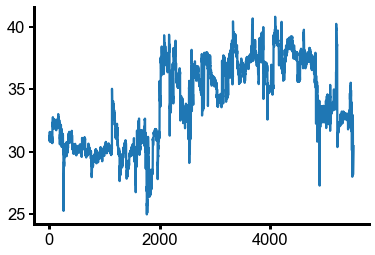

In [144]:
# plt.plot(phi-avgfm_phi)
plt.plot(model_phi-avgfm_phi)

In [7]:
fmimu_file = '/home/seuss/Goeppert/freely_moving_ephys/ephys_recordings/070921/J553RT/fm1/070921_J553RT_control_Rig2_fm1_imu.nc'
imu_data = xr.open_dataset(fmimu_file)
accT = imu_data.IMU_data.sample # imu timestamps
acc_chans = imu_data.IMU_data # imu dample data
# raw gyro values
gx = np.array(acc_chans.sel(channel='gyro_x_raw'))
gy = np.array(acc_chans.sel(channel='gyro_y_raw'))
gz = np.array(acc_chans.sel(channel='gyro_z_raw'))
# gyro values in degrees
gx_deg = np.array(acc_chans.sel(channel='gyro_x'))
gy_deg = np.array(acc_chans.sel(channel='gyro_y'))
gz_deg = np.array(acc_chans.sel(channel='gyro_z'))
# pitch and roll in deg
groll = np.array(acc_chans.sel(channel='roll'))
gpitch = np.array(acc_chans.sel(channel='pitch'))

eye_file = '/home/seuss/Goeppert/freely_moving_ephys/ephys_recordings/070921/J553RT/fm1/070921_J553RT_control_Rig2_fm1_REYE.nc'
eye_data = xr.open_dataset(eye_file)

eye_params = eye_data['REYE_ellipse_params']

th = np.array((eye_params.sel(ellipse_params = 'theta'))*180/3.14159)#-np.nanmean(eye_params.sel(ellipse_params = 'theta')))*180/3.14159)
phi = np.array((eye_params.sel(ellipse_params = 'phi'))*180/3.14159)#-np.nanmean(eye_params.sel(ellipse_params = 'phi')))*180/3.14159)
fm_eye = {'avg_th': np.nanmean(th),'avg_phi': np.nanmean(phi)}
ioh5.save(save_dir/'FM_AvgEye_dt{:03d}.h5'.format(int(model_dt*1000)),fm_eye)

In [6]:
avgfm_th = np.nanmean(th)
avgfm_phi = np.nanmean(phi)
avgfm_th,avgfm_phi

(21.277124235047108, -33.49597244540462)

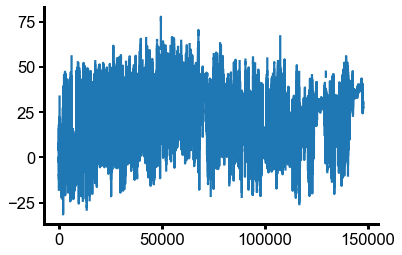

In [116]:
plt.plot(th)

In [117]:
np.nanmean(th), np.nanmean(phi)

(21.277124235047108, -33.49597244540462)

In [21]:
reg_alph=a=0; l=7
save_model_fm = Path('/home/seuss/Research/SensoryMotorPred_Data/data/070921/J553RT/fm1/models')
model_move = np.hstack((model_th[:, np.newaxis]-fm_eye['avg_th'], model_phi[:, np.newaxis]-fm_eye['avg_phi'],np.zeros(model_th.shape)[:, np.newaxis], (np.mean(gpitch[14000:])*np.ones(model_th.shape))[:, np.newaxis]))
l1 = PoissonGLM_VM_staticreg_shifter(input_size,output_size,reg_lam=None,reg_alph=reg_alph,move_features=move_features,meanfr=meanbias,init_sta=sta_init,device=device).to(device)
model_name = 'GLMShifter_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_alph{}_lam{}.pth'.format(WC_type,int(model_dt*1000), 1, 1, Nbatches,a,l)
# model_name = 'GLMShifter_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_pretrain_xyz.pth'.format(WC_type,int(model_dt*1000), nt_glm_lag, MovModel, Nbatches)
checkpoint = torch.load(save_model_fm/model_name)
l1.load_state_dict(checkpoint['model_state_dict'])
shift_out = l1.shifter_nn(torch.from_numpy(model_move[:,(0,1,3)].astype(np.float32)).to(device))
shift = Affine(angle=shift_out[:,-1],translation=shift_out[:,:2])
model_vid_sm_shift = shift(torch.from_numpy(model_vid_sm[:,np.newaxis].astype(np.float32)).to(device)).detach().cpu().numpy().squeeze()


(0.6170986391019848, -41.14117689140742)

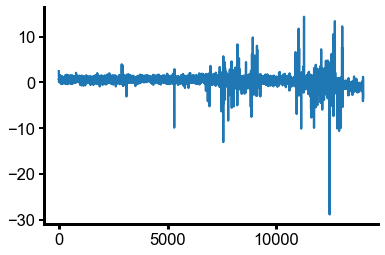

In [8]:
plt.plot(gpitch[:14000])
np.mean(gpitch[:10000]),np.mean(gpitch[14000:])

In [47]:
model_vid_sm_shift2 = {'model_vid_sm_shift{}'.format(0):model_vid_sm_shift}
MovModel

1

In [48]:
ioh5.save(save_dir/'ModelWC_shifted_dt{:03d}_MovModel{:d}.h5'.format(int(model_dt*1000), MovModel),model_vid_sm_shift2)

In [93]:
reg_alph=a=0; l=7
l1 = PoissonGLM_VM_staticreg_shifter(input_size,output_size,reg_lam=None,reg_alph=reg_alph,move_features=move_features,meanfr=meanbias,init_sta=sta_init,device=device).to(device)
model_name = 'GLMShifter_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_alph{}_lam{}.pth'.format(WC_type,int(model_dt*1000), nt_glm_lag, MovModel, Nbatches,a,l)
# model_name = 'GLMShifter_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_pretrain_xyz.pth'.format(WC_type,int(model_dt*1000), nt_glm_lag, MovModel, Nbatches)
checkpoint = torch.load(save_model_fm/model_name)
l1.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [21]:
l1 = PoissonGLM_VM_staticreg_shifter(input_size,output_size,reg_lam=None,reg_alph=reg_alph,move_features=move_features,meanfr=meanbias,init_sta=sta_init,device=device).to(device)
shift_out = l1.shifter_nn(shift_in_tr).detach().cpu()
shift = Affine(angle=shift_out[:,-1],translation=shift_out[:,:2])
xtr_shift = shift(xtr.detach().cpu()).numpy()

# shift_out = l1.shifter_nn(shift_in_te).detach().cpu()
# shift = Affine(angle=shift_out[:,-1],translation=shift_out[:,:2])
# xte_shift = shift(xte.detach().cpu()).numpy()

In [22]:
np.corrcoef(move_train[:,0],shift_out[:,0])[0,1],np.corrcoef(move_train[:,1],shift_out[:,1])[0,1],np.corrcoef(move_train[:,3],shift_out[:,2])[0,1]

/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


(0.8376311398656168, -0.46730649183137296, nan)

In [ ]:
# plt.plot(model_move[0:100,0]/np.max(model_move[:,0]))
# plt.plot(shift_out[:100,1]/torch.max(shift_out[:,1]))
plt.plot((shift_out[0:1000,0]))#/torch.max(shift_out[:,0])).detach().cpu())

torch.max(shift_out)

In [87]:
save_dir_fm = Path('/home/seuss/Research/SensoryMotorPred_Data/data/070921/J553RT/fm1/')
fm_eye = ioh5.load(save_dir_fm/'FM_AvgEye_dt{:03d}.h5'.format(int(model_dt*1000)))

/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


## Shifter Animation

In [27]:
@ray.remote
def make_plt_im(t, model_vid_sm, model_vid_sm_shift, pbar: ActorHandle,):  #
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    axs[0].imshow(model_vid_sm[t], cmap='gray')
    axs[0].set_title('Uncorrected, Frame={}'.format(t))
    axs[1].imshow(model_vid_sm_shift[t], cmap='gray')
    axs[1].set_title('Corrected, Frame={}'.format(t))
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()

    width, height = fig.get_size_inches() * fig.get_dpi()
    fig.canvas.draw()       # draw the canvas, cache the renderer
    images = np.frombuffer(fig.canvas.tostring_rgb(),
                        dtype='uint8').reshape(int(height), int(width), 3)
    
    plt.close()
    pbar.update.remote(1)
    return images


In [28]:
mpl.use('agg')

start = time.time()
##### initialize time points for animation and progressbar #####
t = 0
time_range = np.arange(10000)# model_vid_sm_shift.shape[0])
num_ticks = np.size(time_range)
pb = ProgressBar(num_ticks)
actor = pb.actor

##### Put large arrays into shared memory #####
model_vid_sm_shfit_r = ray.put(model_vid_sm_shift)
model_vid_sm_r = ray.put(model_vid_sm)

##### Loop over parameters appending process ids #####
result_ids = []
for t in time_range:
    result_ids.append(make_plt_im.remote(t, model_vid_sm_r, model_vid_sm_shfit_r, actor))

##### pring progressbar and get results #####
pb.print_until_done()
results_p = ray.get(result_ids)
images = np.stack([results_p[i] for i in range(len(results_p))])

##### Make video with opencv #####
aniname = file_dict['name'] + '_WorldCamCorrection.mp4'
vid_name = FigPath / aniname
FPS = int(1/model_dt)
out = cv2.VideoWriter(vid_name.as_posix(), cv2.VideoWriter_fourcc(*'mp4v'), FPS, (images.shape[-2], images.shape[-3]))

for fm in tqdm(range(images.shape[0])):
    out.write(cv2.cvtColor(images[fm], cv2.COLOR_BGR2RGB))
out.release()
print('Making Animation {}: {}'.format(aniname, time.time()-start))
del results_p, pb, model_vid_sm_r, model_vid_sm_shfit_r
gc.collect()


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Making Animation 070921_J553RT_control_Rig2_fm1WorldCamCorrection.mp4: 125.76748418807983


4806

## Save HF Shifter WC Videos

In [30]:
reg_alph=a=0; l=7
save_model_fm = Path('/home/seuss/Research/SensoryMotorPred_Data/data/070921/J553RT/fm1/models')
model_move = np.hstack((model_th[:, np.newaxis]-fm_eye['avg_th'], model_phi[:, np.newaxis]-fm_eye['avg_phi'],np.zeros(model_th.shape)[:, np.newaxis], (np.mean(gpitch[14000:])*np.ones(model_th.shape))[:, np.newaxis]))
l1 = PoissonGLM_VM_staticreg_shifter(input_size,output_size,reg_lam=None,reg_alph=reg_alph,move_features=move_features,meanfr=meanbias,init_sta=sta_init,device=device).to(device)
model_name = 'GLMShifter_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_alph{}_lam{}.pth'.format(WC_type,int(model_dt*1000), 1, 1, Nbatches,a,l)
# model_name = 'GLMShifter_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_pretrain_xyz.pth'.format(WC_type,int(model_dt*1000), nt_glm_lag, MovModel, Nbatches)
checkpoint = torch.load(save_model_fm/model_name)
l1.load_state_dict(checkpoint['model_state_dict'])
shift_out = l1.shifter_nn(torch.from_numpy(model_move[:,(0,1,3)].astype(np.float32)).to(device))
shift = Affine(angle=shift_out[:,-1],translation=shift_out[:,:2])
model_vid_sm_shift = shift(torch.from_numpy(model_vid_sm[:,np.newaxis].astype(np.float32)).to(device)).detach().cpu().numpy().squeeze()
model_vid_sm_shift2 = {'model_vid_sm_shift0':model_vid_sm_shift}
ioh5.save(save_dir/'ModelWC_shifted_dt{:03d}_MovModel{:d}.h5'.format(int(model_dt*1000), 1),model_vid_sm_shift2)

In [25]:
l=7
model_vid_sm_shift = model_vid_sm_shift2['model_vid_sm_shift{}'.format(l)] 

tensor([1.0571, 1.8460, 1.9445], device='cuda:0', grad_fn=<SelectBackward>)


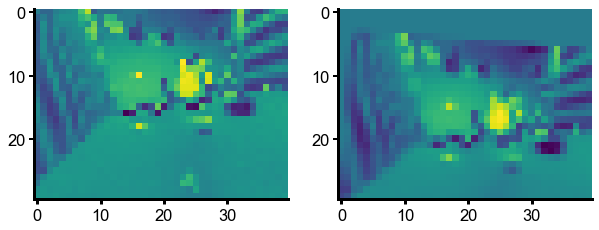

In [26]:
t = 1000
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(model_vid_sm[t])

ax[1].imshow(model_vid_sm_shift[t])
print(shift_out[t])

  0%|          | 0/6 [00:00<?, ?it/s]

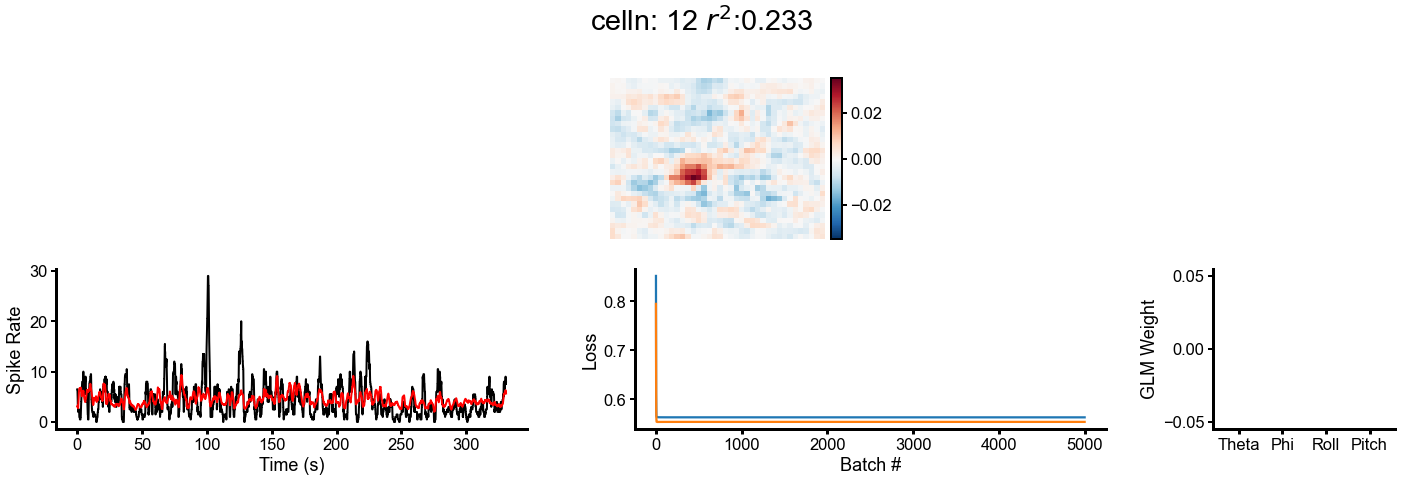

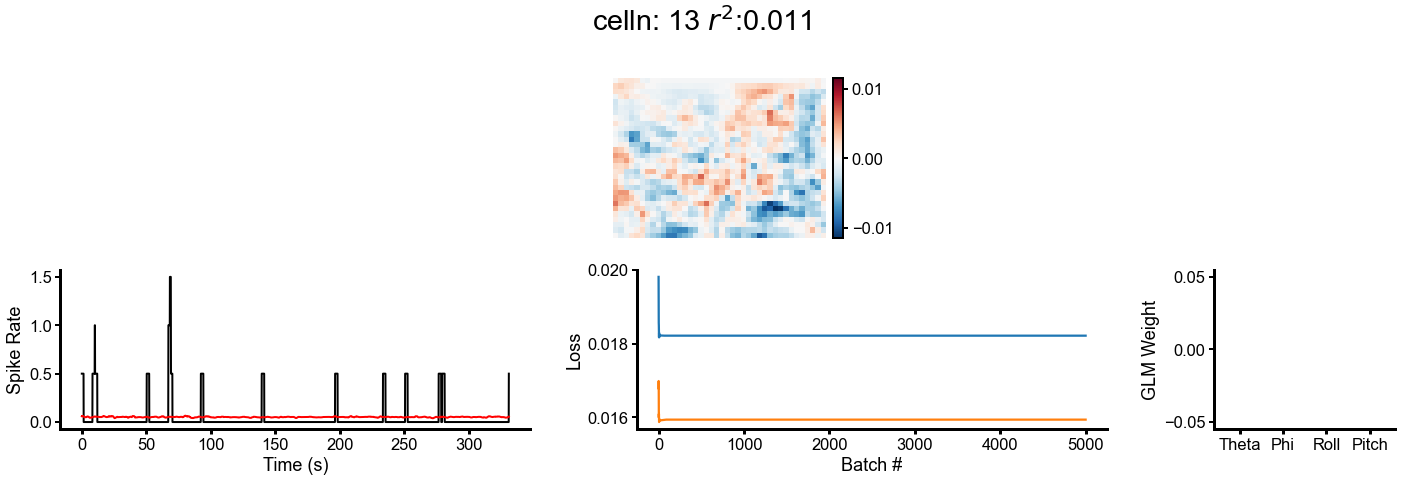

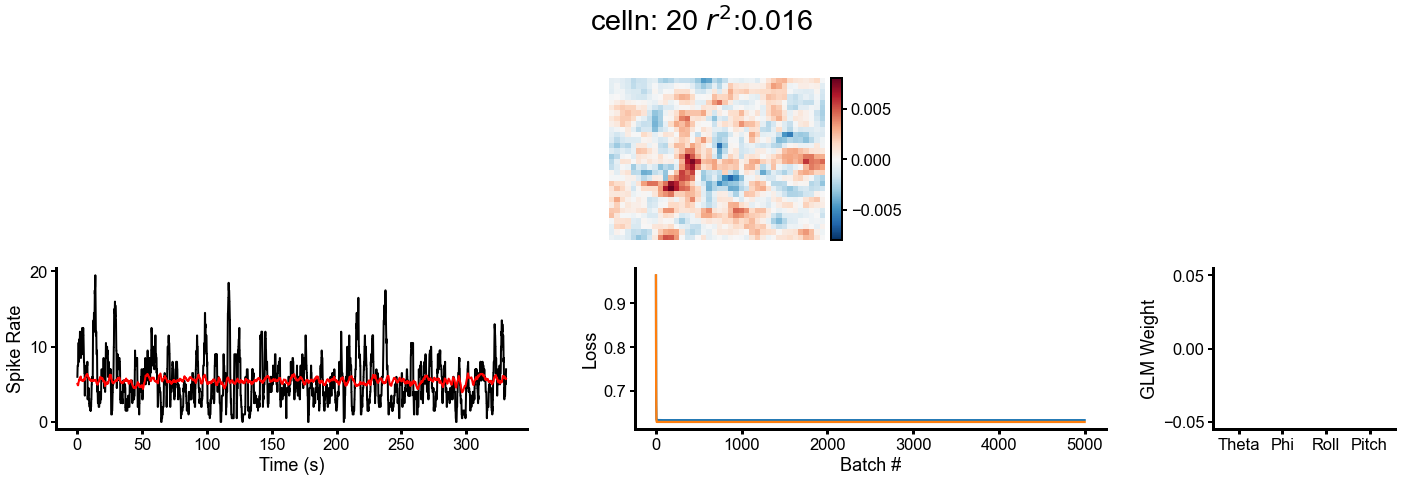

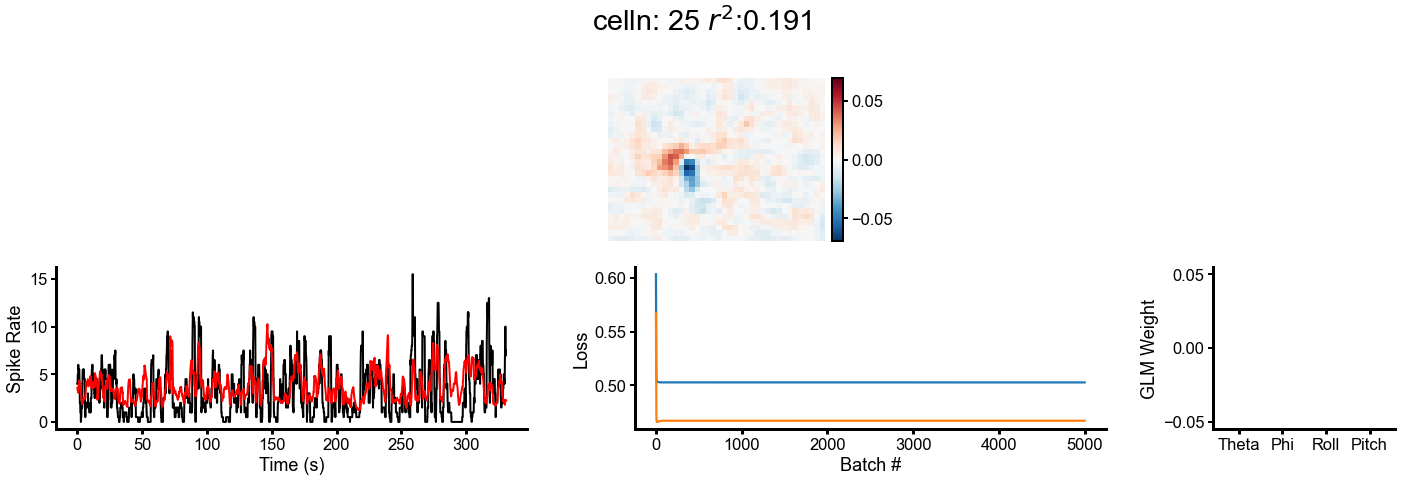

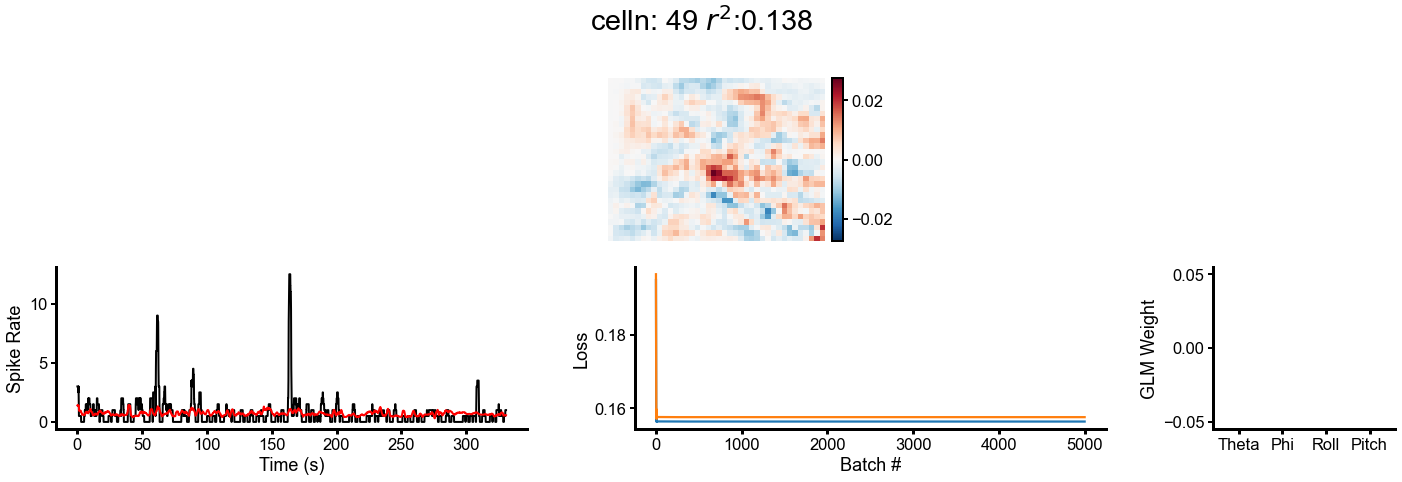

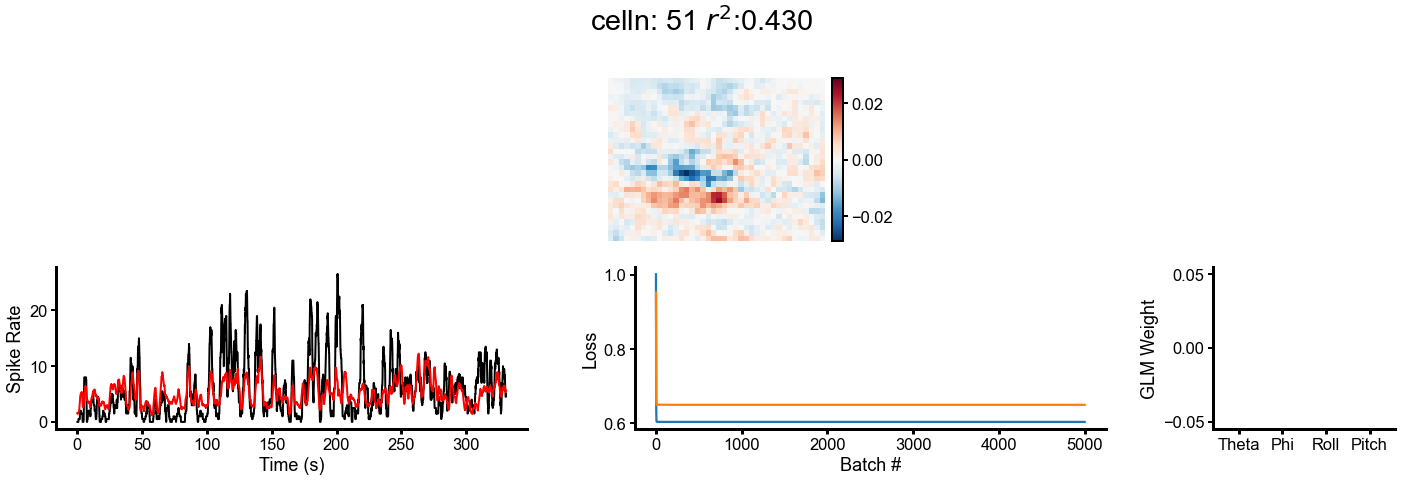

In [48]:

celln = 49 # np.argmax(r2_all)
bin_length = 40
ncells = model_nsp.shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
quartiles = np.arange(0,1.25,.25)
bin_length=40
alph = 0#malph[celln]
lam = 0# mlam[celln]
for n, celln in enumerate(tqdm([12,13,20,25,49,51])):
    fig2 = plt.figure(constrained_layout=False, figsize=(20,7))
    spec2 = gridspec.GridSpec(ncols=5, nrows=2, figure=fig2)
    axs = np.array([fig2.add_subplot(spec2[0, :])])
    # axs = np.array([fig2.add_subplot(spec2[0, n]) for n in range(nt_glm_lag)])
    f2_ax6 = fig2.add_subplot(spec2[1, :5//2])
    f2_ax7 = fig2.add_subplot(spec2[1, (5//2):-1])
    f2_ax8 = fig2.add_subplot(spec2[1,-1])
    if MovModel != 0:
        crange = np.max(np.abs(sta_all[celln]))
        for m,ax in enumerate(axs):
            im = ax.imshow(sta_all[celln,m],'RdBu_r',vmin=-crange,vmax=crange)
            cbar = add_colorbar(im)
            ax.axis('off')

    sp_smooth = ((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    f2_ax6.plot(np.arange(len(sp_smooth))*model_dt,sp_smooth, 'k', lw=2)
    pred_smooth = ((np.convolve(pred_all[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    f2_ax6.plot(np.arange(len(pred_smooth))*model_dt,pred_smooth,'r', lw=2)
    f2_ax6.set_xlabel('Time (s)')
    f2_ax6.set_ylabel('Spike Rate')
    f2_ax7.plot(tloss_trace_all[alph,lam,:,celln])
    f2_ax7.plot(vloss_trace_all[alph,lam,:,celln])
    f2_ax7.set_xlabel('Batch #')
    f2_ax7.set_ylabel('Loss')
    r2 = (np.corrcoef(sp_smooth,pred_smooth)[0,1])**2
    
    if MovModel == 1:
        w_move = np.zeros((model_nsp.shape[-1],len(titles)))
    elif MovModel == 3:
        Msta = w_move[:,:-len(titles)].reshape((model_nsp.shape[-1],nt_glm_lag,len(titles))+nks)
        w_move = w_move[:,-len(titles):]
    for modeln in range(len(titles)):
        f2_ax8.bar(modeln, w_move[celln,modeln], color=clrs[modeln])
        f2_ax8.set_xticks(np.arange(0,len(titles)))
        f2_ax8.set_xticklabels(titles)
        f2_ax8.set_ylabel('GLM Weight')
    
    plt.suptitle('celln: {} $r^2$:{:.03f}'.format(celln, r2))
    plt.tight_layout()


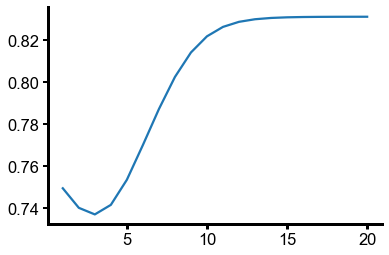

In [86]:
plt.plot(msetest[0,:,25])

In [87]:
mlam

array([20, 20, 20,  7, 11, 20, 20,  4, 10,  8,  8,  7, 20, 20, 13,  8,  7,
        8,  9, 20, 20,  4,  7, 20, 20,  3, 10, 20,  6,  5, 20, 20, 20, 20,
       20, 20, 20, 20, 20,  8, 20,  5,  7, 20, 20,  8, 20, 20,  9,  5, 20,
       20, 13,  6, 20, 20,  7, 20, 20, 20, 20, 20, 20,  4, 20,  8,  5,  8,
        7,  4,  3, 20,  5,  7,  2, 20, 20,  2,  4, 10,  6,  5,  8,  7,  9,
       20, 10, 20, 20,  5,  6, 19, 20,  5,  7, 20,  3, 20, 20, 20, 20, 20,
        6, 20, 20,  5, 20, 20, 20, 20,  3, 11,  6,  8, 20,  4,  6, 10, 20,
        8, 20, 20,  8, 20, 20, 10, 20, 20])

In [20]:

malph,mlam,cellnum  = np.where(msetest==np.nanmin(msetest,axis=(0,1), keepdims=True))
cellnum, m_cinds = np.unique(cellnum,return_index=True)
malph = malph[m_cinds]
mlam = mlam[m_cinds]
sortinds = cellnum.argsort()
cellnum = cellnum[sortinds]
malph = malph[sortinds]
mlam = mlam[sortinds]
sta_all = w_cv[:,malph,mlam,cellnum].T.reshape((len(cellnum),nt_glm_lag,)+nks)
pred_all = pred_cv[:,malph,mlam,cellnum]
bias_all = bias_cv[malph,mlam,cellnum]
tloss_trace_all2 = tloss_trace_all[malph,mlam,:,cellnum]
vloss_trace_all2 = vloss_trace_all[malph,mlam,:,cellnum]
# w_move_traces = w_move_traces_all[malph, mlam, :, cellnum]
bias_traces = bias_traces_all[malph, mlam, :, cellnum]

output_size = len(cellnum)
if MovModel != 1:
    w_move = w_move_cv[malph,mlam,cellnum]

bin_length=40
r2_all = np.zeros((output_size))
for celln in range(output_size):
    sp_smooth = ((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    pred_smooth = ((np.convolve(pred_all[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    r2_all[celln] = (np.corrcoef(sp_smooth,pred_smooth)[0,1])**2


In [23]:

if MovModel == 0:
    GLM_Data = {'r2_all': r2_all,
                'test_nsp': test_nsp,
                'pred_all': pred_all,
                'bias_all': bias_all, 
                'tloss_trace_all':tloss_trace_all2,
                'vloss_trace_all':vloss_trace_all2,
                'w_move': w_move}
elif MovModel == 1:
    GLM_Data = {'r2_all': r2_all,
                'sta_all': sta_all,
                'test_nsp': test_nsp,
                'pred_all': pred_all,
                'bias_all': bias_all,
                'tloss_trace_all':tloss_trace_all2,
                'vloss_trace_all':vloss_trace_all2,
               }
else:
    GLM_Data = {'r2_all': r2_all,
                'sta_all': sta_all,
                'test_nsp': test_nsp,
                'pred_all': pred_all,
                'bias_all': bias_all,
                'tloss_trace_all':tloss_trace_all2,
                'vloss_trace_all':vloss_trace_all2,
                'w_move': w_move}

if do_shuffle:
    save_datafile = save_dir/'GLMShifter_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_shuffled.h5'.format(model_type,int(model_dt*1000), nt_glm_lag, MovModel)
else:
    save_datafile = save_dir/'GLMShifter_WC{}_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}.h5'.format(WC_type, model_type,int(model_dt*1000), nt_glm_lag, MovModel)
ioh5.save(save_datafile, GLM_Data)
print(save_datafile)

/home/seuss/Research/SensoryMotorPred_Data/data/110421/J569LT/fm1/GLMShifter_WCUC_Pytorch_Data_VisMov_dt050_T01_MovModel1.h5


In [28]:
save_datafile = save_dir/'GLMShifter_WC{}_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}.h5'.format(WC_type, model_type,int(model_dt*1000), nt_glm_lag, MovModel)
GLM_shifter = ioh5.load(save_datafile)
locals().update(GLM_shifter)

# VisMov Poisson GLM

In [6]:
lag_list = np.array([-2,-1,0,1,2])
nt_glm_lag = len(lag_list)
print(lag_list,1000*lag_list*model_dt)
do_shuffle = False
# LinNetwork = False
GLM_All_Data={}
for LinNetwork in [True,False]:
    for MovModel in [1,2]:
        if LinNetwork:
            model_type = 'Pytorch_Lin'
        else: 
            model_type = 'Pytorch_Nonlin'
        # Load Data
        data, train_idx, test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=do_shuffle, do_norm=False,free_move=free_move, has_imu=free_move, has_mouse=False,do_worldcam_correction=do_worldcam_correction)
        locals().update(data)

        Nbatches = 5000

        # Initialize movement combinations
        titles = np.array(['Theta','Phi','Roll','Pitch']) # 'dg_p','dg_n' 'roll','pitch'
        titles_all = []
        for n in range(1,len(titles)+1):
            perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
            for ind in range(perms.shape[0]):
                titles_all.append('_'.join([t for t in titles[perms[ind]]]))
        if free_move:
            move_train = np.hstack((train_th[:,np.newaxis],train_phi[:,np.newaxis],train_roll[:,np.newaxis],medfilt(train_pitch,3)[:,np.newaxis]))
            move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_roll[:,np.newaxis],medfilt(test_pitch,3)[:,np.newaxis])) 
            model_move = np.hstack((model_th[:, np.newaxis], model_phi[:, np.newaxis],model_roll[:, np.newaxis], medfilt(model_pitch, 3)[:, np.newaxis]))
            shift_in_tr = torch.from_numpy(move_train[:,(0,1,3)].astype(np.float32)).to(device)
            shift_in_te = torch.from_numpy(move_test[:,(0,1,3)].astype(np.float32)).to(device)
            # model_move = model_move - np.mean(model_move,axis=0)
            # move_test = move_test - np.mean(move_test,axis=0)
            # move_train = move_train - np.mean(move_train,axis=0)
        else:
            move_train = np.hstack((train_th[:,np.newaxis],train_phi[:,np.newaxis],np.zeros(train_phi.shape)[:,np.newaxis],np.zeros(train_phi.shape)[:,np.newaxis]))
            move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],np.zeros(test_phi.shape)[:,np.newaxis],np.zeros(test_phi.shape)[:,np.newaxis]))
            model_move = np.hstack((model_th[:, np.newaxis], model_phi[:, np.newaxis],np.zeros(model_phi.shape)[:, np.newaxis], np.zeros(model_phi.shape)[:,np.newaxis]))
            shift_in_tr = torch.from_numpy(move_train[:,(0,1,3)].astype(np.float32)).to(device)
            shift_in_te = torch.from_numpy(move_test[:,(0,1,3)].astype(np.float32)).to(device)

        ##### Start GLM Parallel Processing #####
        nks = np.shape(train_vid)[1:]; nk = nks[0]*nks[1]*nt_glm_lag
        n=4; ind=0
        perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
        ##### Start GLM Parallel Processing #####
        # Reshape data (video) into (T*n)xN array
        if do_worldcam_correction:
            rolled_vid = np.hstack([np.roll(model_vid_sm, nframes, axis=0) for nframes in lag_list]) # nt_glm_lag
        else:
            shiftn = 7
            model_vid_sm_shift = ioh5.load(save_dir/'ModelWC_shifted_dt{:03d}_MovModel{:d}.h5'.format(int(model_dt*1000), 1))['model_vid_sm_shift{}'.format(shiftn)]#[:,5:-5,5:-5]
            nks = np.shape(model_vid_sm_shift)[1:]; nk = nks[0]*nks[1]*nt_glm_lag
            rolled_vid = np.hstack([np.roll(model_vid_sm_shift, nframes, axis=0) for nframes in lag_list]) # nt_glm_lag
        rolled_vid_flat = rolled_vid.reshape(rolled_vid.shape[0],-1)
        x_train = rolled_vid[train_idx].reshape(len(train_idx),-1)
        x_test = rolled_vid[test_idx].reshape(len(test_idx),-1)

        ytr = torch.from_numpy(train_nsp.astype(np.float32)).to(device)
        yte = torch.from_numpy(test_nsp.astype(np.float32)).to(device)

        input_size = nk 
        output_size = ytr.shape[1]

        # MovModel = 2
        # Reshape data (video) into (T*n)xN array
        if MovModel == 0:
            mx_train = move_train[:,perms[ind]]
            mx_test = move_test[:,perms[ind]]
            xtr = torch.from_numpy(mx_train.astype(np.float32)).to(device)
            xte = torch.from_numpy(mx_test.astype(np.float32)).to(device)    
            move_features = None # mx_train.shape[-1]
            nk = 0
            xtrm = None
            xtem = None
            sta_init = None
            lambdas = [0] #(2**(np.arange(0,10)))
            nlam = len(lambdas)
            alphas = [None] #np.array([.005,.01,.02]) #np.arange(.01,.5,.05)
            nalph = len(alphas)
            w_move_traces_all = np.zeros((nalph, nlam, Nbatches, output_size, input_size))
        elif MovModel == 1:
            x_train_m1 = (rolled_vid[train_idx].reshape(len(train_idx),-1)).astype(np.float32) # 
            x_test_m1 = (rolled_vid[test_idx].reshape(len(test_idx),-1)).astype(np.float32) # 
            xtr = torch.from_numpy(x_train_m1).to(device)
            xte = torch.from_numpy(x_test_m1).to(device)
            move_features = None
            xtrm = None
            xtem = None
            lambdas = np.hstack((np.logspace(-3,3.25, 10)[0],np.logspace(-2,3.25, 20))) #np.hstack((np.logspace(-2,3, 10)[0],np.logspace(-2,3, 10)))
            nlam = len(lambdas)
            alphas = np.array([None]) # .01]) 
            nalph = len(alphas)
            sta_init = torch.zeros((output_size,xtr.shape[-1]))
        elif MovModel == 2:
            xtrm = torch.from_numpy(move_train[:,perms[ind]].astype(np.float32)).to(device)
            xtem = torch.from_numpy(move_test[:,perms[ind]].astype(np.float32)).to(device)
            xtr = torch.from_numpy(x_train.astype(np.float32)).to(device)
            xte = torch.from_numpy(x_test.astype(np.float32)).to(device)
            move_features = xtrm.shape[-1]
            lambdas = np.hstack((np.logspace(-3,3.25, 10)[0],np.logspace(-2,3.25, 20)))
            lambdas_m = .0001*np.ones(len(lambdas)) #np.hstack((np.logspace(-2,3, 10)[0]/10,np.logspace(-2,3, 11)/10))
            nlam = len(lambdas)
            alphas = np.array([None])# np.array([.005]) 
            alphas_m = np.array([None])#.01])
            nalph = len(alphas)
            sta_init = torch.zeros((output_size,xtr.shape[-1]))
            w_move_cv = np.zeros((nalph,nlam,output_size,move_features))
            w_move_traces_all = np.zeros((nalph, nlam, Nbatches, output_size, move_features))

        
        if LinNetwork:
#             meanbias = torch.log(torch.exp(torch.mean(torch.tensor(model_nsp,dtype=torch.float32),axis=0))-1)
            meanbias = torch.mean(torch.tensor(model_nsp,dtype=torch.float32),axis=0)
        else:
            meanbias = torch.log(torch.mean(torch.tensor(model_nsp,dtype=torch.float32),axis=0))

        print('Model: {}, move_features: {}'.format(MovModel, move_features))

        msetrain = np.zeros((nalph,nlam,output_size))
        msetest = np.zeros((nalph,nlam,output_size))
        pred_cv = np.zeros((x_test.shape[0],nalph,nlam,output_size),dtype=np.float32)
        out_cv = np.zeros((x_train.shape[0],nalph,nlam,output_size),dtype=np.float32)
        w_cv = np.zeros((x_train.shape[-1],nalph,nlam,output_size),dtype=np.float32)
        bias_cv = np.zeros((nalph,nlam,output_size),dtype=np.float32)
        tloss_trace_all = np.zeros((nalph, nlam, Nbatches, output_size),dtype=np.float32)
        vloss_trace_all = np.zeros((nalph, nlam, Nbatches, output_size),dtype=np.float32)
        bias_traces_all = np.zeros((nalph, nlam, Nbatches, output_size),dtype=np.float32)

        lr_w = [1e-5, 1e-3]
        lr_b = [1e-5, 5e-3]
        lr_m = [1e-5, 1e-3]
        start = time.time()
        for a, reg_alph in enumerate(tqdm(alphas)):
            sta_init = torch.zeros((output_size,xtr.shape[-1]))
#             meanbias = torch.mean(torch.tensor(model_nsp,dtype=torch.float32),axis=0)
            pbar = tqdm(lambdas)
            for l, reg_lam in enumerate(pbar):
                if MovModel == 0: 
                    l1 = PoissonGLM_VM_staticreg(input_size,output_size,reg_lam=None,reg_alph=None,move_features=move_features,meanfr=meanbias,init_sta=sta_init,device=device,LinNetwork=LinNetwork).to(device)
                    optimizer = optim.Adam(params=[{'params': [l1.weight],'lr': 1e-3,},
                                                {'params': [l1.bias],'lr':lr_b[1]},], lr=5e-5) #
#                     scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=[lr_m[0],lr_b[0]], max_lr=[lr_m[1],lr_b[1]], cycle_momentum=False)
                    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=int(Nbatches/4))
                elif MovModel == 1:
                    l1 = PoissonGLM_VM_staticreg(input_size,output_size,reg_lam=None,reg_alph=reg_alph,move_features=move_features,meanfr=meanbias,init_sta=sta_init,device=device,LinNetwork=LinNetwork).to(device)
                    optimizer = optim.Adam(params=[{'params': [l1.weight],'lr':lr_w[1],'weight_decay':lambdas[l]},
                                                {'params': [l1.bias],'lr':lr_b[1]},], lr=5e-5) #
#                     scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=[lr_w[0],lr_b[0]], max_lr=[lr_w[1],lr_b[1]], cycle_momentum=False)
                    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=int(Nbatches/4))
                else:
                    l1 = PoissonGLM_VM_staticreg(input_size,output_size,reg_lam=None,reg_alph=reg_alph,reg_alphm=alphas_m[a],move_features=move_features,meanfr=meanbias,init_sta=sta_init,device=device,LinNetwork=LinNetwork).to(device)
                    optimizer = optim.Adam(params=[{'params': [l1.weight],'lr':lr_w[1],'weight_decay':lambdas[l]},
                                                   {'params': [l1.bias],'lr':lr_b[1]},
                                                   {'params': [l1.move_weights],'lr':lr_m[1], 'weight_decay': lambdas_m[l]},
                                                   {'params': [l1.bias_m],'lr':lr_b[1]},]) #
#                     scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=[lr_w[0],lr_b[0],lr_m[0]], max_lr=[lr_w[1],lr_b[1],lr_m[1]], step_size_up=int(Nbatches/4), cycle_momentum=False)
                    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=int(Nbatches/4))
                model_name = 'GLM_{}_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_alph{}_lam{}_fullim.pth'.format(model_type,WC_type,int(model_dt*1000), nt_glm_lag, MovModel, Nbatches,a,l)

                vloss_trace = np.zeros((Nbatches,output_size),dtype=np.float32)      
                tloss_trace = np.zeros((Nbatches,output_size),dtype=np.float32)
                for batchn in np.arange(Nbatches):
                    out = l1(xtr,xtrm)
                    loss = l1.loss(out,ytr)
                    pred = l1(xte,xtem)
                    val_loss = l1.loss(pred,yte)
                    vloss_trace[batchn] = val_loss.clone().cpu().detach().numpy()
                    tloss_trace[batchn] = loss.clone().cpu().detach().numpy()
                    bias_traces_all[a,l,batchn] = l1.bias.clone().cpu().detach().numpy()
                    pbar.set_description('Loss: {:.03f}'.format(np.mean(val_loss.clone().cpu().detach().numpy() )))
                    optimizer.zero_grad()
                    loss.backward(torch.ones_like(loss))
                    optimizer.step()
                    scheduler.step()
                tloss_trace_all[a,l] = tloss_trace
                vloss_trace_all[a,l] = vloss_trace
                bias_cv[a,l] = l1.bias.clone().cpu().detach().numpy()
                if MovModel != 0:
                    w_cv[:,a,l] = l1.weight.clone().cpu().detach().numpy().T #[:,:(nk)]
                if MovModel == 0: 
                    w_move_cv[a,l] = l1.weight.clone().cpu().detach().numpy()#[:,(nk):]
                elif MovModel != 1:
                    w_move_cv[a,l] = l1.move_weights.clone().cpu().detach().numpy()#[:,(nk):]
                pred =  l1(xte,xtem)
                msetest[a,l] = l1.loss(pred,yte).cpu().detach().numpy()

                pred_cv[:,a,l] = pred.detach().cpu().numpy().squeeze()
                out = l1(xtr,xtrm)
                out_cv[:,a,l] = out.detach().cpu().numpy().squeeze()

                if (a==0) & (l==0):
                    sta_init = l1.weight.clone().detach()                    


#                 torch.save({
#                     'reg_alph': reg_alph,
#                     'reg_lam': reg_lam,
#                     'model_state_dict': l1.state_dict(),
#                     'optimizer_state_dict': optimizer.state_dict(),
#                     'loss': loss,
#                     }, save_model / model_name)
        print('GLM: ', time.time()-start)
        # pred_all = l1(xte).cpu().detach().numpy()
        if MovModel != 0:
            w_cv2 = w_cv.T.reshape((output_size,nlam,nalph,nt_glm_lag,)+nks)

        msetest[:,0,:] = np.nan
        malph,mlam,cellnum  = np.where(msetest==np.nanmin(msetest,axis=(0,1), keepdims=True))
        cellnum, m_cinds = np.unique(cellnum,return_index=True)
        malph = malph[m_cinds]
        mlam = mlam[m_cinds]
        sortinds = cellnum.argsort()
        cellnum = cellnum[sortinds]
        malph = malph[sortinds]
        mlam = mlam[sortinds]
        sta_all = w_cv[:,malph,mlam,cellnum].T.reshape((len(cellnum),nt_glm_lag,)+nks)
        pred_all = pred_cv[:,malph,mlam,cellnum]
        pred_train = out_cv[:,malph,mlam,cellnum]
        bias_all = bias_cv[malph,mlam,cellnum]
        tloss_trace_all2 = tloss_trace_all[malph,mlam,:,cellnum]
        vloss_trace_all2 = vloss_trace_all[malph,mlam,:,cellnum]
        # w_move_traces = w_move_traces_all[malph, mlam, :, cellnum]
        bias_traces = bias_traces_all[malph, mlam, :, cellnum]

        output_size = len(cellnum)
        if MovModel != 1:
            w_move = w_move_cv[malph,mlam,cellnum]

        bin_length=40
        r2_all = np.zeros((output_size))
        for celln in range(output_size):
            sp_smooth = ((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
            pred_smooth = ((np.convolve(pred_all[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
            r2_all[celln] = (np.corrcoef(sp_smooth,pred_smooth)[0,1])**2

        if MovModel == 0:
            GLM_Data = {'r2_all': r2_all,
                        'test_nsp': test_nsp,
                        'pred_all': pred_all,
                        'bias_all': bias_all, 
                        'tloss_trace_all':tloss_trace_all2,
                        'vloss_trace_all':vloss_trace_all2,
                        'msetest': msetest,
                        'pred_train': pred_train,
                        'w_move': w_move}
        elif MovModel == 1:
            GLM_Data = {'r2_all': r2_all,
                        'sta_all': sta_all,
                        'test_nsp': test_nsp,
                        'pred_all': pred_all,
                        'bias_all': bias_all,
                        'tloss_trace_all':tloss_trace_all2,
                        'vloss_trace_all':vloss_trace_all2,
                        'msetest': msetest,
                        'pred_train': pred_train,
                    }
        else:
            GLM_Data = {'r2_all': r2_all,
                        'sta_all': sta_all,
                        'test_nsp': test_nsp,
                        'pred_all': pred_all,
                        'bias_all': bias_all,
                        'tloss_trace_all':tloss_trace_all2,
                        'vloss_trace_all':vloss_trace_all2,
                        'msetest': msetest,
                        'pred_train': pred_train,
                        'w_move': w_move}
        GLM_All_Data[model_type+'_MovModel{}'.format(MovModel)] = GLM_Data
        if do_shuffle:
            save_datafile = save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_shuffled.h5'.format(model_type,int(model_dt*1000), nt_glm_lag, MovModel, Nbatches)
        else:
            save_datafile = save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag, MovModel, Nbatches)
        ioh5.save(save_datafile, GLM_Data)
        print(save_datafile)
save_datafile = save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format('Pytorch_AllData',int(model_dt*1000), nt_glm_lag, MovModel, Nbatches)
ioh5.save(save_datafile,GLM_All_Data)

[-2 -1  0  1  2] [-100.  -50.    0.   50.  100.]
Done Loading Unaligned data
TRAIN: 15628 TEST: 6698
Model: 1, move_features: None


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

GLM:  338.91832661628723


/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


/home/seuss/Research/SensoryMotorPred_Data/data/070921/J553RT/fm1/GLM_Pytorch_Lin_Data_VisMov_dt050_T05_MovModel1_NB5000.h5
Done Loading Unaligned data
TRAIN: 15628 TEST: 6698
Model: 2, move_features: 4


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

GLM:  406.9399518966675
/home/seuss/Research/SensoryMotorPred_Data/data/070921/J553RT/fm1/GLM_Pytorch_Lin_Data_VisMov_dt050_T05_MovModel2_NB5000.h5
Done Loading Unaligned data
TRAIN: 15628 TEST: 6698
Model: 1, move_features: None


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

GLM:  422.97564601898193
/home/seuss/Research/SensoryMotorPred_Data/data/070921/J553RT/fm1/GLM_Pytorch_Nonlin_Data_VisMov_dt050_T05_MovModel1_NB5000.h5
Done Loading Unaligned data
TRAIN: 15628 TEST: 6698
Model: 2, move_features: 4


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

GLM:  685.6179893016815
/home/seuss/Research/SensoryMotorPred_Data/data/070921/J553RT/fm1/GLM_Pytorch_Nonlin_Data_VisMov_dt050_T05_MovModel2_NB5000.h5


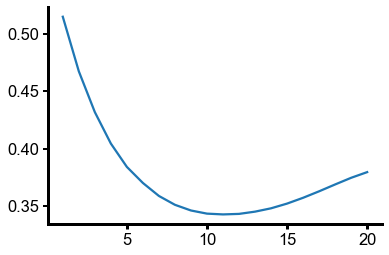

In [47]:
plt.plot(GLM_All_Data['Pytorch_Lin_MovModel1']['msetest'][0,:,51])

# Single Training

In [32]:
lag_list = np.array([-2,-1,0,1,2])
nt_glm_lag = len(lag_list)
print(lag_list,1000*lag_list*model_dt)
LinNetwork = False
if LinNetwork:
    model_type = 'Pytorch_Lin'
else: 
    model_type = 'Pytorch_Nonlin'
# Load Data
data, train_idx, test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=do_shuffle, do_norm=False,free_move=free_move, has_imu=free_move, has_mouse=False,do_worldcam_correction=do_worldcam_correction)
locals().update(data)

Nbatches = 5000

# Initialize movement combinations
titles = np.array(['Theta','Phi','Roll','Pitch']) # 'dg_p','dg_n' 'roll','pitch'
titles_all = []
for n in range(1,len(titles)+1):
    perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
    for ind in range(perms.shape[0]):
        titles_all.append('_'.join([t for t in titles[perms[ind]]]))
if free_move:
    move_train = np.hstack((train_th[:,np.newaxis],train_phi[:,np.newaxis],train_roll[:,np.newaxis],medfilt(train_pitch,3)[:,np.newaxis]))
    move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_roll[:,np.newaxis],medfilt(test_pitch,3)[:,np.newaxis])) 
    model_move = np.hstack((model_th[:, np.newaxis], model_phi[:, np.newaxis],model_roll[:, np.newaxis], medfilt(model_pitch, 3)[:, np.newaxis]))
    shift_in_tr = torch.from_numpy(move_train[:,(0,1,3)].astype(np.float32)).to(device)
    shift_in_te = torch.from_numpy(move_test[:,(0,1,3)].astype(np.float32)).to(device)
    # model_move = model_move - np.mean(model_move,axis=0)
    # move_test = move_test - np.mean(move_test,axis=0)
    # move_train = move_train - np.mean(move_train,axis=0)
else:
    move_train = np.hstack((train_th[:,np.newaxis],train_phi[:,np.newaxis],np.zeros(train_phi.shape)[:,np.newaxis],np.zeros(train_phi.shape)[:,np.newaxis]))
    move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],np.zeros(test_phi.shape)[:,np.newaxis],np.zeros(test_phi.shape)[:,np.newaxis]))
    model_move = np.hstack((model_th[:, np.newaxis], model_phi[:, np.newaxis],np.zeros(model_phi.shape)[:, np.newaxis], np.zeros(model_phi.shape)[:,np.newaxis]))
    shift_in_tr = torch.from_numpy(move_train[:,(0,1,3)].astype(np.float32)).to(device)
    shift_in_te = torch.from_numpy(move_test[:,(0,1,3)].astype(np.float32)).to(device)

##### Start GLM Parallel Processing #####
nks = np.shape(train_vid)[1:]; nk = nks[0]*nks[1]*nt_glm_lag
n=4; ind=0
perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
##### Start GLM Parallel Processing #####
# Reshape data (video) into (T*n)xN array
if do_worldcam_correction:
    rolled_vid = np.hstack([np.roll(model_vid_sm, nframes, axis=0) for nframes in lag_list]) # nt_glm_lag
else:
    shiftn = 0 # 7
    model_vid_sm_shift = ioh5.load(save_dir/'ModelWC_shifted_dt{:03d}_MovModel{:d}.h5'.format(int(model_dt*1000), 1))['model_vid_sm_shift{}'.format(shiftn)]#[:,5:-5,5:-5]
    nks = np.shape(model_vid_sm_shift)[1:]; nk = nks[0]*nks[1]*nt_glm_lag
    rolled_vid = np.hstack([np.roll(model_vid_sm_shift, nframes, axis=0) for nframes in lag_list]) # nt_glm_lag
rolled_vid_flat = rolled_vid.reshape(rolled_vid.shape[0],-1)
x_train = rolled_vid[train_idx].reshape(len(train_idx),-1)
x_test = rolled_vid[test_idx].reshape(len(test_idx),-1)

ytr = torch.from_numpy(train_nsp.astype(np.float32)).to(device)
yte = torch.from_numpy(test_nsp.astype(np.float32)).to(device)

input_size = nk 
output_size = ytr.shape[1]

MovModel = 1
# Reshape data (video) into (T*n)xN array
if MovModel == 0:
    mx_train = move_train[:,perms[ind]]
    mx_test = move_test[:,perms[ind]]
    xtr = torch.from_numpy(mx_train.astype(np.float32)).to(device)
    xte = torch.from_numpy(mx_test.astype(np.float32)).to(device)    
    move_features = None # mx_train.shape[-1]
    nk = 0
    xtrm = None
    xtem = None
    sta_init = None
    lambdas = [0] #(2**(np.arange(0,10)))
    nlam = len(lambdas)
    alphas = [None] #np.array([.005,.01,.02]) #np.arange(.01,.5,.05)
    nalph = len(alphas)
    w_move_traces_all = np.zeros((nalph, nlam, Nbatches, output_size, input_size))
elif MovModel == 1:
    x_train_m1 = (rolled_vid[train_idx].reshape(len(train_idx),-1)).astype(np.float32) # 
    x_test_m1 = (rolled_vid[test_idx].reshape(len(test_idx),-1)).astype(np.float32) # 
    xtr = torch.from_numpy(x_train_m1).to(device)
    xte = torch.from_numpy(x_test_m1).to(device)
    move_features = None
    xtrm = None
    xtem = None
    lambdas = np.hstack((np.logspace(-1,5, 10)[0],np.logspace(-1,5, 20))) #np.hstack((np.logspace(-2,3, 10)[0],np.logspace(-2,3, 10)))
    nlam = len(lambdas)
    alphas = np.array([.0075]) # .01]) 
    nalph = len(alphas)
    sta_init = torch.zeros((output_size,xtr.shape[-1]))
elif MovModel == 2:
    xtrm = torch.from_numpy(move_train[:,perms[ind]].astype(np.float32)).to(device)
    xtem = torch.from_numpy(move_test[:,perms[ind]].astype(np.float32)).to(device)
    xtr = torch.from_numpy(x_train.astype(np.float32)).to(device)
    xte = torch.from_numpy(x_test.astype(np.float32)).to(device)
    move_features = xtrm.shape[-1]
    lambdas = np.hstack((np.logspace(-3,3.25, 10)[0],np.logspace(-2,3.25, 20)))
    lambdas_m = .0001*np.ones(len(lambdas)) #np.hstack((np.logspace(-2,3, 10)[0]/10,np.logspace(-2,3, 11)/10))
    nlam = len(lambdas)
    alphas = np.array([None])# np.array([.005]) 
    alphas_m = np.array([None])#.01])
    nalph = len(alphas)
    sta_init = torch.zeros((output_size,xtr.shape[-1]))
    w_move_cv = np.zeros((nalph,nlam,output_size,move_features))
    w_move_traces_all = np.zeros((nalph, nlam, Nbatches, output_size, move_features))


if LinNetwork:
#             meanbias = torch.log(torch.exp(torch.mean(torch.tensor(model_nsp,dtype=torch.float32),axis=0))-1)
    meanbias = torch.mean(torch.tensor(model_nsp,dtype=torch.float32),axis=0)
else:
    meanbias = torch.log(torch.mean(torch.tensor(model_nsp,dtype=torch.float32),axis=0))

print('Model: {}, move_features: {}'.format(MovModel, move_features))

msetrain = np.zeros((nalph,nlam,output_size))
msetest = np.zeros((nalph,nlam,output_size))
pred_cv = np.zeros((x_test.shape[0],nalph,nlam,output_size),dtype=np.float32)
out_cv = np.zeros((x_train.shape[0],nalph,nlam,output_size),dtype=np.float32)
w_cv = np.zeros((x_train.shape[-1],nalph,nlam,output_size),dtype=np.float32)
bias_cv = np.zeros((nalph,nlam,output_size),dtype=np.float32)
tloss_trace_all = np.zeros((nalph, nlam, Nbatches, output_size),dtype=np.float32)
vloss_trace_all = np.zeros((nalph, nlam, Nbatches, output_size),dtype=np.float32)
bias_traces_all = np.zeros((nalph, nlam, Nbatches, output_size),dtype=np.float32)

lr_w = [1e-5, 1e-3]
lr_b = [1e-5, 5e-3]
lr_m = [1e-5, 1e-3]
start = time.time()
for a, reg_alph in enumerate(tqdm(alphas)):
    sta_init = torch.zeros((output_size,xtr.shape[-1]))
#             meanbias = torch.mean(torch.tensor(model_nsp,dtype=torch.float32),axis=0)
    pbar = tqdm(lambdas)
    for l, reg_lam in enumerate(pbar):
        if MovModel == 0: 
            l1 = PoissonGLM_VM_staticreg(input_size,output_size,reg_lam=None,reg_alph=None,move_features=move_features,meanfr=meanbias,init_sta=sta_init,device=device,LinNetwork=LinNetwork).to(device)
            optimizer = optim.Adam(params=[{'params': [l1.weight],'lr': 1e-3,},
                                        {'params': [l1.bias],'lr':lr_b[1]},], lr=5e-5) #
#                     scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=[lr_m[0],lr_b[0]], max_lr=[lr_m[1],lr_b[1]], cycle_momentum=False)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=int(Nbatches/4))
        elif MovModel == 1:
            l1 = PoissonGLM_VM_staticreg(input_size,output_size,reg_lam=None,reg_alph=reg_alph,move_features=move_features,meanfr=meanbias,init_sta=sta_init,device=device,LinNetwork=LinNetwork).to(device)
            optimizer = optim.Adam(params=[{'params': [l1.weight],'lr':lr_w[1],'weight_decay':lambdas[l]},
                                        {'params': [l1.bias],'lr':lr_b[1]},], lr=5e-5) #
#                     scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=[lr_w[0],lr_b[0]], max_lr=[lr_w[1],lr_b[1]], cycle_momentum=False)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=int(Nbatches/4))
        else:
            l1 = PoissonGLM_VM_staticreg(input_size,output_size,reg_lam=None,reg_alph=reg_alph,reg_alphm=alphas_m[a],move_features=move_features,meanfr=meanbias,init_sta=sta_init,device=device,LinNetwork=LinNetwork).to(device)
            optimizer = optim.Adam(params=[{'params': [l1.weight],'lr':lr_w[1],'weight_decay':lambdas[l]},
                                        {'params': [l1.bias],'lr':lr_b[1]},
                                        {'params': [l1.move_weights],'lr':1e-3, 'weight_decay': lambdas_m[l]}], lr=5e-5) #
#                     scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=[lr_w[0],lr_b[0],lr_m[0]], max_lr=[lr_w[1],lr_b[1],lr_m[1]], step_size_up=int(Nbatches/4), cycle_momentum=False)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=int(Nbatches/4))
        model_name = 'GLM_{}_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_alph{}_lam{}_fullim.pth'.format(model_type,WC_type,int(model_dt*1000), nt_glm_lag, MovModel, Nbatches,a,l)

        vloss_trace = np.zeros((Nbatches,output_size),dtype=np.float32)      
        tloss_trace = np.zeros((Nbatches,output_size),dtype=np.float32)
        for batchn in np.arange(Nbatches):
            out = l1(xtr,xtrm)
            loss = l1.loss(out,ytr)
            pred = l1(xte,xtem)
            val_loss = l1.loss(pred,yte)
            vloss_trace[batchn] = val_loss.clone().cpu().detach().numpy()
            tloss_trace[batchn] = loss.clone().cpu().detach().numpy()
            bias_traces_all[a,l,batchn] = l1.bias.clone().cpu().detach().numpy()
            pbar.set_description('Loss: {:.03f}'.format(np.mean(val_loss.clone().cpu().detach().numpy() )))
            optimizer.zero_grad()
            loss.backward(torch.ones_like(loss))
            optimizer.step()
            scheduler.step()
        tloss_trace_all[a,l] = tloss_trace
        vloss_trace_all[a,l] = vloss_trace
        bias_cv[a,l] = l1.bias.clone().cpu().detach().numpy()
        if MovModel != 0:
            w_cv[:,a,l] = l1.weight.clone().cpu().detach().numpy().T #[:,:(nk)]
        if MovModel == 0: 
            w_move_cv[a,l] = l1.weight.clone().cpu().detach().numpy()#[:,(nk):]
        elif MovModel != 1:
            w_move_cv[a,l] = l1.move_weights.clone().cpu().detach().numpy()#[:,(nk):]
        pred =  l1(xte,xtem)
        msetest[a,l] = l1.loss(pred,yte).cpu().detach().numpy()

        pred_cv[:,a,l] = pred.detach().cpu().numpy().squeeze()
        out = l1(xtr,xtrm)
        out_cv[:,a,l] = out.detach().cpu().numpy().squeeze()

        if (a==0) & (l==0):
            sta_init = l1.weight.clone().detach()                    


#                 torch.save({
#                     'reg_alph': reg_alph,
#                     'reg_lam': reg_lam,
#                     'model_state_dict': l1.state_dict(),
#                     'optimizer_state_dict': optimizer.state_dict(),
#                     'loss': loss,
#                     }, save_model / model_name)
print('GLM: ', time.time()-start)
# pred_all = l1(xte).cpu().detach().numpy()
if MovModel != 0:
    w_cv2 = w_cv.T.reshape((output_size,nlam,nalph,nt_glm_lag,)+nks)

msetest[:,0,:] = np.nan
malph,mlam,cellnum  = np.where(msetest==np.nanmin(msetest,axis=(0,1), keepdims=True))
cellnum, m_cinds = np.unique(cellnum,return_index=True)
malph = malph[m_cinds]
mlam = mlam[m_cinds]
sortinds = cellnum.argsort()
cellnum = cellnum[sortinds]
malph = malph[sortinds]
mlam = mlam[sortinds]
sta_all = w_cv[:,malph,mlam,cellnum].T.reshape((len(cellnum),nt_glm_lag,)+nks)
pred_all = pred_cv[:,malph,mlam,cellnum]
bias_all = bias_cv[malph,mlam,cellnum]
tloss_trace_all2 = tloss_trace_all[malph,mlam,:,cellnum]
vloss_trace_all2 = vloss_trace_all[malph,mlam,:,cellnum]
# w_move_traces = w_move_traces_all[malph, mlam, :, cellnum]
bias_traces = bias_traces_all[malph, mlam, :, cellnum]
pred_train = out_cv[:,malph,mlam,cellnum]
output_size = len(cellnum)
if MovModel != 1:
    w_move = w_move_cv[malph,mlam,cellnum]

bin_length=40
r2_all = np.zeros((output_size))
for celln in range(output_size):
    sp_smooth = ((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    pred_smooth = ((np.convolve(pred_all[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    r2_all[celln] = (np.corrcoef(sp_smooth,pred_smooth)[0,1])**2
    
if MovModel == 0:
    GLM_Data = {'r2_all': r2_all,
                'test_nsp': test_nsp,
                'pred_all': pred_all,
                'bias_all': bias_all, 
                'tloss_trace_all':tloss_trace_all2,
                'vloss_trace_all':vloss_trace_all2,
                'msetest': msetest,
                'pred_train': pred_train,
                'w_move': w_move}
elif MovModel == 1:
    GLM_Data = {'r2_all': r2_all,
                'sta_all': sta_all,
                'test_nsp': test_nsp,
                'pred_all': pred_all,
                'bias_all': bias_all,
                'tloss_trace_all':tloss_trace_all2,
                'vloss_trace_all':vloss_trace_all2,
                'msetest': msetest,
                'pred_train': pred_train,
            }
else:
    GLM_Data = {'r2_all': r2_all,
                'sta_all': sta_all,
                'test_nsp': test_nsp,
                'pred_all': pred_all,
                'bias_all': bias_all,
                'tloss_trace_all':tloss_trace_all2,
                'vloss_trace_all':vloss_trace_all2,
                'msetest': msetest,
                'pred_train': pred_train,
                'w_move': w_move}
# GLM_All_Data[model_type+'_MovModel{}'.format(MovModel)] = GLM_Data
if do_shuffle:
    save_datafile = save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_shuffled.h5'.format(model_type,int(model_dt*1000), nt_glm_lag, MovModel, Nbatches)
else:
    save_datafile = save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag, MovModel, Nbatches)
ioh5.save(save_datafile, GLM_Data)
print(save_datafile)

[-2 -1  0  1  2] [-100.  -50.    0.   50.  100.]
Done Loading Unaligned data
TRAIN: 3853 TEST: 1652


/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/format_data.py:620: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


Model: 1, move_features: None


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

GLM:  534.8786292076111
/home/seuss/Research/SensoryMotorPred_Data/data/070921/J553RT/hf1_wn/GLM_Pytorch_Nonlin_Data_VisMov_dt050_T05_MovModel1_NB5000.h5


In [33]:
malph,mlam

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([20, 20, 20,  7, 11, 20, 20,  3, 11,  8,  8,  7, 20, 20, 11,  8,  7,
         7,  8, 20, 20,  4,  7,  9, 20,  2,  9, 20,  5,  5, 20, 20, 20,  8,
        20, 20, 20, 20, 19,  8, 20,  2,  7, 20, 20,  9, 20, 20,  8,  4, 20,
        20, 11,  5, 20, 20,  5, 20, 20, 20, 20, 20, 20,  3, 20,  5,  5,  8,
         6,  3,  1, 20,  4,  7,  1, 20, 20,  2,  4, 10,  6,  6,  8,  7,  9,
        20,  9, 20, 20,  4,  6, 11, 20,  5,  8, 20,  2, 20, 20, 20, 20, 20,
         7, 20, 20,  5, 20, 20, 20, 20,  3, 11,  5,  7, 20,  4,  6, 20, 20,
         9, 20, 20,  7, 20,  8, 10

  0%|          | 0/8 [00:00<?, ?it/s]

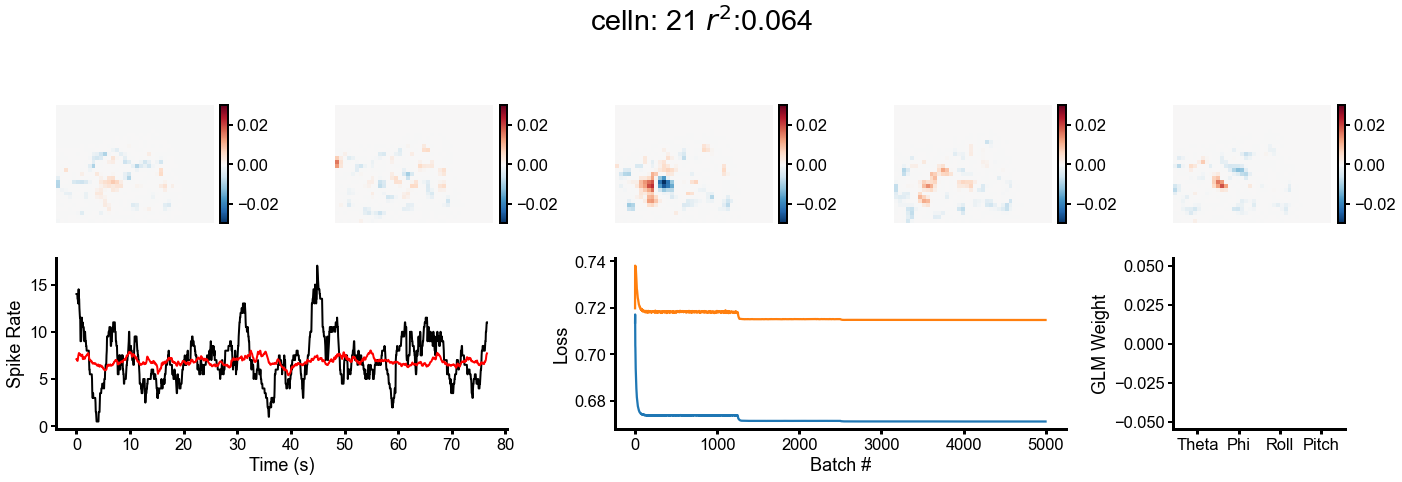

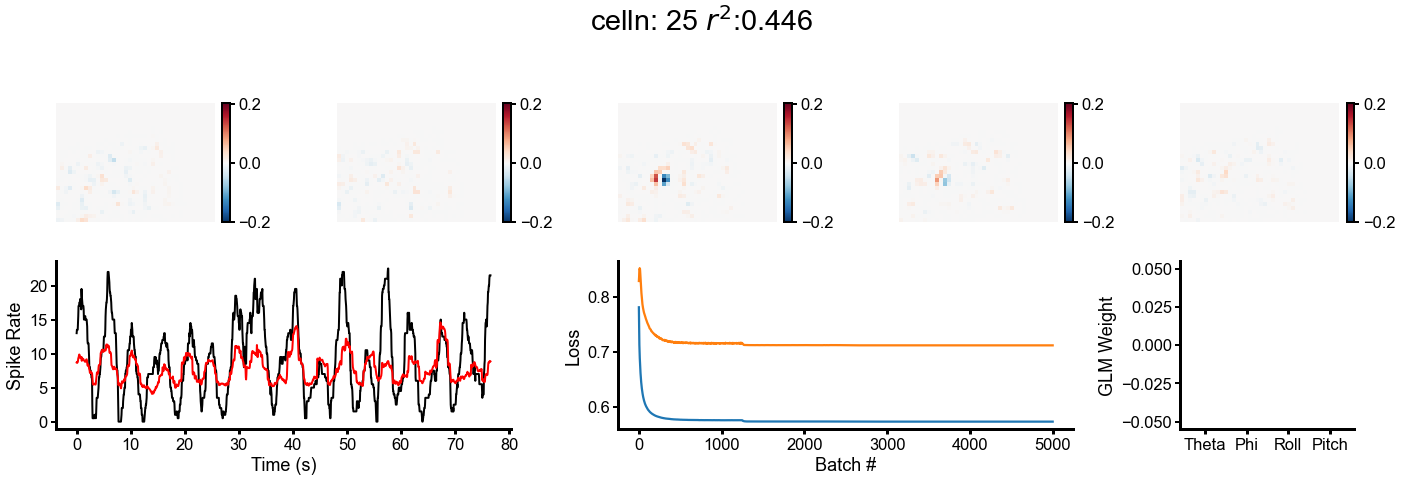

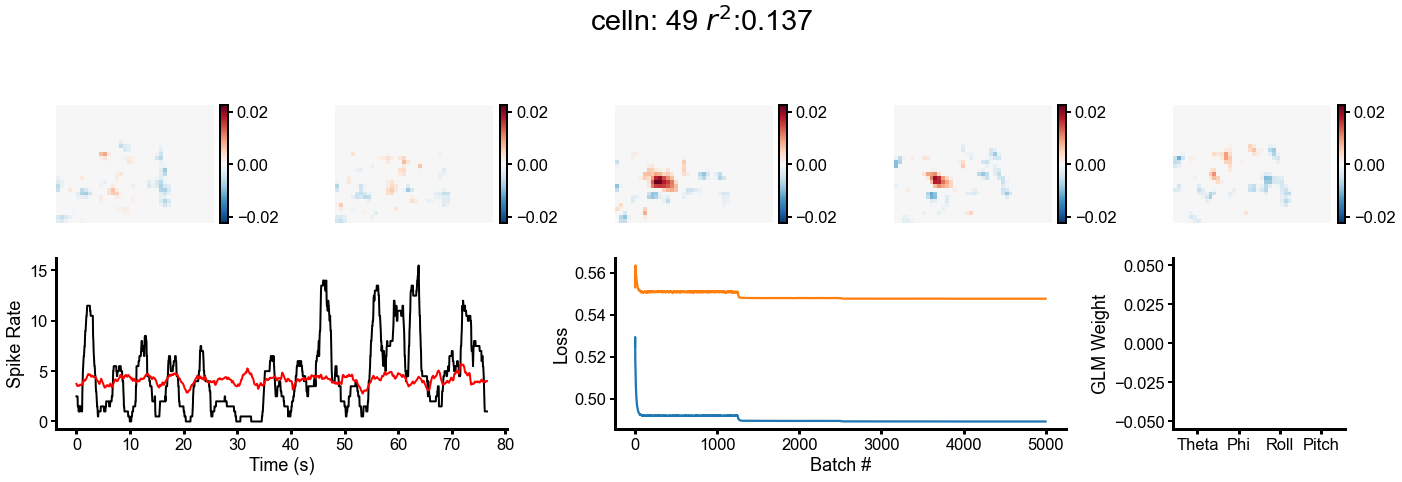

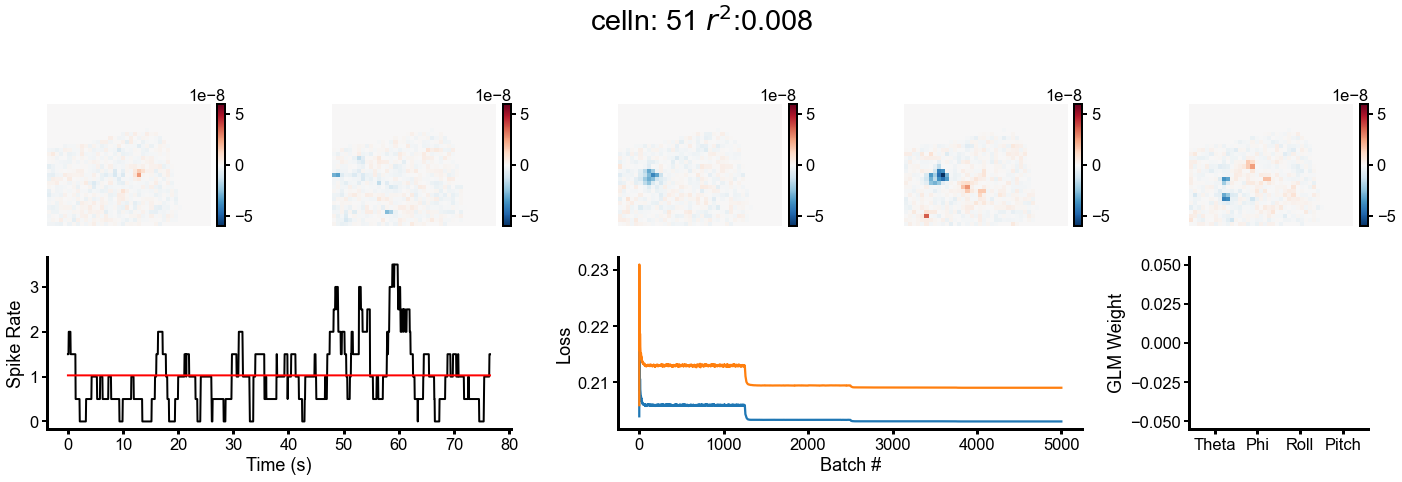

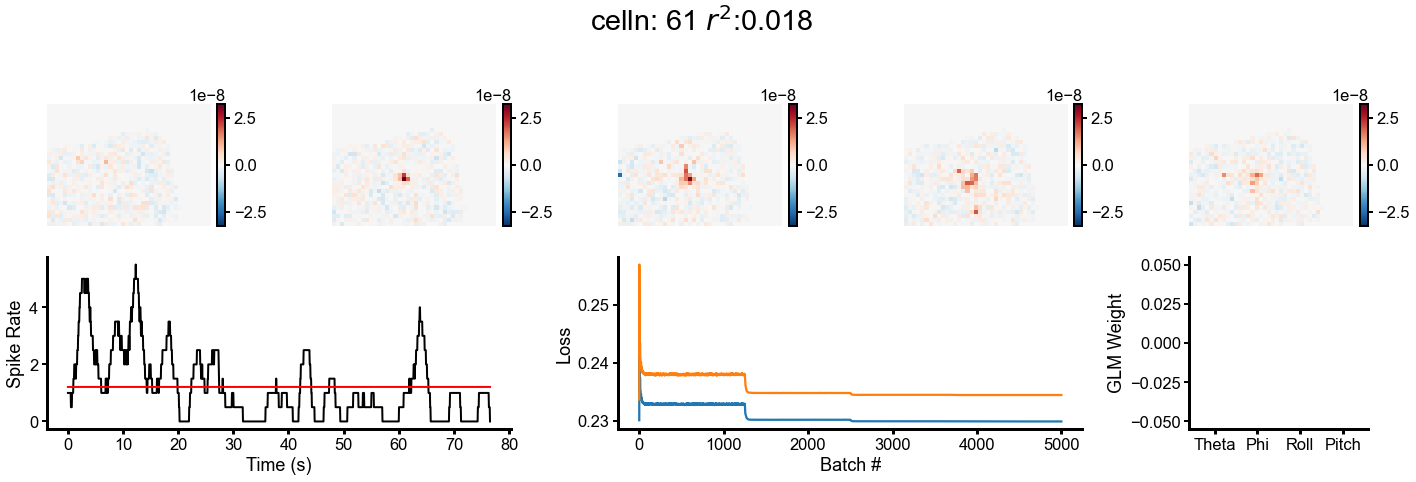

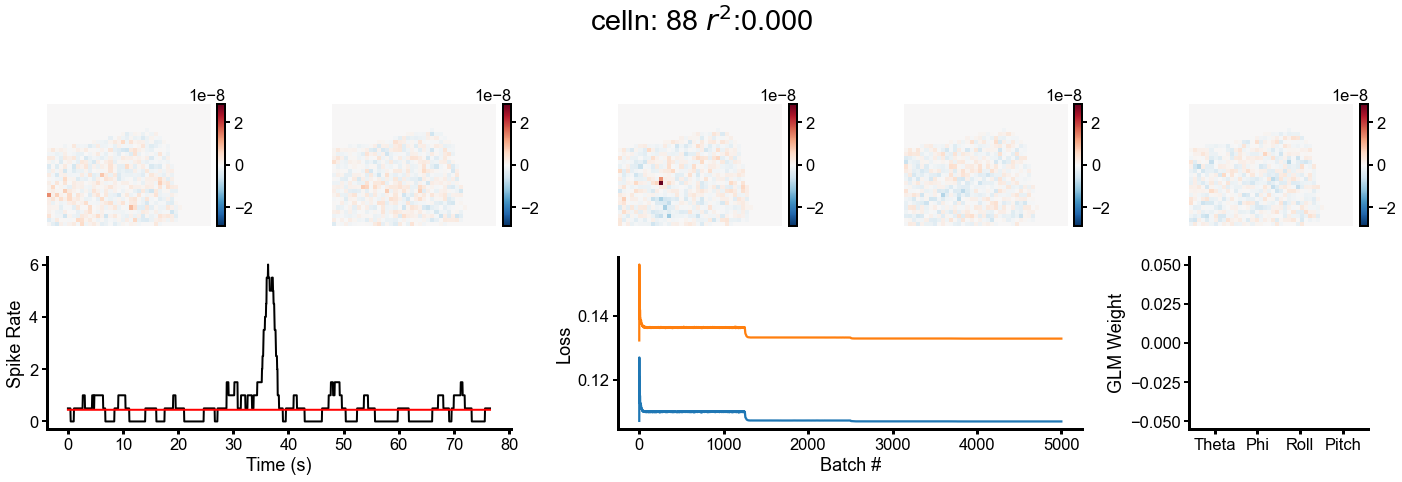

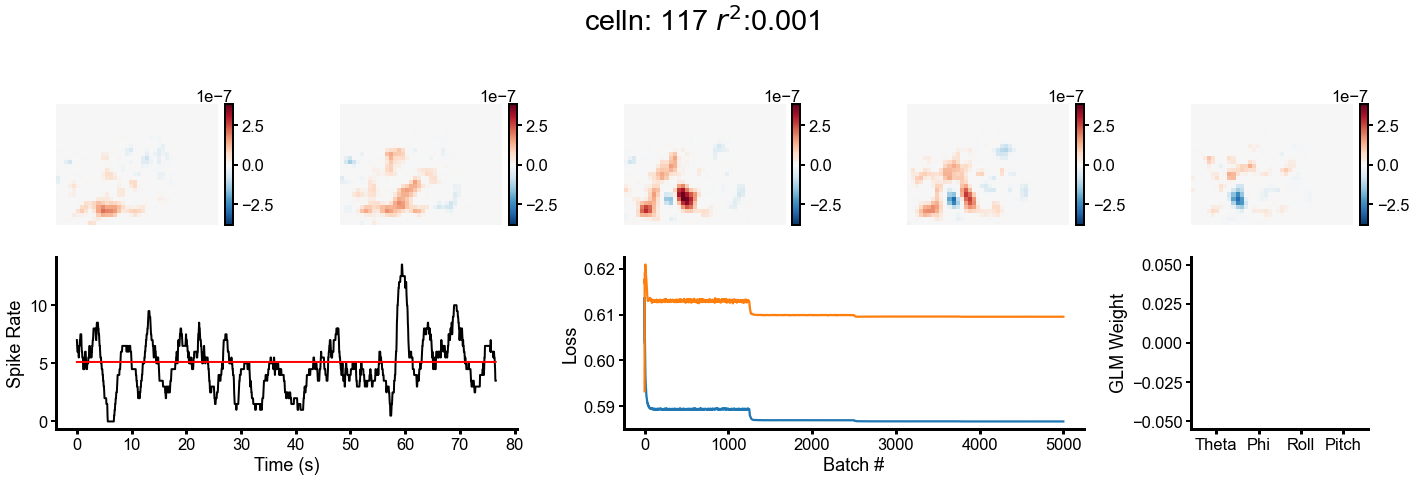

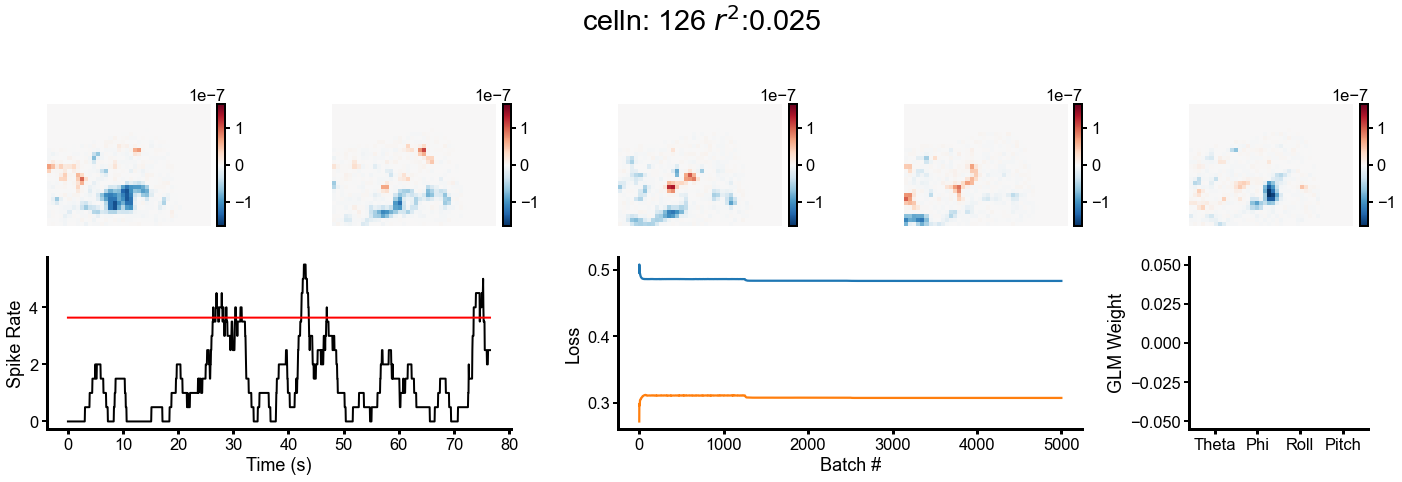

In [34]:
ncells = model_nsp.shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
quartiles = np.arange(0,1.25,.25)
bin_length=40
alph = 0#malph[celln]
lam = 0# mlam[celln]
for n, celln in enumerate(tqdm([21,25,49,51,61,88,117,126])):
    fig2 = plt.figure(constrained_layout=False, figsize=(20,7))
    spec2 = gridspec.GridSpec(ncols=5, nrows=2, figure=fig2)
    # axs = np.array([fig2.add_subplot(spec2[0, :])])
    axs = np.array([fig2.add_subplot(spec2[0, n]) for n in range(nt_glm_lag)])
    f2_ax6 = fig2.add_subplot(spec2[1, :nt_glm_lag//2])
    f2_ax7 = fig2.add_subplot(spec2[1, (nt_glm_lag//2):-1])
    f2_ax8 = fig2.add_subplot(spec2[1,-1])
    if MovModel != 0:
        crange = np.max(np.abs(sta_all[celln]))
        for m,ax in enumerate(axs):
            im = ax.imshow(sta_all[celln,m],'RdBu_r',vmin=-crange,vmax=crange)
            cbar = add_colorbar(im)
            ax.axis('off')

    sp_smooth = ((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    f2_ax6.plot(np.arange(len(sp_smooth))*model_dt,sp_smooth, 'k', lw=2)
    pred_smooth = ((np.convolve(pred_all[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    f2_ax6.plot(np.arange(len(pred_smooth))*model_dt,pred_smooth,'r', lw=2)
    f2_ax6.set_xlabel('Time (s)')
    f2_ax6.set_ylabel('Spike Rate')
    f2_ax7.plot(tloss_trace_all[alph,lam,:,celln])
    f2_ax7.plot(vloss_trace_all[alph,lam,:,celln])
    f2_ax7.set_xlabel('Batch #')
    f2_ax7.set_ylabel('Loss')
    r2 = (np.corrcoef(sp_smooth,pred_smooth)[0,1])**2
    
    if MovModel == 1:
        w_move = np.zeros((model_nsp.shape[-1],len(titles)))
    elif MovModel == 3:
        Msta = w_move[:,:-len(titles)].reshape((model_nsp.shape[-1],nt_glm_lag,len(titles))+nks)
        w_move = w_move[:,-len(titles):]
    for modeln in range(len(titles)):
        f2_ax8.bar(modeln, w_move[celln,modeln], color=clrs[modeln])
        f2_ax8.set_xticks(np.arange(0,len(titles)))
        f2_ax8.set_xticklabels(titles)
        f2_ax8.set_ylabel('GLM Weight')
    
    plt.suptitle('celln: {} $r^2$:{:.03f}'.format(celln, r2))
    plt.tight_layout()


In [78]:
msetest[0,:,126]

array([       nan, 0.30701175, 0.30449787, 0.30182469, 0.2993325 ,
       0.29723662, 0.29567879, 0.29464486, 0.29402885, 0.29369149,
       0.29351705, 0.29343012, 0.2933864 , 0.2933647 , 0.29335383,
       0.2933481 , 0.29334515, 0.2933436 , 0.29334289, 0.29334253,
       0.29334235])

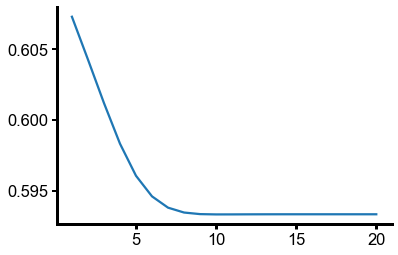

In [77]:
plt.plot(msetest[0,:,117])

# Plotting

In [13]:
x_train_m1 = (rolled_vid[train_idx].reshape(len(train_idx), -1)).astype(np.float32)
x_test_m1 = (rolled_vid[test_idx].reshape(len(test_idx), -1)).astype(np.float32)

NameError: name 'rolled_vid' is not defined

In [59]:
# MovModel = 1
bin_length=40
data, train_idx, test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=do_shuffle, do_norm=False,free_move=free_move, has_imu=free_move, has_mouse=False,do_worldcam_correction=do_worldcam_correction)
locals().update(data)
# if do_shuffle:
#     GLM_Vis = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_shuffled.h5'.format(model_type,int(model_dt*1000), nt_glm_lag, MovModel))
# else:
#     GLM_Vis = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag, MovModel))
# locals().update(GLM_Vis)
##### Explore Neurons #####
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']

# Initialize movement combinations
titles = np.array(['Theta','Phi','Roll','Pitch']) # 'dg_p','dg_n' 'roll','pitch'
titles_all = []
for n in range(1,len(titles)+1):
    perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
    for ind in range(perms.shape[0]):
        titles_all.append('_'.join([t for t in titles[perms[ind]]]))
if free_move:
    move_train = np.hstack((train_th[:,np.newaxis],train_phi[:,np.newaxis],train_roll[:,np.newaxis],medfilt(train_pitch,3)[:,np.newaxis]))
    move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_roll[:,np.newaxis],medfilt(test_pitch,3)[:,np.newaxis])) 
    model_move = np.hstack((model_th[:, np.newaxis], model_phi[:, np.newaxis],model_roll[:, np.newaxis], medfilt(model_pitch, 3)[:, np.newaxis]))
    model_move = model_move - np.mean(model_move,axis=0)
    move_test = move_test - np.mean(move_test,axis=0)
    move_train = move_train - np.mean(move_train,axis=0)

pred_train = np.log1p(np.exp(sta_all.reshape(output_size,-1)@x_train_m1.reshape(x_train_m1.shape[0],-1).T + bias_all[:,np.newaxis])).T
# Create all tuning curves for plotting
N_bins=10
ncells = model_nsp.shape[-1]
ax_ylims = np.zeros((model_nsp.shape[-1],len(titles)))
tuning_curves = np.zeros((model_nsp.shape[-1],len(titles),N_bins-1))
tuning_stds = np.zeros((model_nsp.shape[-1],len(titles),N_bins-1))
var_ranges = np.zeros((len(titles),N_bins-1))
for modeln in range(len(titles)):
    metric = move_test[:,modeln]
    tuning, tuning_std, var_range = tuning_curve(test_nsp, metric, N_bins=N_bins, model_dt=model_dt, Nstds=2)
    tuning_curves[:,modeln] = tuning
    tuning_stds[:,modeln] = tuning_std
    ax_ylims[:,modeln] = np.nanmax(tuning,axis=1)
    var_ranges[modeln] = var_range

Done Loading Unaligned data
TRAIN: 15628 TEST: 6698


In [565]:
# Nbatches = 2500
MovModel=2
if MovModel == 1:
    GLM_VisMov_Li = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format('Pytorch_Lin',int(model_dt*1000), nt_glm_lag, 1, Nbatches))
    GLM_VisMov_NL = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format('Pytorch_Nonlin',int(model_dt*1000), nt_glm_lag, 1, Nbatches))
else:
    GLM_VisMov_Li = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format('Pytorch_Lin',int(model_dt*1000), nt_glm_lag, 2, Nbatches))
    GLM_VisMov_NL = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format('Pytorch_Nonlin',int(model_dt*1000), nt_glm_lag, 2, Nbatches))
locals().update(GLM_VisMov_NL)


In [ ]:
ncells = model_nsp.shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
quartiles = np.arange(0,1.25,.25)
bin_length = 40
for MovModel in [1,2]:
    if MovModel == 1:
        GLM_VisMov_Li = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format('Pytorch_Lin',int(model_dt*1000), nt_glm_lag, 1, Nbatches))
        GLM_VisMov_NL = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format('Pytorch_Nonlin',int(model_dt*1000), nt_glm_lag, 1, Nbatches))
    else:
        GLM_VisMov_Li = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format('Pytorch_Lin',int(model_dt*1000), nt_glm_lag, 2, Nbatches))
        GLM_VisMov_NL = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format('Pytorch_Nonlin',int(model_dt*1000), nt_glm_lag, 2, Nbatches))
    pdf_name = FigPath/ 'VisMov_{}_dt{:03d}_Lags{:02d}_MovModel{:d}_CellSummary.pdf'.format('Pytorch_ReluExp',int(model_dt*1000),nt_glm_lag, MovModel)
    with PdfPages(pdf_name) as pdf:
        for n, celln in enumerate(tqdm(np.arange(model_nsp.shape[1]))): #[51,61])):
            fig2 = plt.figure(constrained_layout=False, figsize=(20,14))
            spec2 = gridspec.GridSpec(ncols=5, nrows=4, figure=fig2)
            # axs = np.array([fig2.add_subplot(spec2[0, :])])
            axs = np.array([fig2.add_subplot(spec2[0, n]) for n in range(nt_glm_lag)])
            axs2 = np.array([fig2.add_subplot(spec2[2, n]) for n in range(nt_glm_lag)])
            f2_ax6 = fig2.add_subplot(spec2[1, :nt_glm_lag//2])
            f2_ax7 = fig2.add_subplot(spec2[1, (nt_glm_lag//2):-1])
            f2_ax8 = fig2.add_subplot(spec2[1,-1])
            f2_ax6b = fig2.add_subplot(spec2[3, :nt_glm_lag//2])
            f2_ax7b = fig2.add_subplot(spec2[3, (nt_glm_lag//2):-1])
            f2_ax8b = fig2.add_subplot(spec2[3,-1])
            if MovModel != 0:
                crange = np.max(np.abs(GLM_VisMov_Li['sta_all'][celln]))
                crange2 = np.max(np.abs(GLM_VisMov_NL['sta_all'][celln]))
                for m,(ax,ax2) in enumerate(zip(axs,axs2)):
                    im = ax.imshow(GLM_VisMov_Li['sta_all'][celln,m],'RdBu_r',vmin=-crange,vmax=crange)
                    cbar = add_colorbar(im)
                    ax.axis('off')
                    im = ax2.imshow(GLM_VisMov_NL['sta_all'][celln,m],'RdBu_r',vmin=-crange2,vmax=crange2)
                    cbar = add_colorbar(im)
                    ax2.axis('off')

            sp_smooth = ((np.convolve(GLM_VisMov_Li['test_nsp'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
            f2_ax6.plot(np.arange(len(sp_smooth))*model_dt,sp_smooth, 'k', lw=2)
            pred_smooth = ((np.convolve(GLM_VisMov_Li['pred_all'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
            f2_ax6.plot(np.arange(len(pred_smooth))*model_dt,pred_smooth,'r', lw=2)
            f2_ax6.set_xlabel('Time (s)')
            f2_ax6.set_ylabel('Spike Rate')
            f2_ax7.plot(GLM_VisMov_Li['tloss_trace_all'][celln]) #[alph,lam,:,celln])
            f2_ax7.plot(GLM_VisMov_Li['vloss_trace_all'][celln]) #[alph,lam,:,celln])
            f2_ax7.set_xlabel('Batch #')
            f2_ax7.set_ylabel('Loss')
            r2 = (np.corrcoef(sp_smooth,pred_smooth)[0,1])**2

            sp_smooth2 = ((np.convolve(GLM_VisMov_NL['test_nsp'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
            f2_ax6b.plot(np.arange(len(sp_smooth))*model_dt,sp_smooth, 'k', lw=2)
            pred_smooth2 = ((np.convolve(GLM_VisMov_NL['pred_all'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
            f2_ax6b.plot(np.arange(len(pred_smooth2))*model_dt,pred_smooth2,'r', lw=2)
            f2_ax6b.set_xlabel('Time (s)')
            f2_ax6b.set_ylabel('Spike Rate')
            f2_ax7b.plot(GLM_VisMov_NL['tloss_trace_all'][celln]) #[alph,lam,:,celln])
            f2_ax7b.plot(GLM_VisMov_NL['vloss_trace_all'][celln]) #[alph,lam,:,celln])
            f2_ax7b.set_xlabel('Batch #')
            f2_ax7b.set_ylabel('Loss')
            r2b = (np.corrcoef(sp_smooth2,pred_smooth2)[0,1])**2

            if MovModel == 1:
                w_move = np.zeros((model_nsp.shape[-1],len(titles)))
                w_move2 = np.zeros((model_nsp.shape[-1],len(titles)))
            elif MovModel == 2:
                w_move = GLM_VisMov_Li['w_move']
                w_move2 = GLM_VisMov_NL['w_move']
            for modeln in range(len(titles)):
                f2_ax8.bar(modeln, w_move[celln,modeln], color=clrs[modeln])
                f2_ax8.set_xticks(np.arange(0,len(titles)))
                f2_ax8.set_xticklabels(titles)
                f2_ax8.set_ylabel('GLM Weight')
                f2_ax8b.bar(modeln, w_move2[celln,modeln], color=clrs[modeln])
                f2_ax8b.set_xticks(np.arange(0,len(titles)))
                f2_ax8b.set_xticklabels(titles)
                f2_ax8b.set_ylabel('GLM Weight')
            plt.suptitle(' celln: {} LiN $r^2$:{:.03f},\n NLN $r^2$:{:.03f}'.format(celln, r2,r2b))
            plt.tight_layout()
            pdf.savefig()
            plt.close()

In [65]:
celln = 21
np.corrcoef(GLM_VisMov_NL['test_nsp'][:,celln],GLM_VisMov_NL['pred_all'][:,celln])[0,1]**2

0.10900847267776113

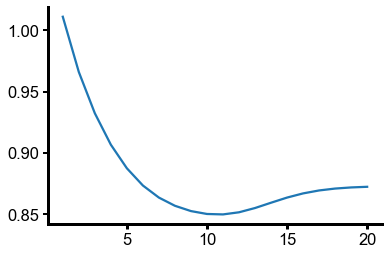

In [58]:
plt.plot(msetest[0,:,117])

In [79]:
sf = 4
sta_up = np.zeros((sta_all.shape[0], sta_all.shape[1],sf*sta_all.shape[-2], sf*sta_all.shape[-1]))
for n in range(sta_up.shape[0]):
    for t in range(sta_up.shape[1]):
        sta_up[n, t] = cv2.resize(sta_all[n, t], (sf*(sta_all.shape[-1]), sf*(sta_all.shape[-2])))

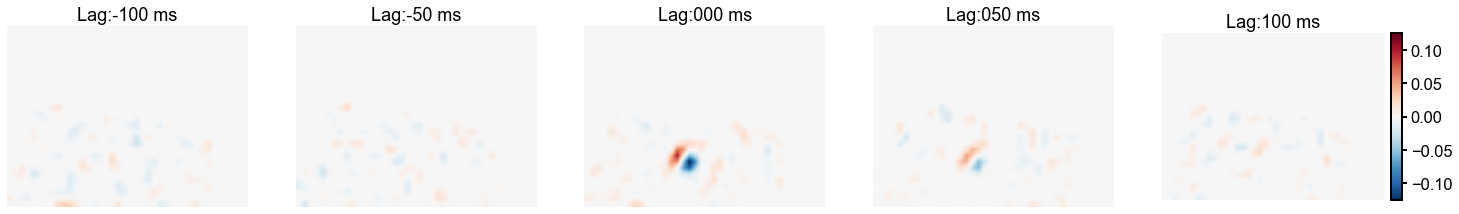

In [83]:
celln = 25
fig, top_grid = plt.subplots(1,nt_glm_lag,figsize=(25,5))
crange = np.max(np.abs(sta_up[celln]))
for n in range(nt_glm_lag):
    img = top_grid[n].imshow(sta_up[celln,n],cmap='RdBu_r',vmin=-crange,vmax=crange)
    top_grid[n].axis('off')
    top_grid[n].set_title('Lag:{:03d} ms'.format(int(1000*lag_list[n]*model_dt)))
    top_grid[n].axis('off')
add_colorbar(img)

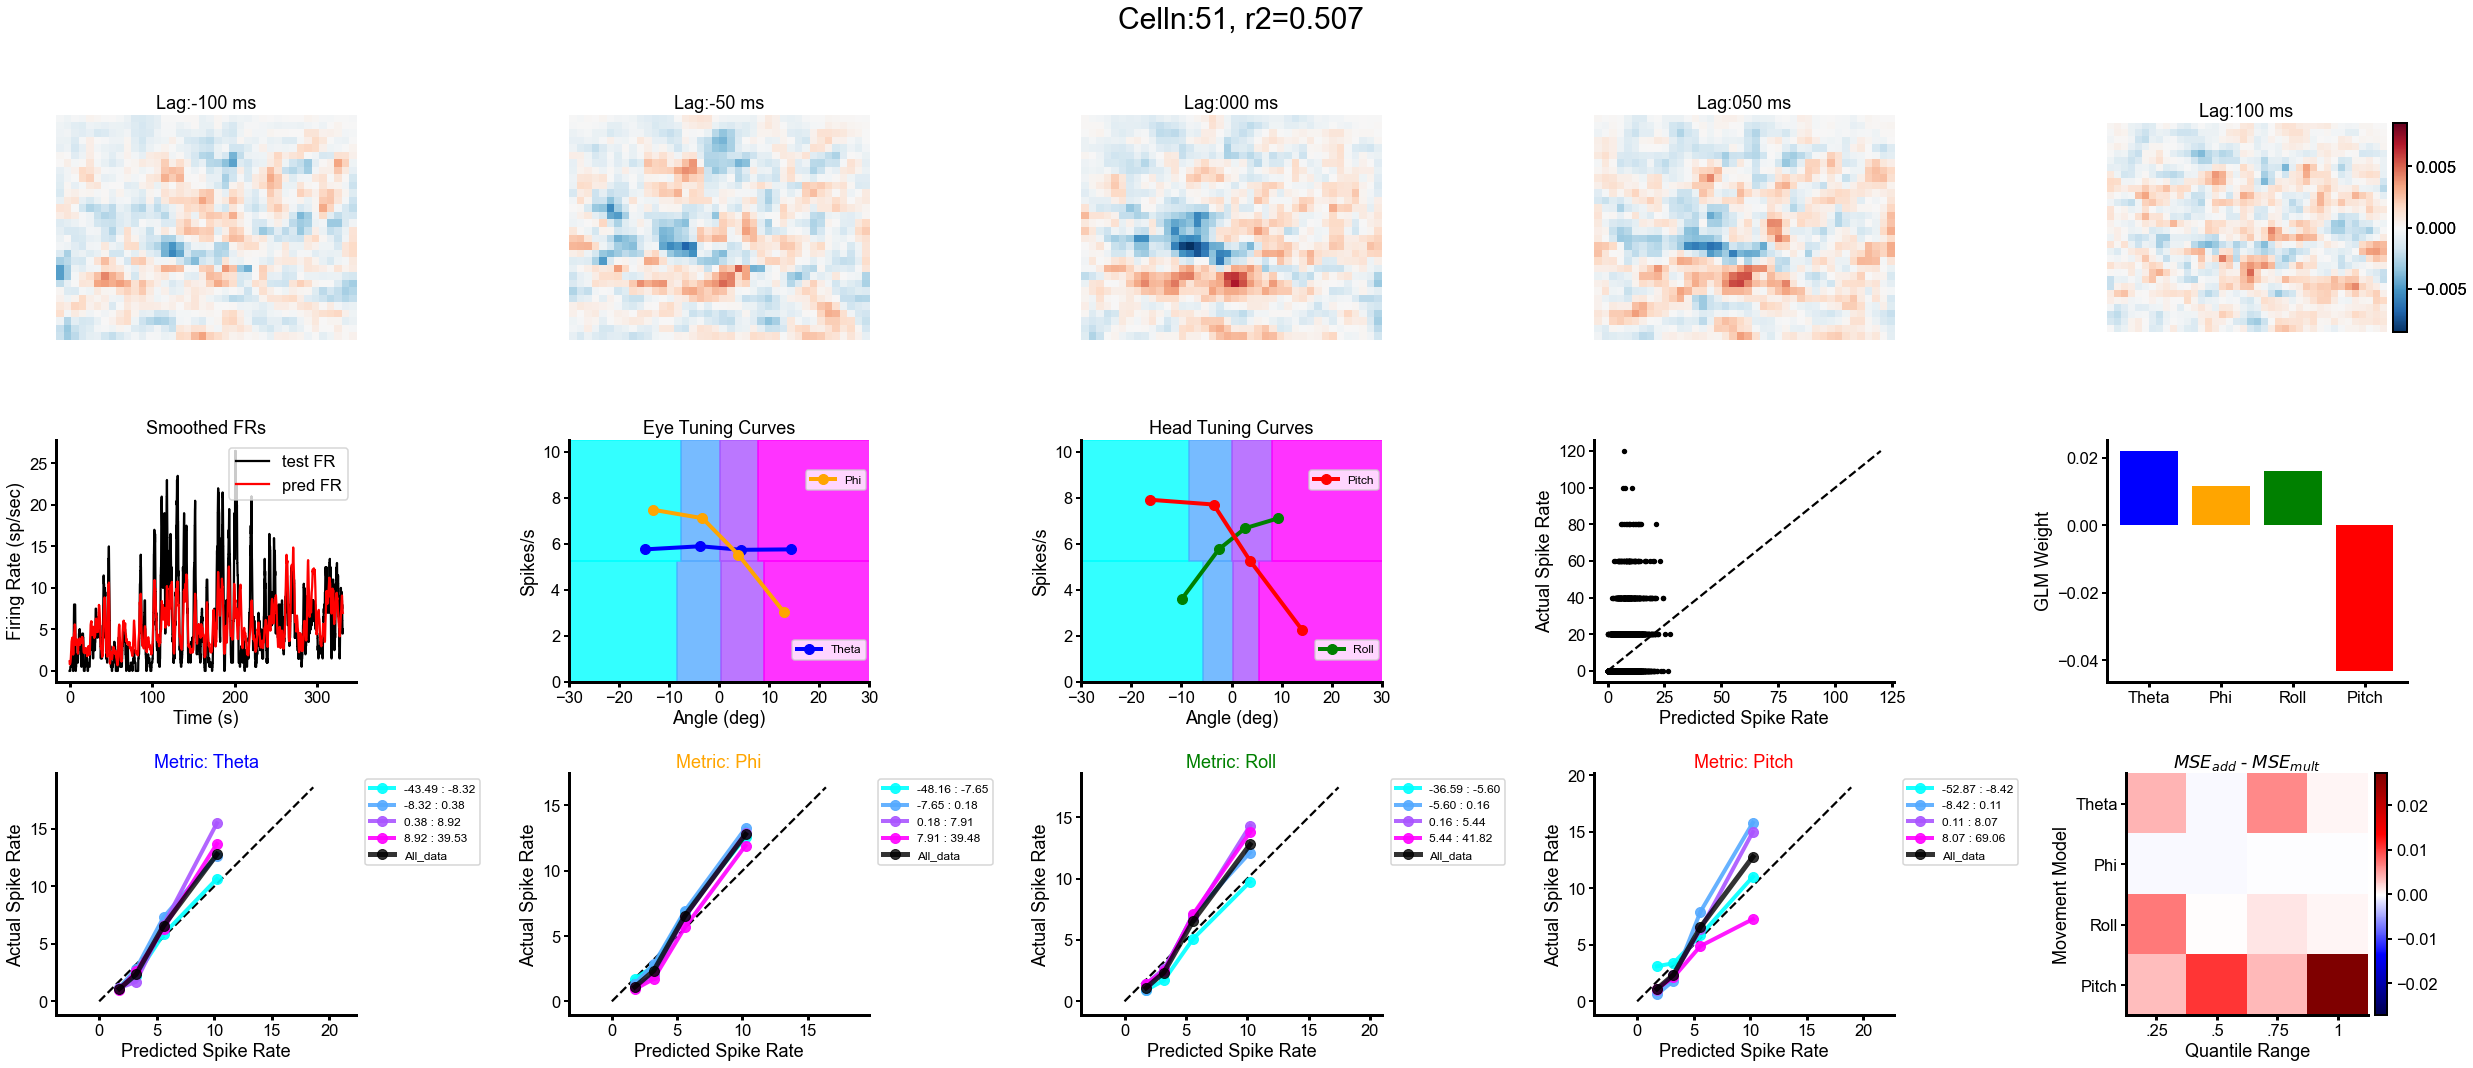

In [64]:
celln = 51 # np.argmax(r2_all)
bin_length = 40
ncells=model_nsp.shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
quartiles = np.arange(0,1.25,.25)

fig, axs = plt.subplots(3,5, figsize=((35,15))) 
gs = axs[0,0].get_gridspec()
gs_sub = gs[0,:].subgridspec(1,nt_glm_lag)
for ax in axs[0,:]:
    ax.remove()
top_grid = np.zeros((nt_glm_lag),dtype=object)
for ind in range(nt_glm_lag):
    top_grid[ind] = fig.add_subplot(gs_sub[0,ind])

dataset_type = 'test'

if dataset_type == 'train':
    predcell = pred_train[:,celln]/model_dt
    nspcell = train_nsp[:,celln]/model_dt
    nsp_raw = train_nsp[:,celln]
    pred_raw = pred_train[:,celln]
    move_data = move_train.copy()
else: 
    predcell = pred_all[:,celln]/model_dt
    nspcell = test_nsp[:,celln]/model_dt
    nsp_raw = test_nsp[:,celln]
    pred_raw = pred_all[:,celln]
    move_data = move_test.copy()

nsp_smooth=((np.convolve(nsp_raw, np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
pred_smooth=((np.convolve(pred_raw, np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]


# Set up predicted spike range between 1-99th percentile
stat_bins = 5
pred_range = np.quantile(predcell,[.1,.9])
test_nsp_range = np.quantile(nspcell,[.01,1])
spike_percentiles = np.arange(0,1.25,.25)
spike_percentiles[-1]=.99
spk_percentile2 = np.arange(.125,1.125,.25)
pred_rangelin = np.quantile(predcell,spike_percentiles)
xbin_pts = np.quantile(predcell,spk_percentile2)
stat_bins = len(pred_rangelin) #5


axs[1,0].plot(np.arange(len(nsp_smooth))*model_dt,nsp_smooth,'k',label='test FR')
axs[1,0].plot(np.arange(len(pred_smooth))*model_dt,pred_smooth,'r', label='pred FR')
axs[1,0].set_xlabel('Time (s)')
axs[1,0].set_ylabel('Firing Rate (sp/sec)')
axs[1,0].legend()
axs[1,0].set_title('Smoothed FRs')

crange = np.max(np.abs(sta_all[celln]))
for n in range(nt_glm_lag):
    img = top_grid[n].imshow(sta_all[celln,n],cmap='RdBu_r',vmin=-crange,vmax=crange)
    top_grid[n].axis('off')
    top_grid[n].set_title('Lag:{:03d} ms'.format(int(1000*lag_list[n]*model_dt)))
    top_grid[n].axis('off')
add_colorbar(img)

# Eye Tuning Curve
top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
for i,modeln in enumerate(range(len(titles)-2)):
    metric = move_data[:,modeln]
    nranges = np.quantile(metric,quartiles)
    stat_range, edges, _ = binned_statistic(metric,nsp_raw,statistic='mean',bins=nranges)
    edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    # cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
    # norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=len(cmap.colors))
    for m in range(len(nranges)-1):
        axs[1,1].axvspan(nranges[m], nranges[m+1],ymin=i*1/2,ymax=(i+1)*1/2,alpha=0.8, color=colors[m],zorder=0)
    #     axs[1,1].errorbar(var_ranges[modeln],tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln],label=titles[modeln],c=clrs[modeln],lw=4,elinewidth=3)
    axs[1,1].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

axs[1,1].set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
axs[1,1].set_xlim(-30,30)
axs[1,1].set_xlabel('Angle (deg)')
axs[1,1].set_ylabel('Spikes/s')
axs[1,1].set_title('Eye Tuning Curves')
lines = axs[1,1].get_lines()
legend1 = axs[1,1].legend([lines[0]],[titles[0]],bbox_to_anchor=(1.01, .2), fontsize=12)
legend2 = axs[1,1].legend([lines[1]],[titles[1]],bbox_to_anchor=(1.01, .9), fontsize=12)
axs[1,1].add_artist(legend1)

# Head Tuning Curves
top_yaxs = np.max(ax_ylims[celln])+2*np.nanmax(tuning_stds[celln])
for i, modeln in enumerate(range(2,len(titles))):
    metric = move_data[:,modeln]
#     nranges = np.round(np.quantile(var_ranges[modeln],quartiles),decimals=1)
    nranges = np.round(np.quantile(metric,quartiles),decimals=1)
    stat_range, edges, _ = binned_statistic(metric,nsp_raw,statistic='mean',bins=nranges)
    edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    # cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
    # norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=len(cmap.colors))
    for m in range(len(nranges)-1):
        axs[1,2].axvspan(nranges[m], nranges[m+1],ymin=i*1/2,ymax=(i+1)*1/2,alpha=0.8, color=colors[m],zorder=0)
#     axs[1,2].errorbar(var_ranges[modeln], tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln], label=titles[modeln], c=clrs[modeln],lw=4,elinewidth=3)
    axs[1,2].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

axs[1,2].set_ylim(bottom=0,top=top_yaxs)
axs[1,2].set_xlim(-30,30)
axs[1,2].set_xlabel('Angle (deg)')
axs[1,2].set_ylabel('Spikes/s')
axs[1,2].set_title('Head Tuning Curves')
lines = axs[1,2].get_lines()
legend1 = axs[1,2].legend([lines[0]],[titles[2]],bbox_to_anchor=(1.01, .2), fontsize=12)
legend2 = axs[1,2].legend([lines[1]],[titles[3]],bbox_to_anchor=(1.01, .9), fontsize=12)
axs[1,2].add_artist(legend1)

# axs[1,2].legend(bbox_to_anchor=(1.01, 1), fontsize=12)


# pred_rangelin = np.linspace(pred_range[0],pred_range[1],stat_bins)
axs[1,3].scatter(predcell,nspcell,c='k',s=15)
axs[1,3].plot(np.linspace(test_nsp_range[0],test_nsp_range[1]),np.linspace(test_nsp_range[0],test_nsp_range[1]),'k--',zorder=0)
axs[1,3].set_xlabel('Predicted Spike Rate')
axs[1,3].set_ylabel('Actual Spike Rate')
cbar = add_colorbar(img)
# cbar.set_label('count')

if MovModel == 1:
    w_move = np.zeros((model_nsp.shape[-1],len(titles)))
elif MovModel == 3:
    Msta = w_move[:,:-len(titles)].reshape((model_nsp.shape[-1],nt_glm_lag,len(titles))+nks)
    w_move = w_move[:,-len(titles):]
for modeln in range(len(titles)):
    axs[1,4].bar(modeln, w_move[celln,modeln], color=clrs[modeln])
    axs[1,4].set_xticks(np.arange(0,len(titles)))
    axs[1,4].set_xticklabels(titles)
    axs[1,4].set_ylabel('GLM Weight')


mse_add = np.zeros((ncells,len(titles),len(quartiles)-1))
mse_mult = np.zeros((ncells,len(titles),len(quartiles)-1))
alpha_add = np.zeros((ncells,len(titles),len(quartiles)-1))
alpha_mult = np.zeros((ncells,len(titles),len(quartiles)-1))

traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
traces_mean = np.zeros((ncells,len(titles),stat_bins-1)) # (model_type,quartile,FR)
edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
# df_traces = pd.DataFrame([],columns=['modeln','quartile','FR']) 
for modeln in range(len(titles)):
    metric = move_data[:,modeln]
    nranges = np.quantile(metric,quartiles)# np.linspace(np.nanmean(metric)-2*np.nanstd(metric), np.nanmean(metric)+2*np.nanstd(metric),N_bins)
    stat_all, edges, _ = binned_statistic(predcell,nspcell,statistic='mean',bins=pred_rangelin)
    edge_mids = xbin_pts#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    traces_mean[celln,modeln]=stat_all
    max_fr = np.max(stat_all)
#     axs[1,modeln].set_xlim(0,pred_range[1]+np.std(pred_range))
#     axs[1,modeln].set_ylim(0,np.max(stat)+np.std(stat))

    for n in range(len(nranges)-1):
        ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
        pred = predcell[ind]
        sp = nspcell[ind]

        stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
        edge_mids = xbin_pts #np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
        traces[celln,modeln,n]=stat_range
        edges_all[celln,modeln,n]=edge_mids
        res_add = minimize_scalar(f_add,args=(stat_range/max_fr, stat_all/max_fr))
        res_mult = minimize_scalar(f_mult,args=(stat_range/max_fr, stat_all/max_fr))
        mse_add[celln, modeln, n] = res_add.fun
        mse_mult[celln, modeln, n] = res_mult.fun
        alpha_add[celln, modeln, n] = res_add.x
        alpha_mult[celln, modeln, n] = res_mult.x

        axs[2,modeln].plot(edge_mids, stat_range,'.-', c=colors[n],label='{:.02f} : {:.02f}'.format(nranges[n],nranges[n+1]),lw=4,ms=20,alpha=.9)
        axs[2,modeln].set_title('Metric: {}'.format(titles[modeln]), color=clrs[modeln])
        axs[2,modeln].set_xlabel('Predicted Spike Rate')
        axs[2,modeln].set_ylabel('Actual Spike Rate')
    
    lim_max = np.nanmax(np.hstack((edge_mids,traces[celln,modeln].flatten())))+.5*np.std(edges)
    lim_min = np.nanmin(np.hstack((edge_mids,traces[celln,modeln].flatten())))-.5*np.std(edges)
    lims = (0, lim_max) if (lim_min)<0 else (lim_min,lim_max) 
    axs[2,modeln].plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
    axs[2,modeln].plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8)
    axs[2,modeln].legend(bbox_to_anchor=(1.01, 1), fontsize=12)
    axs[2,modeln].axis('equal')
#     axs[2,modeln].set_xlim(left=0)
    axs[2,modeln].set(xlim=lims, ylim=lims)
#     axs[2,modeln].set_xlim([0,xbin_pts[-1]])
    axs[2,modeln].set_ylim(bottom=0)

dmodel = mse_add[celln]-mse_mult[celln]
crange = np.max(np.abs(dmodel))
im = axs[2,-1].imshow(dmodel,cmap='seismic',vmin=-crange,vmax=crange)
axs[2,-1].set_yticks(np.arange(0,4))
axs[2,-1].set_yticklabels(titles)
axs[2,-1].set_ylabel('Movement Model')
axs[2,-1].set_xticks(np.arange(0,4))
axs[2,-1].set_xticklabels(['.25','.5','.75','1'])
axs[2,-1].set_xlabel('Quantile Range')
axs[2,-1].set_title('$MSE_{add}$ - $MSE_{mult}$')
cbar = add_colorbar(im)

plt.suptitle('Celln:{}, r2={:.03f}'.format(celln,r2_all[celln]),y=1,fontsize=30)
plt.tight_layout()


# fig.savefig(FigPath/'CellSummary_N{}_T{:02d}.png'.format(celln,nt_glm_lag), facecolor='white', transparent=True)

## Make PDF of All Cells

In [ ]:
save_datafile = save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag, MovModel, Nbatches)


In [45]:
##### Make PDF of All Cells #####
bin_length=40
do_shuffle = False
ncells=model_nsp.shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
for MovModel in [1]: #
    data, train_idx, test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=do_shuffle, do_norm=False,free_move=free_move, has_imu=free_move, has_mouse=False,do_worldcam_correction=do_worldcam_correction)
    locals().update(data)
    if do_shuffle:
        GLM_Vis = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_shuffled.h5'.format(model_type,int(model_dt*1000), nt_glm_lag, MovModel,Nbatches))
    else:
        GLM_Vis = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag, MovModel, Nbatches))
    locals().update(GLM_Vis)
    ##### Explore Neurons #####
    colors = plt.cm.cool(np.linspace(0,1,4))
    clrs = ['blue','orange','green','red']
    # Initialize movement combinations
    titles = np.array(['Theta','Phi','Roll','Pitch']) # 'dg_p','dg_n' 'roll','pitch'
    titles_all = []
    for n in range(1,len(titles)+1):
        perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
        for ind in range(perms.shape[0]):
            titles_all.append('_'.join([t for t in titles[perms[ind]]]))

    # train_dgaze_p = train_dth + np.diff(train_gz,append=0)
    # train_dgaze_n = train_dth - np.diff(train_gz,append=0)
    # test_dgaze_p = test_dth + np.diff(test_gz,append=0)
    # test_dgaze_n = test_dth - np.diff(test_gz,append=0)
    move_train = np.hstack((train_th[:,np.newaxis],train_phi[:,np.newaxis],train_roll[:,np.newaxis],train_pitch[:,np.newaxis]))#, train_dth[:,np.newaxis],train_dphi[:,np.newaxis]))
    move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_roll[:,np.newaxis],test_pitch[:,np.newaxis])) #,test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))#
    # move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))# test_dth[:,np.newaxis],test_dphi[:,np.newaxis]))
    model_move = np.hstack((model_th[:,np.newaxis],model_phi[:,np.newaxis],model_roll[:,np.newaxis],model_pitch[:,np.newaxis])) #,test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))#
    model_move = model_move - np.mean(model_move,axis=0)
    move_test = move_test - np.mean(move_test,axis=0)

    # Create all tuning curves for plotting
    N_bins=10
    ncells = model_nsp.shape[-1]
    ax_ylims = np.zeros((model_nsp.shape[-1],len(titles)))
    tuning_curves = np.zeros((model_nsp.shape[-1],len(titles),N_bins-1))
    tuning_stds = np.zeros((model_nsp.shape[-1],len(titles),N_bins-1))
    var_ranges = np.zeros((len(titles),N_bins-1))
    for modeln in range(len(titles)):
        metric = move_test[:,modeln]
        tuning, tuning_std, var_range = tuning_curve(test_nsp, metric, N_bins=N_bins, model_dt=model_dt)
        tuning_curves[:,modeln] = tuning
        tuning_stds[:,modeln] = tuning_std
        ax_ylims[:,modeln] = np.nanmax(tuning,axis=1)
        var_ranges[modeln] = var_range

    quartiles = np.arange(0,1.25,.25)
    if do_shuffle:
        pdf_name = FigPath/ 'VisMov_{}_dt{:03d}_Lags{:02d}_MovModel{:d}_CellSummary_shuff.pdf'.format(model_type,int(model_dt*1000),nt_glm_lag, MovModel)
    else:
        pdf_name = FigPath/ 'VisMov_{}_dt{:03d}_Lags{:02d}_MovModel{:d}_CellSummary.pdf'.format(model_type,int(model_dt*1000),nt_glm_lag, MovModel)
    with PdfPages(pdf_name) as pdf:
        for celln in tqdm(range(model_nsp.shape[1])):
            if MovModel == 0:
                fig, axs = plt.subplots(2,5, figsize=((35,10))) 
            else: 
                fig, axs = plt.subplots(3,5, figsize=((35,15))) 
                gs = axs[0,0].get_gridspec()
                gs_sub = gs[0,:].subgridspec(1,nt_glm_lag)
                for ax in axs[0,:]:
                    ax.remove()
                top_grid = np.zeros((nt_glm_lag),dtype=object)
                for ind in range(nt_glm_lag):
                    top_grid[ind] = fig.add_subplot(gs_sub[0,ind])

                dataset_type = 'test'

                if dataset_type == 'train':
                    predcell = pred_train[:,celln]/model_dt
                    nspcell = train_nsp[:,celln]/model_dt
                    nsp_raw = train_nsp[:,celln]
                    pred_raw = pred_train[:,celln]
                    move_data = move_train.copy()
                else: 
                    predcell = pred_all[:,celln]/model_dt
                    nspcell = test_nsp[:,celln]/model_dt
                    nsp_raw = test_nsp[:,celln]
                    pred_raw = pred_all[:,celln]
                    move_data = move_test.copy()

                nsp_smooth=((np.convolve(nsp_raw, np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
                pred_smooth=((np.convolve(pred_raw, np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]


                # Set up predicted spike range between 1-99th percentile
                stat_bins = 5
                pred_range = np.quantile(predcell,[.1,.9])
                test_nsp_range = np.quantile(nspcell,[.01,1])
                spike_percentiles = np.arange(0,1.25,.25)
                spike_percentiles[-1]=.99
                spk_percentile2 = np.arange(.125,1.125,.25)
                pred_rangelin = np.quantile(predcell,spike_percentiles)
                xbin_pts = np.quantile(predcell,spk_percentile2)
                stat_bins = len(pred_rangelin) #5


                axs[1,0].plot(np.arange(len(nsp_smooth))*model_dt,nsp_smooth,'k',label='test FR')
                axs[1,0].plot(np.arange(len(pred_smooth))*model_dt,pred_smooth,'r', label='pred FR')
                axs[1,0].set_xlabel('Time (s)')
                axs[1,0].set_ylabel('Firing Rate (spks/s)')
                axs[1,0].legend()
                axs[1,0].set_title('Smoothed FRs')

                crange = np.max(np.abs(sta_all[celln]))
                for n in range(nt_glm_lag):
                    img = top_grid[n].imshow(sta_all[celln,n],cmap='RdBu_r',vmin=-crange,vmax=crange)
                    top_grid[n].axis('off')
                    top_grid[n].set_title('Lag:{:03d} ms'.format(int(1000*lag_list[n]*model_dt)))
                    top_grid[n].axis('off')
                add_colorbar(img)

                # Eye Tuning Curve
                top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
                for i,modeln in enumerate(range(len(titles)-2)):
                    metric = move_data[:,modeln]
                    nranges = np.quantile(metric,quartiles)
                    stat_range, edges, _ = binned_statistic(metric,nsp_raw,statistic='mean',bins=nranges)
                    edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
                    # cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
                    # norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=len(cmap.colors))
                    for m in range(len(nranges)-1):
                        axs[1,1].axvspan(nranges[m], nranges[m+1],ymin=i*1/2,ymax=(i+1)*1/2,alpha=0.8, color=colors[m],zorder=0)
                    #     axs[1,1].errorbar(var_ranges[modeln],tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln],label=titles[modeln],c=clrs[modeln],lw=4,elinewidth=3)
                    axs[1,1].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

                axs[1,1].set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
                axs[1,1].set_xlim(-30,30)
                axs[1,1].set_xlabel('Angle (deg)')
                axs[1,1].set_ylabel('Spikes/s')
                axs[1,1].set_title('Eye Tuning Curves')
                lines = axs[1,1].get_lines()
                legend1 = axs[1,1].legend([lines[0]],[titles[0]],bbox_to_anchor=(1.01, .2), fontsize=12)
                legend2 = axs[1,1].legend([lines[1]],[titles[1]],bbox_to_anchor=(1.01, .9), fontsize=12)
                axs[1,1].add_artist(legend1)

                # Head Tuning Curves
                top_yaxs = np.max(ax_ylims[celln])+2*np.nanmax(tuning_stds[celln])
                for i, modeln in enumerate(range(2,len(titles))):
                    metric = move_data[:,modeln]
                #     nranges = np.round(np.quantile(var_ranges[modeln],quartiles),decimals=1)
                    nranges = np.round(np.quantile(metric,quartiles),decimals=1)
                    stat_range, edges, _ = binned_statistic(metric,nsp_raw,statistic='mean',bins=nranges)
                    edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
                    # cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
                    # norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=len(cmap.colors))
                    for m in range(len(nranges)-1):
                        axs[1,2].axvspan(nranges[m], nranges[m+1],ymin=i*1/2,ymax=(i+1)*1/2,alpha=0.8, color=colors[m],zorder=0)
                #     axs[1,2].errorbar(var_ranges[modeln], tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln], label=titles[modeln], c=clrs[modeln],lw=4,elinewidth=3)
                    axs[1,2].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

                axs[1,2].set_ylim(bottom=0,top=top_yaxs)
                axs[1,2].set_xlim(-30,30)
                axs[1,2].set_xlabel('Angle (deg)')
                axs[1,2].set_ylabel('Spikes/s')
                axs[1,2].set_title('Head Tuning Curves')
                lines = axs[1,2].get_lines()
                legend1 = axs[1,2].legend([lines[0]],[titles[2]],bbox_to_anchor=(1.01, .2), fontsize=12)
                legend2 = axs[1,2].legend([lines[1]],[titles[3]],bbox_to_anchor=(1.01, .9), fontsize=12)
                axs[1,2].add_artist(legend1)

                # axs[1,2].legend(bbox_to_anchor=(1.01, 1), fontsize=12)


                # pred_rangelin = np.linspace(pred_range[0],pred_range[1],stat_bins)
                axs[1,3].scatter(predcell,nspcell,c='k',s=15)
                axs[1,3].plot(np.linspace(test_nsp_range[0],test_nsp_range[1]),np.linspace(test_nsp_range[0],test_nsp_range[1]),'k--',zorder=0)
                axs[1,3].set_xlabel('Predicted Spike Rate')
                axs[1,3].set_ylabel('Actual Spike Rate')
                cbar = add_colorbar(img)
                # cbar.set_label('count')

                if MovModel == 1:
                    w_move = np.zeros((model_nsp.shape[-1],len(titles)))
                elif MovModel == 3:
                    # Msta = w_move[:,:-len(titles)].reshape((model_nsp.shape[-1],nt_glm_lag,len(titles))+nks)
                    w_move = w_move[:,-len(titles):]
                for modeln in range(len(titles)):
                    axs[1,4].bar(modeln, w_move[celln,modeln], color=clrs[modeln])
                    axs[1,4].set_xticks(np.arange(0,len(titles)))
                    axs[1,4].set_xticklabels(titles)
                    axs[1,4].set_ylabel('GLM Weight')


                mse_add = np.zeros((ncells,len(titles),len(quartiles)-1))
                mse_mult = np.zeros((ncells,len(titles),len(quartiles)-1))
                alpha_add = np.zeros((ncells,len(titles),len(quartiles)-1))
                alpha_mult = np.zeros((ncells,len(titles),len(quartiles)-1))

                traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
                traces_mean = np.zeros((ncells,len(titles),stat_bins-1)) # (model_type,quartile,FR)
                edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
                # df_traces = pd.DataFrame([],columns=['modeln','quartile','FR']) 
                for modeln in range(len(titles)):
                    metric = move_data[:,modeln]
                    nranges = np.quantile(metric,quartiles)# np.linspace(np.nanmean(metric)-2*np.nanstd(metric), np.nanmean(metric)+2*np.nanstd(metric),N_bins)
                    stat_all, edges, _ = binned_statistic(predcell,nspcell,statistic='mean',bins=pred_rangelin)
                    edge_mids = xbin_pts#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
                    traces_mean[celln,modeln]=stat_all
                    max_fr = np.max(stat_all)
                #     axs[1,modeln].set_xlim(0,pred_range[1]+np.std(pred_range))
                #     axs[1,modeln].set_ylim(0,np.max(stat)+np.std(stat))

                    for n in range(len(nranges)-1):
                        ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
                        pred = predcell[ind]
                        sp = nspcell[ind]

                        stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
                        edge_mids = xbin_pts #np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
                        traces[celln,modeln,n]=stat_range
                        edges_all[celln,modeln,n]=edge_mids
                        res_add = minimize_scalar(f_add,args=(stat_range/max_fr, stat_all/max_fr))
                        res_mult = minimize_scalar(f_mult,args=(stat_range/max_fr, stat_all/max_fr))
                        mse_add[celln, modeln, n] = res_add.fun
                        mse_mult[celln, modeln, n] = res_mult.fun
                        alpha_add[celln, modeln, n] = res_add.x
                        alpha_mult[celln, modeln, n] = res_mult.x

                        axs[2,modeln].plot(edge_mids, stat_range,'.-', c=colors[n],label='{:.02f} : {:.02f}'.format(nranges[n],nranges[n+1]),lw=4,ms=20,alpha=.9)
                        axs[2,modeln].set_title('Metric: {}'.format(titles[modeln]), color=clrs[modeln])
                        axs[2,modeln].set_xlabel('Predicted Spike Rate')
                        axs[2,modeln].set_ylabel('Actual Spike Rate')
                    
                    lim_max = np.nanmax(np.hstack((edge_mids,traces[celln,modeln].flatten())))+.5*np.std(edges)
                    lim_min = np.nanmin(np.hstack((edge_mids,traces[celln,modeln].flatten())))-.5*np.std(edges)
                    lims = (0, lim_max) if (lim_min)<0 else (lim_min,lim_max) 
                    axs[2,modeln].plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
                    axs[2,modeln].plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8)
                    axs[2,modeln].legend(bbox_to_anchor=(1.01, 1), fontsize=12)
                    axs[2,modeln].axis('equal')
                #     axs[2,modeln].set_xlim(left=0)
                    axs[2,modeln].set(xlim=lims, ylim=lims)
                #     axs[2,modeln].set_xlim([0,xbin_pts[-1]])
                    axs[2,modeln].set_ylim(bottom=0)

                dmodel = mse_add[celln]-mse_mult[celln]
                crange = np.max(np.abs(dmodel))
                im = axs[2,-1].imshow(dmodel,cmap='seismic',vmin=-crange,vmax=crange)
                axs[2,-1].set_yticks(np.arange(0,4))
                axs[2,-1].set_yticklabels(titles)
                axs[2,-1].set_ylabel('Movement Model')
                axs[2,-1].set_xticks(np.arange(0,4))
                axs[2,-1].set_xticklabels(['.25','.5','.75','1'])
                axs[2,-1].set_xlabel('Quantile Range')
                axs[2,-1].set_title('$MSE_{add}$ - $MSE_{mult}$')
                cbar = add_colorbar(im)

                plt.suptitle('Celln:{}, r2={:.03f}'.format(celln,r2_all[celln]),y=1,fontsize=30)
                plt.tight_layout()
            pdf.savefig()
            plt.close()


Done Loading Unaligned data
TRAIN: 23669 TEST: 10143


/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/format_data.py:671: RuntimeWarning: Mean of empty slice
  tuning[n,j] = np.nanmean(model_nsp[usePts,n])/model_dt
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


  0%|          | 0/71 [00:00<?, ?it/s]

In [ ]:
bin_length=40

for n, celln in enumerate(tqdm([21,25,51,117])):
    fig2 = plt.figure(constrained_layout=False, figsize=(20,7))
    spec2 = gridspec.GridSpec(ncols=nt_glm_lag, nrows=2, figure=fig2)
    axs = np.array([fig2.add_subplot(spec2[0, n]) for n in range(nt_glm_lag)])
    f2_ax6 = fig2.add_subplot(spec2[1, :nt_glm_lag//2])
    f2_ax7 = fig2.add_subplot(spec2[1, nt_glm_lag//2:-1])
    f2_ax8 = fig2.add_subplot(spec2[1, -1])
    crange = np.max(np.abs(sta_all[celln]))
    for n,ax in enumerate(axs):
        im = ax.imshow(sta_all[celln,n],'RdBu_r',vmin=-crange,vmax=crange)
        cbar = add_colorbar(im)
        ax.axis('off')

    sp_smooth = ((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    f2_ax6.plot(np.arange(len(sp_smooth))*model_dt,sp_smooth, 'k', lw=2)
    pred_smooth = ((np.convolve(pred_all[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    f2_ax6.plot(np.arange(len(pred_smooth))*model_dt,pred_smooth,'r', lw=2)
    f2_ax6.set_xlabel('Time (s)')
    f2_ax6.set_ylabel('Spike Rate')
    f2_ax7.plot(tloss_trace[:,celln])
    f2_ax7.plot(vloss_trace[:,celln])
    f2_ax7.set_xlabel('Batch #')
    f2_ax7.set_ylabel('Loss')
    r2 = (np.corrcoef(sp_smooth,pred_smooth)[0,1])**2
    for modeln in range(len(titles)):
        f2_ax8.bar(modeln, w_move[celln,modeln], color=clrs[modeln])
        f2_ax8.set_xticks(np.arange(0,len(titles)))
        f2_ax8.set_xticklabels(titles)
        f2_ax8.set_ylabel('GLM Weight')    
    plt.suptitle('celln: {} $r^2$:{:.03f}'.format(celln, r2))
    plt.tight_layout()

## Shuffle Comparison

In [48]:
# GLM_VisMov_m0 = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag,0))
# Nbatches = 5000
GLM_VisMov_Li_m1 = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format('Pytorch_Lin',int(model_dt*1000), nt_glm_lag, 1, Nbatches))
GLM_VisMov_NL_m1 = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format('Pytorch_Nonlin',int(model_dt*1000), nt_glm_lag, 1, Nbatches))
GLM_VisMov_Li_m2 = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format('Pytorch_Lin',int(model_dt*1000), nt_glm_lag, 2, Nbatches))
GLM_VisMov_NL_m2 = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format('Pytorch_Nonlin',int(model_dt*1000), nt_glm_lag, 2, Nbatches))
# locals().update(GLM_VisMov_NL_m1)
# r_vpm = GLM_VisMov_m1['r2_all']+GLM_VisMov_m0['r2_all']

In [54]:
dataset_type = 'test'

if dataset_type == 'train':
    nsp_raw = train_nsp
    move_data = move_train.copy()
else: 
    nsp_raw = test_nsp
    move_data = move_test.copy()
    
spk_percentile2 = np.arange(.125,1.125,.25)
quartiles = np.arange(0,1.25,.25)
tuning_curves = np.zeros((model_nsp.shape[1],len(titles),len(quartiles)-1))
tuning_stds = np.zeros((model_nsp.shape[1],len(titles),1))
tuning_curve_edges = np.zeros((model_nsp.shape[1],len(titles),len(quartiles)-1))
for i,modeln in enumerate(range(len(titles))):
    for celln in np.arange(model_nsp.shape[1]):
        metric = move_data[:,modeln]
        nranges = np.quantile(metric,quartiles)
        stat_range, edges, _ = binned_statistic(metric,nsp_raw[:,celln],statistic='mean',bins=nranges)
        stat_std, _, _ = binned_statistic(metric,nsp_raw[:,celln],statistic='std',bins=nranges)
        tuning_curves[celln,modeln] = stat_range/model_dt
        edge_mids = np.quantile(metric,spk_percentile2)
        tuning_curve_edges[celln,modeln] = edge_mids
        tuning_stds[celln,modeln] = stat_std.max()
tc_mod = (np.max(tuning_curves,axis=-1,keepdims=True)-np.min(tuning_curves,axis=-1,keepdims=True))/(np.max(tuning_curves,axis=-1,keepdims=True)+np.min(tuning_curves,axis=-1,keepdims=True))
avg_fr = np.mean(tuning_curves,axis=(-1,-2)).squeeze()

thresh_fr = 1
tuning_thresh = .2
tuning_sig = tc_mod.copy()
tuning_sig[avg_fr<thresh_fr,:,0] = np.nan
tuning_sig2 = np.any(tuning_sig>tuning_thresh,axis=1).squeeze()
tuning_idx = np.where(tuning_sig2)[0]

In [ ]:
bin_length=40

for GLM_dict in [GLM_VisMov_Li_m1,GLM_VisMov_NL_m1,GLM_VisMov_Li_m2,GLM_VisMov_NL_m2]:
    r2_all = np.zeros((output_size))
    for celln in range(output_size):
        sp_smooth = ((np.convolve(GLM_dict['test_nsp'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(1.5*bin_length):-int(1.5*bin_length)]
        pred_smooth = ((np.convolve(GLM_dict['pred_all'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(1.5*bin_length):-int(1.5*bin_length)]
        r2_all[celln] = (np.corrcoef(sp_smooth,pred_smooth)[0,1])**2
    GLM_dict['r2_all'] = r2_all


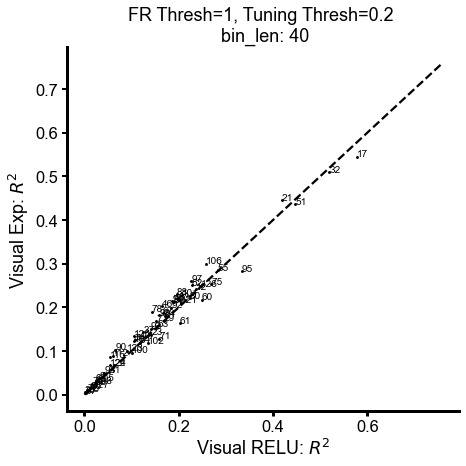

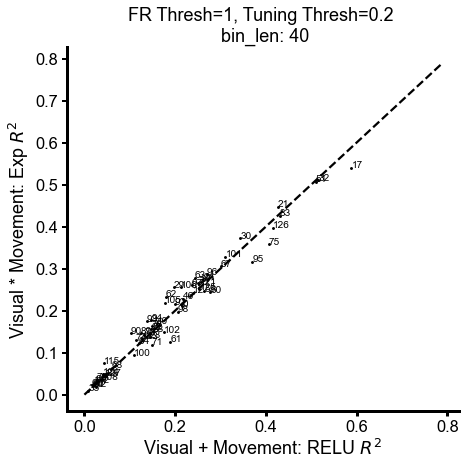

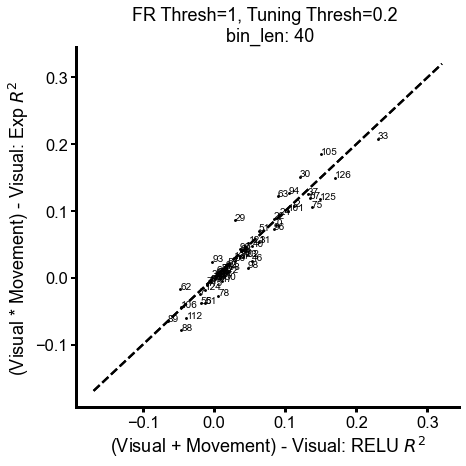

In [55]:
fig, ax = plt.subplots(figsize=(7,7))
xvals = GLM_VisMov_Li_m1['r2_all'][tuning_sig2]
yvals = GLM_VisMov_NL_m1['r2_all'][tuning_sig2]
lim_max = np.nanmax((xvals,yvals))+1.5*np.nanstd((xvals,yvals))
lim_min = np.nanmin((xvals,yvals))-1.5*np.nanstd((xvals,yvals))
lims = (0, lim_max)
ax.scatter(xvals,yvals,2,c='k')
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
ax.set_xlabel('Visual RELU: $R^2$')
ax.set_ylabel('Visual Exp: $R^2$')
ax.set_title('FR Thresh={}, Tuning Thresh={} \n bin_len: {}'.format(thresh_fr,tuning_thresh,bin_length))
for i, txt in enumerate(np.arange(len(xvals))):
    ax.annotate(tuning_idx[i], (xvals[i], yvals[i]),fontsize=10)
plt.tight_layout()
# fig.savefig(FigPath/'RELU_Vs_Exp_M1_binlen{}.png'.format(bin_length), facecolor='white', transparent=True)


fig, ax = plt.subplots(figsize=(7,7))
xvals = GLM_VisMov_Li_m2['r2_all'][tuning_sig2]
yvals = GLM_VisMov_NL_m2['r2_all'][tuning_sig2]
tuning_idx = np.where(tuning_sig2)[0]
lim_max = np.nanmax((xvals,yvals))+1.5*np.nanstd((xvals,yvals))
lim_min = np.nanmin((xvals,yvals))-1.5*np.nanstd((xvals,yvals))
lims = (0, lim_max)
ax.scatter(xvals,yvals,2,c='k')
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
ax.set_xlabel('Visual + Movement: RELU $R^2$')
ax.set_ylabel('Visual * Movement: Exp $R^2$')
ax.set_title('FR Thresh={}, Tuning Thresh={} \n bin_len: {}'.format(thresh_fr,tuning_thresh,bin_length))
for i, txt in enumerate(np.arange(len(xvals))):
    ax.annotate(tuning_idx[i], (xvals[i], yvals[i]),fontsize=10)
plt.tight_layout()
# fig.savefig(FigPath/'RELU_Vs_Exp_m2_binlen{}.png'.format(bin_length), facecolor='white', transparent=True)


fig, ax = plt.subplots(figsize=(7,7))
xvals = GLM_VisMov_Li_m2['r2_all'][tuning_sig2]-GLM_VisMov_Li_m1['r2_all'][tuning_sig2]
yvals = GLM_VisMov_NL_m2['r2_all'][tuning_sig2]-GLM_VisMov_NL_m1['r2_all'][tuning_sig2]
lim_max = np.nanmax((xvals,yvals))+1.5*np.nanstd((xvals,yvals))
lim_min = np.nanmin((xvals,yvals))-1.5*np.nanstd((xvals,yvals))
lims = (lim_min, lim_max)
ax.scatter(xvals,yvals,2,c='k')
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)

ax.set_xlabel('(Visual + Movement) - Visual: RELU $R^2$')
ax.set_ylabel('(Visual * Movement) - Visual: Exp $R^2$')
ax.set_title('FR Thresh={}, Tuning Thresh={} \n bin_len: {}'.format(thresh_fr,tuning_thresh,bin_length))
for i, txt in enumerate(np.arange(len(xvals))):
    ax.annotate(tuning_idx[i], (xvals[i], yvals[i]),fontsize=10)
plt.tight_layout()

# fig.savefig(FigPath/'VisMoveMVis_RELU_Vs_Exp_m2_binlen{}.png'.format(bin_length), facecolor='white', transparent=True)

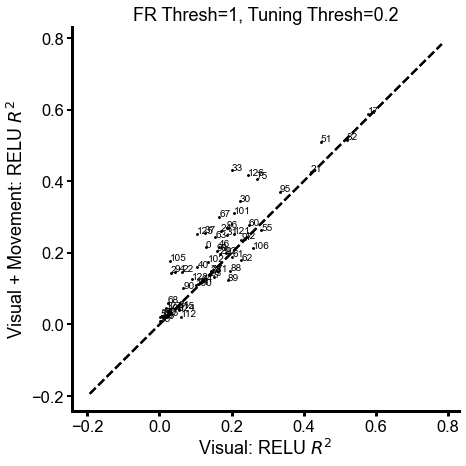

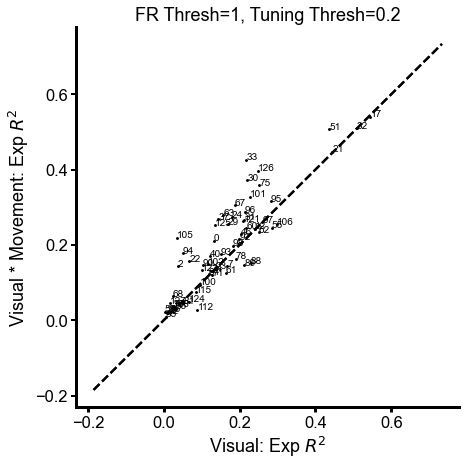

In [51]:
fig, ax = plt.subplots(figsize=(7,7))
xvals = GLM_VisMov_Li_m1['r2_all'][tuning_sig2]
yvals = GLM_VisMov_Li_m2['r2_all'][tuning_sig2] 
lim_max = np.nanmax((xvals,yvals))+1.5*np.nanstd((xvals,yvals))
lim_min = np.nanmin((xvals,yvals))-1.5*np.nanstd((xvals,yvals))
lims = (lim_min, lim_max)
ax.scatter(xvals,yvals,2,c='k')
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)

ax.set_xlabel('Visual: RELU $R^2$')
ax.set_ylabel('Visual + Movement: RELU $R^2$')
ax.set_title('FR Thresh={}, Tuning Thresh={}'.format(thresh_fr,tuning_thresh))
for i, txt in enumerate(np.arange(len(xvals))):
    ax.annotate(tuning_idx[i], (xvals[i], yvals[i]),fontsize=10)
plt.tight_layout()

# fig.savefig(FigPath/'VisMoveMVis_m12_softplus.png', facecolor='white', transparent=True)

fig, ax = plt.subplots(figsize=(7,7))
xvals = GLM_VisMov_NL_m1['r2_all'][tuning_sig2]
yvals = GLM_VisMov_NL_m2['r2_all'][tuning_sig2] 
lim_max = np.nanmax((xvals,yvals))+1.5*np.nanstd((xvals,yvals))
lim_min = np.nanmin((xvals,yvals))-1.5*np.nanstd((xvals,yvals))
lims = (lim_min, lim_max)
ax.scatter(xvals,yvals,2,c='k')
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)

ax.set_xlabel('Visual: Exp $R^2$')
ax.set_ylabel('Visual * Movement: Exp $R^2$')
ax.set_title('FR Thresh={}, Tuning Thresh={}'.format(thresh_fr,tuning_thresh))
for i, txt in enumerate(np.arange(len(xvals))):
    ax.annotate(tuning_idx[i], (xvals[i], yvals[i]),fontsize=10)
plt.tight_layout()

# fig.savefig(FigPath/'VisMoveMVis_Exp_Vs_Exp_m12.png', facecolor='white', transparent=True)


In [ ]:
plt.plot(avg_fr,)

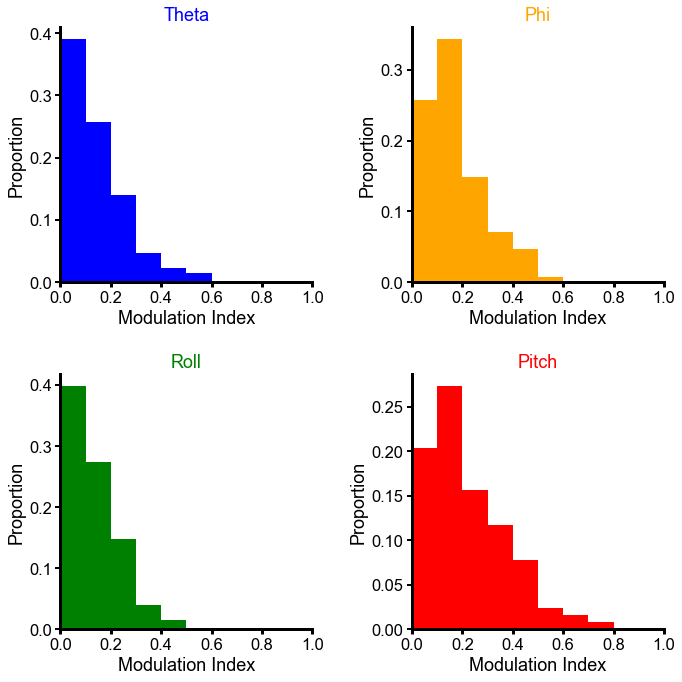

In [68]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
ax = ax.flatten()
dwidth = .1
for modeln in np.arange(len(titles)):
    count,edges = np.histogram(tuning_sig[:,modeln], bins=np.arange(0,1.1,dwidth))
    edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    ax[modeln].bar(edges_mid, count/len(tuning_sig[:,modeln]),color=clrs[modeln],width=dwidth)
    ax[modeln].set_title('{}'.format(titles[modeln]), color=clrs[modeln])
    ax[modeln].set_xlabel('Modulation Index')
    ax[modeln].set_ylabel('Proportion')
    ax[modeln].set_xlim(0,1)
#     ax[modeln].set_ylim(0,.2)
plt.tight_layout()


In [216]:
tuning_stds.shape

(128, 4, 1)

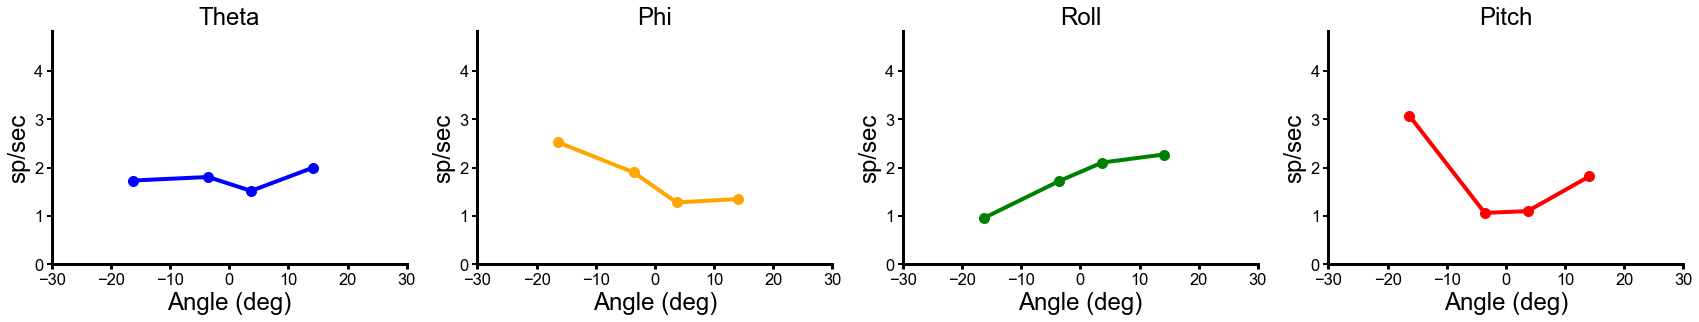

In [69]:
celln = 63
fontsize = 24
fig, axs = plt.subplots(1,4, figsize=(24,5))
# Tuning Curves
for i,modeln in enumerate(range(len(titles))):
    metric = move_data[:,modeln]
    axs[modeln].plot(edge_mids,tuning_curves[celln,modeln],'.-', ms=20, lw=4,c=clrs[modeln])
    axs[modeln].set_xlim(-30,30)
    axs[modeln].set_xlabel('Angle (deg)',fontsize=fontsize)
    axs[modeln].set_ylabel('sp/sec',fontsize=fontsize)
    axs[modeln].set_title(titles[modeln],fontsize=fontsize)
    axs[modeln].set_ylim(bottom=0,top=np.nanmax(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
plt.tight_layout()

## Plotting Motor Only

In [ ]:
bin_length=40
data, train_idx, test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=do_shuffle, do_norm=False,free_move=free_move, has_imu=free_move, has_mouse=False)
locals().update(data)
# if do_shuffle:
#     save_datafile = save_dir/'GLM_{}_Data_Mov_dt{:03d}_T{:02d}_MovModel{:d}_shuffled.h5'.format(model_type,int(model_dt*1000), nt_glm_lag, MovModel)
# else:
#     save_datafile = save_dir/'GLM_{}_Data_Mov_dt{:03d}_T{:02d}_MovModel{:d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag,MovModel)
# GLM_Vis = ioh5.load(save_datafile)
# locals().update(GLM_Vis)
##### Explore Neurons #####
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
# Initialize movement combinations
titles = np.array(['Theta','Phi','Roll','Pitch']) # 'dg_p','dg_n' 'roll','pitch'
titles_all = []
for n in range(1,len(titles)+1):
    perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
    for ind in range(perms.shape[0]):
        titles_all.append('_'.join([t for t in titles[perms[ind]]]))

# train_dgaze_p = train_dth + np.diff(train_gz,append=0)
# train_dgaze_n = train_dth - np.diff(train_gz,append=0)
# test_dgaze_p = test_dth + np.diff(test_gz,append=0)
# test_dgaze_n = test_dth - np.diff(test_gz,append=0)
move_train = np.hstack((train_th[:,np.newaxis],train_phi[:,np.newaxis],train_roll[:,np.newaxis],train_pitch[:,np.newaxis]))#, train_dth[:,np.newaxis],train_dphi[:,np.newaxis]))
move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_roll[:,np.newaxis],test_pitch[:,np.newaxis])) #,test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))#
# move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))# test_dth[:,np.newaxis],test_dphi[:,np.newaxis]))
model_move = np.hstack((model_th[:,np.newaxis],model_phi[:,np.newaxis],model_roll[:,np.newaxis],model_pitch[:,np.newaxis])) #,test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))#
model_move = model_move - np.mean(model_move,axis=0)
move_test = move_test - np.mean(move_test,axis=0)
# Create all tuning curves for plotting
N_bins=10
ncells = model_nsp.shape[-1]
ax_ylims = np.zeros((model_nsp.shape[-1],len(titles)))
tuning_curves = np.zeros((model_nsp.shape[-1],len(titles),N_bins-1))
tuning_stds = np.zeros((model_nsp.shape[-1],len(titles),N_bins-1))
var_ranges = np.zeros((len(titles),N_bins-1))
for modeln in range(len(titles)):
    metric = move_test[:,modeln]
    tuning, tuning_std, var_range = tuning_curve(test_nsp, metric, N_bins=N_bins, model_dt=model_dt)
    tuning_curves[:,modeln] = tuning
    tuning_stds[:,modeln] = tuning_std
    ax_ylims[:,modeln] = np.max(tuning,axis=1)
    var_ranges[modeln] = var_range

In [ ]:
celln = 49 #np.argmax(mr2)
bin_length = 40
ncells=model_nsp.shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
quartiles = np.arange(0,1.25,.25)

fig, axs = plt.subplots(2,5, figsize=((35,10))) 

predcell = pred_all[:,celln]/model_dt
nspcell = test_nsp[:,celln]/model_dt
test_nsp_smooth=(np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
pred_smooth=(np.convolve(pred_all[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
# Set up predicted spike range between 1-99th percentile
stat_bins = 5
pred_range = np.quantile(predcell,[.1,.9])
test_nsp_range = np.quantile(nspcell,[.01,1])
spike_percentiles = np.arange(0,1.25,.25)
spike_percentiles[-1]=.99
spk_percentile2 = np.arange(.125,1.125,.25)
pred_rangelin = np.quantile(predcell,spike_percentiles)
xbin_pts = np.quantile(predcell,spk_percentile2)
stat_bins = len(pred_rangelin) #5


axs[0,0].plot(np.arange(len(test_nsp_smooth))*model_dt,test_nsp_smooth,'k',label='test FR')
axs[0,0].plot(np.arange(len(pred_smooth))*model_dt,pred_smooth,'r', label='pred FR')
axs[0,0].set_xlabel('Time (s)')
axs[0,0].set_ylabel('Firing Rate (spks/s)')
axs[0,0].legend()
axs[0,0].set_title('Smoothed FRs')

# Eye Tuning Curve
top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
for i,modeln in enumerate(range(len(titles)-2)):
    metric = move_test[:,modeln]
    nranges = np.quantile(metric,quartiles)
    stat_range, edges, _ = binned_statistic(metric,test_nsp[:,celln],statistic='mean',bins=nranges)
    edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
    norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=len(cmap.colors))
    for m in range(len(nranges)-1):
        axs[0,1].axvspan(nranges[m], nranges[m+1],ymin=i*1/2,ymax=(i+1)*1/2,alpha=0.8, color=colors[m],zorder=0)
    #     axs[0,1].errorbar(var_ranges[modeln],tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln],label=titles[modeln],c=clrs[modeln],lw=4,elinewidth=3)
    axs[0,1].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

axs[0,1].set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.max(tuning_stds,axis=(1,2))[celln])
axs[0,1].set_xlim(-30,30)
axs[0,1].set_xlabel('Angle ($ ^{\degree}$)')
axs[0,1].set_ylabel('Spikes/s')
axs[0,1].set_title('Eye Tuning Curves')
lines = axs[0,1].get_lines()
legend1 = axs[0,1].legend([lines[0]],[titles[0]],bbox_to_anchor=(1.01, .2), fontsize=12)
legend2 = axs[0,1].legend([lines[1]],[titles[1]],bbox_to_anchor=(1.01, .9), fontsize=12)
axs[0,1].add_artist(legend1)

# Head Tuning Curves
top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
for i, modeln in enumerate(range(2,len(titles))):
    metric = move_test[:,modeln]
#     nranges = np.round(np.quantile(var_ranges[modeln],quartiles),decimals=1)
    nranges = np.round(np.quantile(metric,quartiles),decimals=1)
    stat_range, edges, _ = binned_statistic(metric,test_nsp[:,celln],statistic='mean',bins=nranges)
    edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
    norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=len(cmap.colors))
    for m in range(len(nranges)-1):
        axs[0,2].axvspan(nranges[m], nranges[m+1],ymin=i*1/2,ymax=(i+1)*1/2,alpha=0.8, color=colors[m],zorder=0)
#     axs[0,2].errorbar(var_ranges[modeln], tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln], label=titles[modeln], c=clrs[modeln],lw=4,elinewidth=3)
    axs[0,2].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

axs[0,2].set_ylim(bottom=0,top=top_yaxs)
axs[0,2].set_xlim(-30,30)
axs[0,2].set_xlabel('Angle ($ ^{\degree}$)')
axs[0,2].set_ylabel('Spikes/s')
axs[0,2].set_title('Head Tuning Curves')
lines = axs[0,2].get_lines()
legend1 = axs[0,2].legend([lines[0]],[titles[2]],bbox_to_anchor=(1.01, .2), fontsize=12)
legend2 = axs[0,2].legend([lines[1]],[titles[3]],bbox_to_anchor=(1.01, .9), fontsize=12)
axs[0,2].add_artist(legend1)

# axs[0,2].legend(bbox_to_anchor=(1.01, 1), fontsize=12)


# pred_rangelin = np.linspace(pred_range[0],pred_range[1],stat_bins)
axs[0,3].scatter(pred_all[celln]/model_dt,test_nsp[celln]/model_dt,c='k',s=15)
axs[0,3].plot(np.linspace(test_nsp_range[0],test_nsp_range[1]),np.linspace(test_nsp_range[0],test_nsp_range[1]),'k--',zorder=0)
axs[0,3].set_xlabel('Predicted Spike Rate')
axs[0,3].set_ylabel('Actual Spike Rate')

# cbar = add_colorbar(img)
# cbar.set_label('count')

if MovModel == 1:
    w_move = np.zeros((model_nsp.shape[-1],len(titles)))
elif MovModel == 3:
    Msta = w_move[:,:-len(titles)].reshape((model_nsp.shape[-1],nt_glm_lag,len(titles))+nks)
    w_move = w_move[:,-len(titles):]
for modeln in range(len(titles)):
    axs[0,4].bar(modeln, w_move[celln,modeln], color=clrs[modeln])
    axs[0,4].set_xticks(np.arange(0,len(titles)))
    axs[0,4].set_xticklabels(titles)
    axs[0,4].set_ylabel('GLM Weight')


mse_add = np.zeros((ncells,len(titles),len(quartiles)-1))
mse_mult = np.zeros((ncells,len(titles),len(quartiles)-1))
alpha_add = np.zeros((ncells,len(titles),len(quartiles)-1))
alpha_mult = np.zeros((ncells,len(titles),len(quartiles)-1))

traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
traces_mean = np.zeros((ncells,len(titles),stat_bins-1)) # (model_type,quartile,FR)
edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
# df_traces = pd.DataFrame([],columns=['modeln','quartile','FR']) 
for modeln in range(len(titles)):
    metric = move_test[:,modeln]
    nranges = np.quantile(metric,quartiles)# np.linspace(np.nanmean(metric)-2*np.nanstd(metric), np.nanmean(metric)+2*np.nanstd(metric),N_bins)
    stat_all, edges, _ = binned_statistic(predcell,nspcell, statistic='mean',bins=pred_rangelin)
    edge_mids = xbin_pts#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    traces_mean[celln,modeln]=stat_all
    max_fr = np.max(stat_all)
#     axs[0,modeln].set_xlim(0,pred_range[1]+np.std(pred_range))
#     axs[0,modeln].set_ylim(0,np.max(stat)+np.std(stat))

    for n in range(len(nranges)-1):
        ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
        pred = predcell[ind]
        sp = nspcell[ind]

        stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
        edge_mids = xbin_pts #np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
        traces[celln,modeln,n]=stat_range
        edges_all[celln,modeln,n]=edge_mids
        res_add = minimize_scalar(f_add,args=(stat_range/max_fr, stat_all/max_fr))
        res_mult = minimize_scalar(f_mult,args=(stat_range/max_fr, stat_all/max_fr))
        mse_add[celln, modeln, n] = res_add.fun
        mse_mult[celln, modeln, n] = res_mult.fun
        alpha_add[celln, modeln, n] = res_add.x
        alpha_mult[celln, modeln, n] = res_mult.x

        axs[1,modeln].plot(edge_mids, stat_range,'.-', c=colors[n],label='{:.02f} : {:.02f}'.format(nranges[n],nranges[n+1]),lw=4,ms=20,alpha=.9)
        axs[1,modeln].set_title('Metric: {}'.format(titles[modeln]), color=clrs[modeln])
        axs[1,modeln].set_xlabel('Predicted Spike Rate')
        axs[1,modeln].set_ylabel('Actual Spike Rate')
    
    axs[1,modeln].plot([0, 1], [0, 1], 'k--', transform=axs[1,modeln].transAxes, lw=2, zorder=0)
    axs[1,modeln].plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8)
    axs[1,modeln].legend(bbox_to_anchor=(1.01, 1), fontsize=12)
#     axs[1,modeln].axis('equal')
    axs[1,modeln].set_xlim(left=0)
#     axs[1,modeln].set(xlim=lims, ylim=lims)
#     axs[1,modeln].set_xlim([0,xbin_pts[-1]])
    axs[1,modeln].set_ylim(bottom=0)

dmodel = mse_add[celln]-mse_mult[celln]
crange = np.max(np.abs(dmodel))
im = axs[1,-1].imshow(dmodel,cmap='seismic',vmin=-crange,vmax=crange)
axs[1,-1].set_yticks(np.arange(0,4))
axs[1,-1].set_yticklabels(titles)
axs[1,-1].set_ylabel('Movement Model')
axs[1,-1].set_xticks(np.arange(0,4))
axs[1,-1].set_xticklabels(['.25','.5','.75','1'])
axs[1,-1].set_xlabel('Quantile Range')
axs[1,-1].set_title('$MSE_{add}$ - $MSE_{mult}$')
cbar = add_colorbar(im)

plt.suptitle('Celln:{}, r2={:.03f}'.format(celln,r2_all[celln]),y=1,fontsize=30)
plt.tight_layout()


# fig.savefig(FigPath/'CellSummary_N{}_T{:02d}.png'.format(celln,nt_glm_lag), facecolor='white', transparent=True)

In [ ]:
##### Make PDF of All Cells #####
bin_length=40
MovModel = 1
do_shuffle = False
ncells=model_nsp.shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
for model_dt in [.05]: #
    data, train_idx, test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=do_shuffle, do_norm=False,free_move=free_move, has_imu=free_move, has_mouse=False)
    locals().update(data)
    if do_shuffle:
        GLM_Vis = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_shuffled.h5'.format(model_type,int(model_dt*1000), nt_glm_lag, MovModel))
    else:
        GLM_Vis = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag,MovModel))
    locals().update(GLM_Vis)
    ##### Explore Neurons #####
    colors = plt.cm.cool(np.linspace(0,1,4))
    clrs = ['blue','orange','green','red']
    # Initialize movement combinations
    titles = np.array(['Theta','Phi','Roll','Pitch']) # 'dg_p','dg_n' 'roll','pitch'
    titles_all = []
    for n in range(1,len(titles)+1):
        perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
        for ind in range(perms.shape[0]):
            titles_all.append('_'.join([t for t in titles[perms[ind]]]))

    # train_dgaze_p = train_dth + np.diff(train_gz,append=0)
    # train_dgaze_n = train_dth - np.diff(train_gz,append=0)
    # test_dgaze_p = test_dth + np.diff(test_gz,append=0)
    # test_dgaze_n = test_dth - np.diff(test_gz,append=0)
    move_train = np.hstack((train_th[:,np.newaxis],train_phi[:,np.newaxis],train_roll[:,np.newaxis],train_pitch[:,np.newaxis]))#, train_dth[:,np.newaxis],train_dphi[:,np.newaxis]))
    move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_roll[:,np.newaxis],test_pitch[:,np.newaxis])) #,test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))#
    # move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))# test_dth[:,np.newaxis],test_dphi[:,np.newaxis]))
    model_move = np.hstack((model_th[:,np.newaxis],model_phi[:,np.newaxis],model_roll[:,np.newaxis],model_pitch[:,np.newaxis])) #,test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))#
    model_move = model_move - np.mean(model_move,axis=0)
    move_test = move_test - np.mean(move_test,axis=0)
    
    # Create all tuning curves for plotting
    N_bins=10
    ncells = model_nsp.shape[-1]
    ax_ylims = np.zeros((model_nsp.shape[-1],len(titles)))
    tuning_curves = np.zeros((model_nsp.shape[-1],len(titles),N_bins-1))
    tuning_stds = np.zeros((model_nsp.shape[-1],len(titles),N_bins-1))
    var_ranges = np.zeros((len(titles),N_bins-1))
    for modeln in range(len(titles)):
        metric = move_test[:,modeln]
        tuning, tuning_std, var_range = tuning_curve(test_nsp, metric, N_bins=N_bins, model_dt=model_dt)
        tuning_curves[:,modeln] = tuning
        tuning_stds[:,modeln] = tuning_std
        ax_ylims[:,modeln] = np.max(tuning,axis=1)
        var_ranges[modeln] = var_range
        
    quartiles = np.arange(0,1.25,.25)
    if do_shuffle:
        pdf_name = FigPath/ 'VisMov_dt{:03d}_T{:02d}_MovModel{:d}_CellSummary_shuff.pdf'.format(model_type,int(model_dt*1000), nt_glm_lag, MovModel)
    else:
        pdf_name = FigPath/ 'VisMov_dt{:03d}_T{:02d}_MovModel{:d}_CellSummary.pdf'.format(model_type,int(model_dt*1000),nt_glm_lag, MovModel)
    with PdfPages(pdf_name) as pdf:
        for celln in tqdm(range(model_nsp.shape[1])):            

            fig, axs = plt.subplots(2,5, figsize=((35,10))) 

            predcell = pred_all[:,celln]/model_dt
            nspcell = test_nsp[:,celln]/model_dt
            test_nsp_smooth=(np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
            pred_smooth=(np.convolve(pred_all[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
            # Set up predicted spike range between 1-99th percentile
            stat_bins = 5
            pred_range = np.quantile(predcell,[.1,.9])
            test_nsp_range = np.quantile(nspcell,[.01,1])
            spike_percentiles = np.arange(0,1.25,.25)
            spike_percentiles[-1]=.99
            spk_percentile2 = np.arange(.125,1.125,.25)
            pred_rangelin = np.quantile(predcell,spike_percentiles)
            xbin_pts = np.quantile(predcell,spk_percentile2)
            stat_bins = len(pred_rangelin) #5


            axs[0,0].plot(np.arange(len(test_nsp_smooth))*model_dt,test_nsp_smooth,'k',label='test FR')
            axs[0,0].plot(np.arange(len(pred_smooth))*model_dt,pred_smooth,'r', label='pred FR')
            axs[0,0].set_xlabel('Time (s)')
            axs[0,0].set_ylabel('Firing Rate (spks/s)')
            axs[0,0].legend()
            axs[0,0].set_title('Smoothed FRs')

            # Eye Tuning Curve
            top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
            for i,modeln in enumerate(range(len(titles)-2)):
                metric = move_test[:,modeln]
                nranges = np.quantile(metric,quartiles)
                stat_range, edges, _ = binned_statistic(metric,test_nsp[:,celln],statistic='mean',bins=nranges)
                edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
                cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
                norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=len(cmap.colors))
                for m in range(len(nranges)-1):
                    axs[0,1].axvspan(nranges[m], nranges[m+1],ymin=i*1/2,ymax=(i+1)*1/2,alpha=0.8, color=colors[m],zorder=0)
                #     axs[0,1].errorbar(var_ranges[modeln],tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln],label=titles[modeln],c=clrs[modeln],lw=4,elinewidth=3)
                axs[0,1].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

            axs[0,1].set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.max(tuning_stds,axis=(1,2))[celln])
            axs[0,1].set_xlim(-30,30)
            axs[0,1].set_xlabel('Angle ($ ^{\degree}$)')
            axs[0,1].set_ylabel('Spikes/s')
            axs[0,1].set_title('Eye Tuning Curves')
            lines = axs[0,1].get_lines()
            legend1 = axs[0,1].legend([lines[0]],[titles[0]],bbox_to_anchor=(1.01, .2), fontsize=12)
            legend2 = axs[0,1].legend([lines[1]],[titles[1]],bbox_to_anchor=(1.01, .9), fontsize=12)
            axs[0,1].add_artist(legend1)

            # Head Tuning Curves
            top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
            for i, modeln in enumerate(range(2,len(titles))):
                metric = move_test[:,modeln]
            #     nranges = np.round(np.quantile(var_ranges[modeln],quartiles),decimals=1)
                nranges = np.round(np.quantile(metric,quartiles),decimals=1)
                stat_range, edges, _ = binned_statistic(metric,test_nsp[:,celln],statistic='mean',bins=nranges)
                edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
                cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
                norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=len(cmap.colors))
                for m in range(len(nranges)-1):
                    axs[0,2].axvspan(nranges[m], nranges[m+1],ymin=i*1/2,ymax=(i+1)*1/2,alpha=0.8, color=colors[m],zorder=0)
            #     axs[0,2].errorbar(var_ranges[modeln], tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln], label=titles[modeln], c=clrs[modeln],lw=4,elinewidth=3)
                axs[0,2].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

            axs[0,2].set_ylim(bottom=0,top=top_yaxs)
            axs[0,2].set_xlim(-30,30)
            axs[0,2].set_xlabel('Angle ($ ^{\degree}$)')
            axs[0,2].set_ylabel('Spikes/s')
            axs[0,2].set_title('Head Tuning Curves')
            lines = axs[0,2].get_lines()
            legend1 = axs[0,2].legend([lines[0]],[titles[2]],bbox_to_anchor=(1.01, .2), fontsize=12)
            legend2 = axs[0,2].legend([lines[1]],[titles[3]],bbox_to_anchor=(1.01, .9), fontsize=12)
            axs[0,2].add_artist(legend1)

            # axs[0,2].legend(bbox_to_anchor=(1.01, 1), fontsize=12)


            # pred_rangelin = np.linspace(pred_range[0],pred_range[1],stat_bins)
            axs[0,3].scatter(pred_all[celln]/model_dt,test_nsp[celln]/model_dt,c='k',s=15)
            axs[0,3].plot(np.linspace(test_nsp_range[0],test_nsp_range[1]),np.linspace(test_nsp_range[0],test_nsp_range[1]),'k--',zorder=0)
            axs[0,3].set_xlabel('Predicted Spike Rate')
            axs[0,3].set_ylabel('Actual Spike Rate')
            cbar = add_colorbar(img)
            # cbar.set_label('count')

            if MovModel == 1:
                w_move = np.zeros((model_nsp.shape[-1],len(titles)))
            elif MovModel == 3:
                Msta = w_move[:,:-len(titles)].reshape((model_nsp.shape[-1],nt_glm_lag,len(titles))+nks)
                w_move = w_move[:,-len(titles):]
            for modeln in range(len(titles)):
                axs[0,4].bar(modeln, w_move[celln,modeln], color=clrs[modeln])
                axs[0,4].set_xticks(np.arange(0,len(titles)))
                axs[0,4].set_xticklabels(titles)
                axs[0,4].set_ylabel('GLM Weight')


            mse_add = np.zeros((ncells,len(titles),len(quartiles)-1))
            mse_mult = np.zeros((ncells,len(titles),len(quartiles)-1))
            alpha_add = np.zeros((ncells,len(titles),len(quartiles)-1))
            alpha_mult = np.zeros((ncells,len(titles),len(quartiles)-1))

            traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
            traces_mean = np.zeros((ncells,len(titles),stat_bins-1)) # (model_type,quartile,FR)
            edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
            # df_traces = pd.DataFrame([],columns=['modeln','quartile','FR']) 
            for modeln in range(len(titles)):
                metric = move_test[:,modeln]
                nranges = np.quantile(metric,quartiles)# np.linspace(np.nanmean(metric)-2*np.nanstd(metric), np.nanmean(metric)+2*np.nanstd(metric),N_bins)
                stat_all, edges, _ = binned_statistic(predcell,nspcell, statistic='mean',bins=pred_rangelin)
                edge_mids = xbin_pts#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
                traces_mean[celln,modeln]=stat_all
                max_fr = np.max(stat_all)
            #     axs[0,modeln].set_xlim(0,pred_range[1]+np.std(pred_range))
            #     axs[0,modeln].set_ylim(0,np.max(stat)+np.std(stat))

                for n in range(len(nranges)-1):
                    ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
                    pred = predcell[ind]
                    sp = nspcell[ind]

                    stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
                    edge_mids = xbin_pts #np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
                    traces[celln,modeln,n]=stat_range
                    edges_all[celln,modeln,n]=edge_mids
                    res_add = minimize_scalar(f_add,args=(stat_range/max_fr, stat_all/max_fr))
                    res_mult = minimize_scalar(f_mult,args=(stat_range/max_fr, stat_all/max_fr))
                    mse_add[celln, modeln, n] = res_add.fun
                    mse_mult[celln, modeln, n] = res_mult.fun
                    alpha_add[celln, modeln, n] = res_add.x
                    alpha_mult[celln, modeln, n] = res_mult.x

                    axs[1,modeln].plot(edge_mids, stat_range,'.-', c=colors[n],label='{:.02f} : {:.02f}'.format(nranges[n],nranges[n+1]),lw=4,ms=20,alpha=.9)
                    axs[1,modeln].set_title('Metric: {}'.format(titles[modeln]), color=clrs[modeln])
                    axs[1,modeln].set_xlabel('Predicted Spike Rate')
                    axs[1,modeln].set_ylabel('Actual Spike Rate')

                axs[1,modeln].plot([0, 1], [0, 1], 'k--', transform=axs[1,modeln].transAxes, lw=2, zorder=0)
                axs[1,modeln].plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8)
                axs[1,modeln].legend(bbox_to_anchor=(1.01, 1), fontsize=12)
            #     axs[1,modeln].axis('equal')
                axs[1,modeln].set_xlim(left=0)
            #     axs[1,modeln].set(xlim=lims, ylim=lims)
            #     axs[1,modeln].set_xlim([0,xbin_pts[-1]])
                axs[1,modeln].set_ylim(bottom=0)

            dmodel = mse_add[celln]-mse_mult[celln]
            crange = np.max(np.abs(dmodel))
            im = axs[1,-1].imshow(dmodel,cmap='seismic',vmin=-crange,vmax=crange)
            axs[1,-1].set_yticks(np.arange(0,4))
            axs[1,-1].set_yticklabels(titles)
            axs[1,-1].set_ylabel('Movement Model')
            axs[1,-1].set_xticks(np.arange(0,4))
            axs[1,-1].set_xticklabels(['.25','.5','.75','1'])
            axs[1,-1].set_xlabel('Quantile Range')
            axs[1,-1].set_title('$MSE_{add}$ - $MSE_{mult}$')
            cbar = add_colorbar(im)

            plt.suptitle('Celln:{}, r2={:.03f}'.format(celln,r2_all[celln]),y=1,fontsize=30)
            plt.tight_layout()

            pdf.savefig()
            plt.close()

    # fig.savefig(FigPath/'CellSummary_N{}.png'.format(celln), facecolor='white', transparent=True)

In [ ]:
bin_length= 40
fig, axs = plt.subplots(figsize=(15,5))
test_nsp_smooth=(np.convolve(GLM_VisMov_m2['test_nsp'][:,21], np.ones(bin_length), 'same')) / (bin_length * model_dt)
pred_smooth=(np.convolve(GLM_VisMov_m2['pred_all'][:,21], np.ones(bin_length), 'same')) / (bin_length * model_dt)
axs.plot(np.arange(len(test_nsp_smooth))*model_dt,test_nsp_smooth,'k',label='test FR')
axs.plot(np.arange(len(pred_smooth))*model_dt,pred_smooth,'r', label='pred FR')
axs.set_xlabel('Time (s)')
axs.set_ylabel('Firing Rate (spks/s)')
axs.legend()
axs.set_title('Smoothed FRs')
plt.tight_layout()
fig.savefig(FigPath/'TestPred_example.png', facecolor='white', transparent=True)

## Test Plots

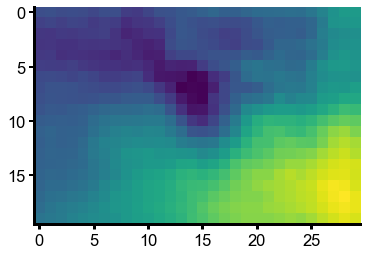

In [167]:
plt.imshow(sta_init.reshape((output_size+1,nt_glm_lag,)+nks)[31,2])

In [ ]:
msetest.shape

In [ ]:
plt.plot(msetest[0,:,126])
mlam

In [ ]:
sta_all = w_cv.transpose(1,2,3,0).reshape((nalph,nlam,output_size,nt_glm_lag,)+nks)
pred_all = pred_cv.transpose(1,2,0,3)
sta_all.shape,pred_all.shape

In [125]:
sta_all.shape

(101, 5, 20, 30)

In [ ]:

celln = 49# np.argmax(r2_all)
bin_length = 40
ncells = model_nsp.shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
quartiles = np.arange(0,1.25,.25)
bin_length=40
alph = 0#malph[celln]
lam = 0# mlam[celln]
for n, celln in enumerate(tqdm([21,49,51,25])):
    fig2 = plt.figure(constrained_layout=False, figsize=(20,7))
    spec2 = gridspec.GridSpec(ncols=nt_glm_lag, nrows=2, figure=fig2)
    axs = np.array([fig2.add_subplot(spec2[0, n]) for n in range(nt_glm_lag)])
    f2_ax6 = fig2.add_subplot(spec2[1, :nt_glm_lag//2])
    f2_ax7 = fig2.add_subplot(spec2[1, nt_glm_lag//2:-1])
    f2_ax8 = fig2.add_subplot(spec2[1,-1])
    if MovModel != 0:
        crange = np.max(np.abs(sta_all[alph,lam,celln]))
        for n,ax in enumerate(axs):
            im = ax.imshow(sta_all[alph,lam,celln,n],'RdBu_r',vmin=-crange,vmax=crange)
            cbar = add_colorbar(im)
            ax.axis('off')

    sp_smooth = ((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    f2_ax6.plot(np.arange(len(sp_smooth))*model_dt,sp_smooth, 'k', lw=2)
    pred_smooth = ((np.convolve(pred_all[alph,lam,:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    f2_ax6.plot(np.arange(len(pred_smooth))*model_dt,pred_smooth,'r', lw=2)
    f2_ax6.set_xlabel('Time (s)')
    f2_ax6.set_ylabel('Spike Rate')
    f2_ax7.plot(tloss_trace_all[alph,lam,:,celln])
    f2_ax7.plot(vloss_trace_all[alph,lam,:,celln])
    f2_ax7.set_xlabel('Batch #')
    f2_ax7.set_ylabel('Loss')
    r2 = (np.corrcoef(sp_smooth,pred_smooth)[0,1])**2
    
    if MovModel == 1:
        w_move = np.zeros((model_nsp.shape[-1],len(titles)))
    elif MovModel == 3:
        Msta = w_move[:,:-len(titles)].reshape((model_nsp.shape[-1],nt_glm_lag,len(titles))+nks)
        w_move = w_move[:,-len(titles):]
    for modeln in range(len(titles)):
        f2_ax8.bar(modeln, w_move[celln,modeln], color=clrs[modeln])
        f2_ax8.set_xticks(np.arange(0,len(titles)))
        f2_ax8.set_xticklabels(titles)
        f2_ax8.set_ylabel('GLM Weight')
    
    plt.suptitle('celln: {} $r^2$:{:.03f}'.format(celln, r2))
    plt.tight_layout()


  0%|          | 0/6 [00:00<?, ?it/s]

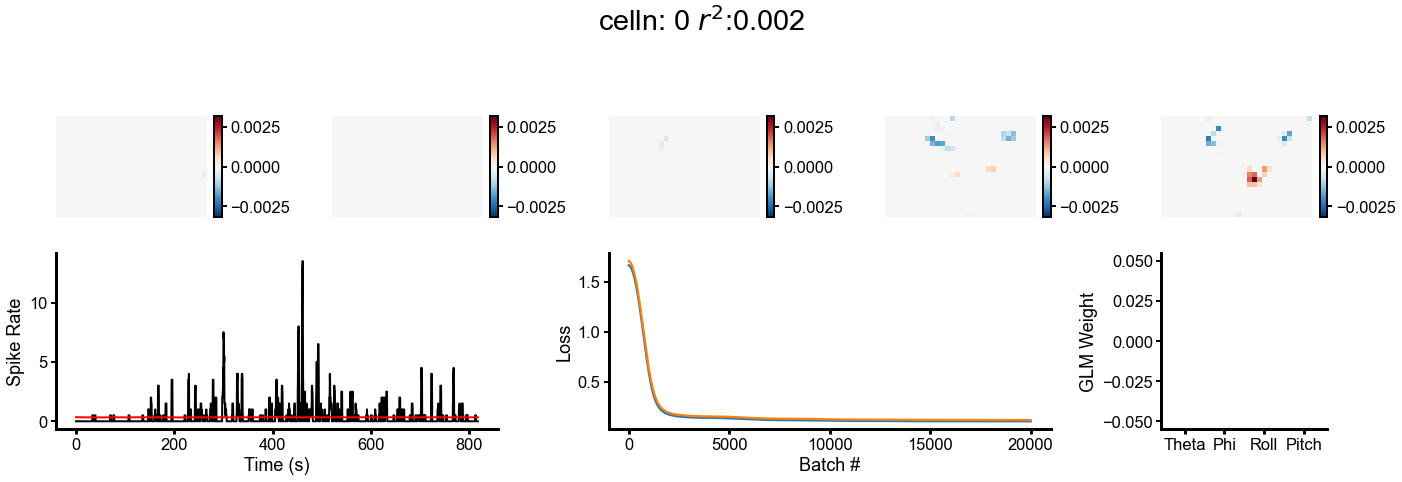

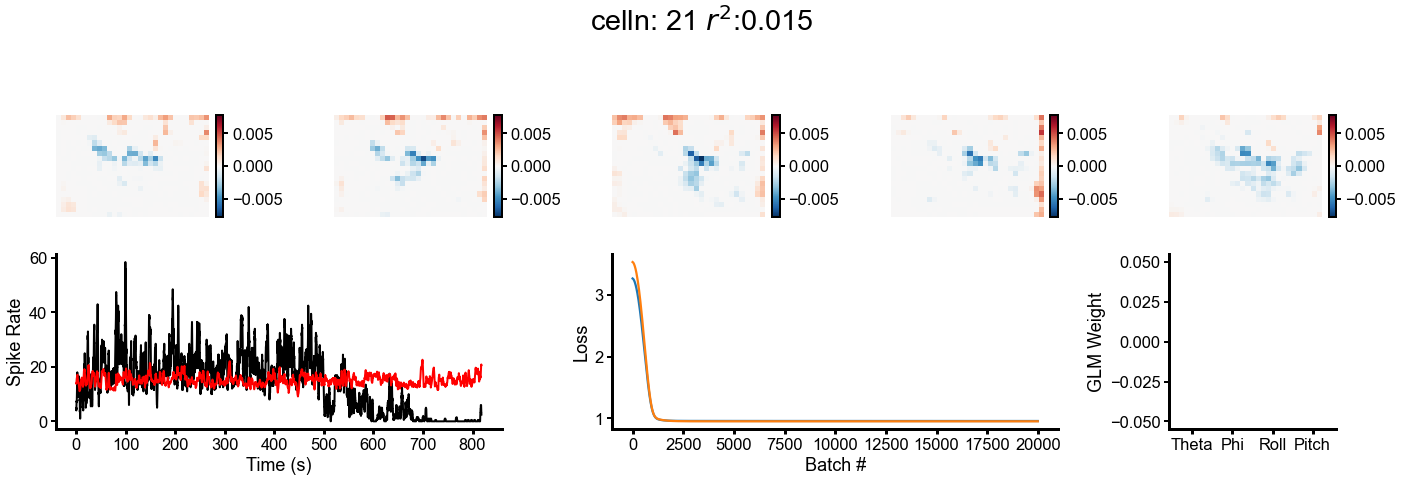

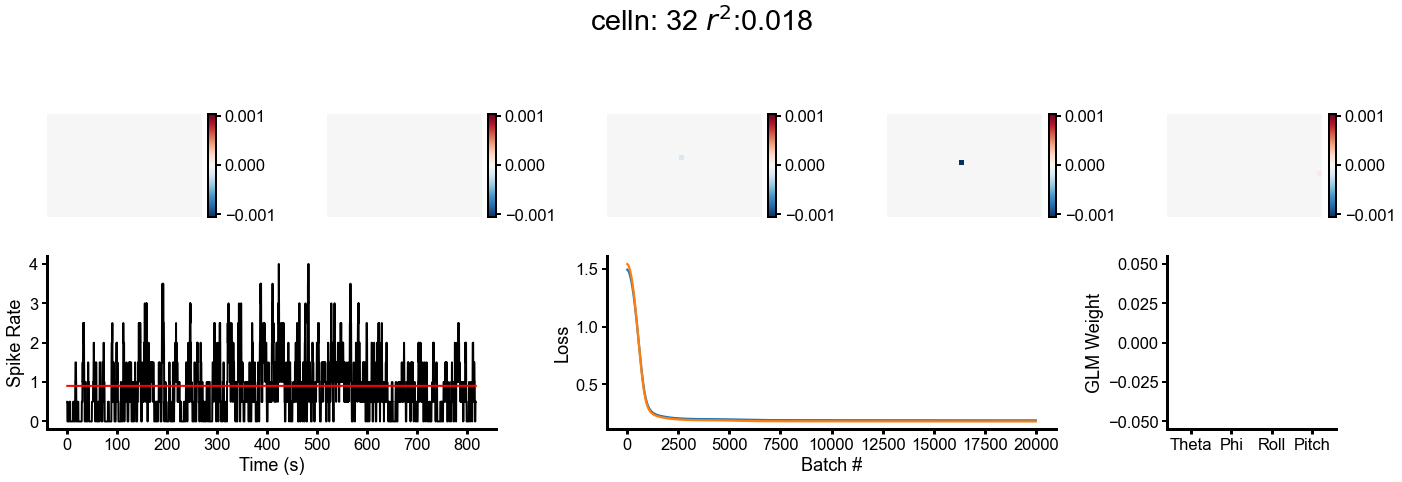

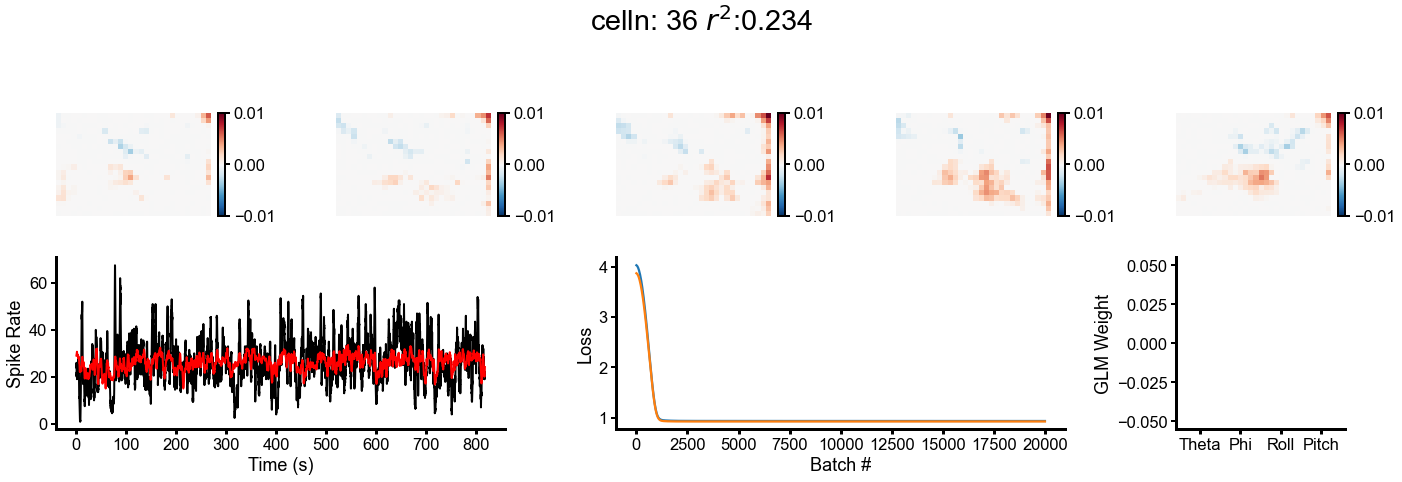

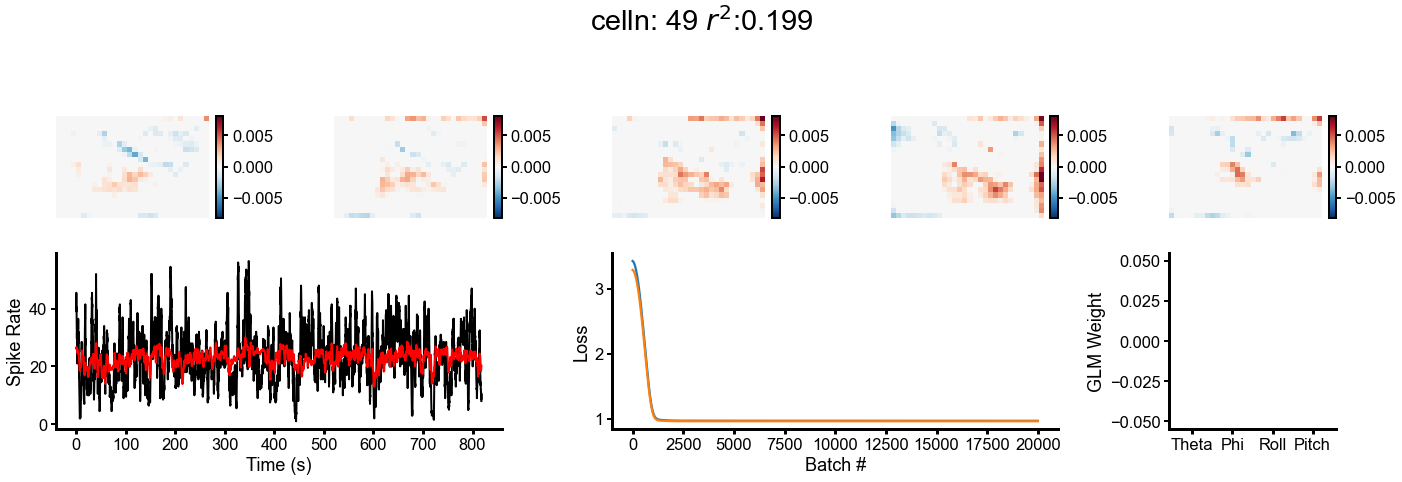

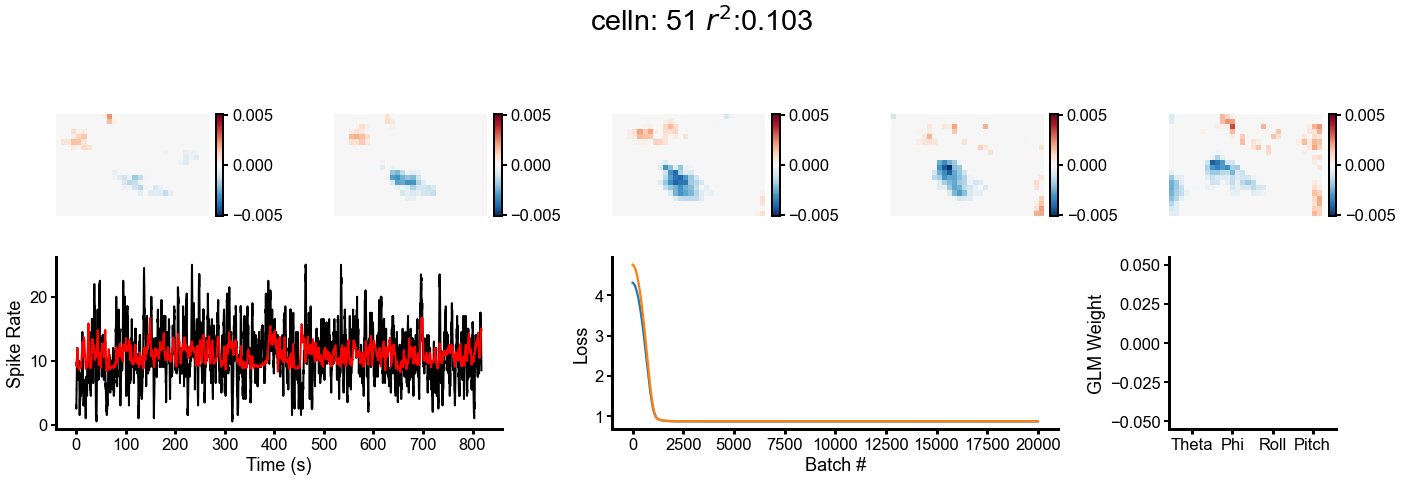

In [164]:
celln = 49# np.argmax(r2_all)
bin_length = 40
ncells = model_nsp.shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
quartiles = np.arange(0,1.25,.25)
bin_length=40
alph = malph[celln]
lam = mlam[celln]
for n, celln in enumerate(tqdm([0,21,32,36,49,51])):
    fig2 = plt.figure(constrained_layout=False, figsize=(20,7))
    spec2 = gridspec.GridSpec(ncols=nt_glm_lag, nrows=2, figure=fig2)
    axs = np.array([fig2.add_subplot(spec2[0, n]) for n in range(nt_glm_lag)])
    f2_ax6 = fig2.add_subplot(spec2[1, :nt_glm_lag//2])
    f2_ax7 = fig2.add_subplot(spec2[1, nt_glm_lag//2:-1])
    f2_ax8 = fig2.add_subplot(spec2[1,-1])
    if MovModel != 0:
        crange = np.max(np.abs(sta_all[celln]))
        for n,ax in enumerate(axs):
            im = ax.imshow(sta_all[celln,n],'RdBu_r',vmin=-crange,vmax=crange)
            cbar = add_colorbar(im)
            ax.axis('off')

    sp_smooth = ((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    f2_ax6.plot(np.arange(len(sp_smooth))*model_dt,sp_smooth, 'k', lw=2)
    pred_smooth = ((np.convolve(pred_all.T[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    f2_ax6.plot(np.arange(len(pred_smooth))*model_dt,pred_smooth,'r', lw=2)
    f2_ax6.set_xlabel('Time (s)')
    f2_ax6.set_ylabel('Spike Rate')
    f2_ax7.plot(tloss_trace_all[alph,lam,:,celln])
    f2_ax7.plot(vloss_trace_all[alph,lam,:,celln])
    f2_ax7.set_xlabel('Batch #')
    f2_ax7.set_ylabel('Loss')
    r2 = (np.corrcoef(sp_smooth,pred_smooth)[0,1])**2
    
    if MovModel == 1:
        w_move = np.zeros((model_nsp.shape[-1],len(titles)))
    elif MovModel == 3:
        Msta = w_move[:,:-len(titles)].reshape((model_nsp.shape[-1],nt_glm_lag,len(titles))+nks)
        w_move = w_move[:,-len(titles):]
    for modeln in range(len(titles)):
        f2_ax8.bar(modeln, w_move[celln,modeln], color=clrs[modeln])
        f2_ax8.set_xticks(np.arange(0,len(titles)))
        f2_ax8.set_xticklabels(titles)
        f2_ax8.set_ylabel('GLM Weight')
    
    plt.suptitle('celln: {} $r^2$:{:.03f}'.format(celln, r2))
    plt.tight_layout()


In [ ]:
bin_length=40
alph = 0
lam = np.argmin(msetest[0,:,celln])
print(lam)
pdf_name = FigPath/ 'VisMov_{}_dt{:03d}_Lags{:02d}_MovModel{:d}_FitSummary.pdf'.format(model_type,int(model_dt*1000),nt_glm_lag, MovModel)
with PdfPages(pdf_name) as pdf:
    for n, celln in enumerate(tqdm(range(output_size))):
        fig2 = plt.figure(constrained_layout=False, figsize=(20,7))
        spec2 = gridspec.GridSpec(ncols=nt_glm_lag, nrows=2, figure=fig2)
        axs = np.array([fig2.add_subplot(spec2[0, n]) for n in range(nt_glm_lag)])
        f2_ax6 = fig2.add_subplot(spec2[1, :nt_glm_lag//2])
        f2_ax7 = fig2.add_subplot(spec2[1, nt_glm_lag//2:-1])
        f2_ax8 = fig2.add_subplot(spec2[1,-1])
        if MovModel != 0:
            crange = np.max(np.abs(sta_all[celln]))
            for n,ax in enumerate(axs):
                im = ax.imshow(sta_all[celln,n],'RdBu_r',vmin=-crange,vmax=crange)
                cbar = add_colorbar(im)
                ax.axis('off')

        sp_smooth = ((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
        f2_ax6.plot(np.arange(len(sp_smooth))*model_dt,sp_smooth, 'k', lw=2)
        pred_smooth = ((np.convolve(pred_all.T[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
        f2_ax6.plot(np.arange(len(pred_smooth))*model_dt,pred_smooth,'r', lw=2)
        f2_ax6.set_xlabel('Time (s)')
        f2_ax6.set_ylabel('Spike Rate')
        f2_ax7.plot(tloss_trace_all[alph,lam,:,celln])
        f2_ax7.plot(vloss_trace_all[alph,lam,:,celln])
        f2_ax7.set_xlabel('Batch #')
        f2_ax7.set_ylabel('Loss')
        r2 = (np.corrcoef(sp_smooth,pred_smooth)[0,1])**2

        if MovModel == 1:
            w_move = np.zeros((model_nsp.shape[-1],len(titles)))
        elif MovModel == 3:
            Msta = w_move[:,:-len(titles)].reshape((model_nsp.shape[-1],nt_glm_lag,len(titles))+nks)
            w_move = w_move[:,-len(titles):]
        for modeln in range(len(titles)):
            f2_ax8.bar(modeln, w_move[celln,modeln], color=clrs[modeln])
            f2_ax8.set_xticks(np.arange(0,len(titles)))
            f2_ax8.set_xticklabels(titles)
            f2_ax8.set_ylabel('GLM Weight')

        plt.suptitle('celln: {} $r^2$:{:.03f}'.format(celln, r2))
        plt.tight_layout()
        pdf.savefig()
        plt.close()